# Mask R-CNN Training and Inference
In this notebook we use Matterport's implementation of Mask R-CNN to train on a custom dataset, then use the trained weights to run inference on new images.

This is part of a tutorial posted at http://www.immersivelimit.com/tutorials/using-mask-r-cnn-on-custom-coco-like-dataset, so check there for more details.

### Not a beginner tutorial...
This is not intended to be a complete beginner tutorial.
- You should know how to clone a git repository from GitHub
- You should have a decent understanding of Python programming
- You should understand the basics of training deep neural networks. If you've never done it before, I wouldn't recommend starting here. Find a beginner deep learning tutorial/course and start there. There's lots of great free stuff on YouTube.

## **Download the Free Training Dataset First!
I've provided a free training dataset of cigarette butt images for use with this tutorial.
1. Download it from here: http://www.immersivelimit.com/datasets/cigarette-butts
2. Then extract the files and put it in the "../datasets" directory of this repo
3. The code below will be looking for "../datasets/cig_butts/train", "../datasets/cig_butts/val", and "../datasets/cig_butts/real_test"

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw

## Import Matterport's "mrcnn" libraries
1. I'm using a forked version of Matterport's Mask_RCNN git repo to make sure this code works, even if the main repo changes. As of July 29, 2018, there is a bug in Matterport's version that breaks loading an existing model that I've fixed in my version (and submitted a pull request to fix it in theirs).
  - My version is here: https://github.com/akTwelve/Mask_RCNN
  - The original is here: https://github.com/matterport/Mask_RCNN
2. Update the code cell below to point to the root directory of the repo on your machine.

In [2]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = './'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

Using TensorFlow backend.


## Set up logging and pre-trained model paths
This will default to sub-directories in your mask_rcnn_dir, but if you want them somewhere else, updated it here.

It will also download the pre-trained coco model.

In [4]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR,"Pretrained_Model","mask_rcnn_coco.h5")

print(COCO_MODEL_PATH)

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

./Pretrained_Model/mask_rcnn_coco.h5


## Configuration
Define configurations for training on the Cigarette Butt dataset.
### Note
These are settings that worked on my machine (GTX 970 graphics card). If you are getting OOM (Out of Memory) errors, you may need to tweak the settings or your computer may not be powerful enough. If you have a better graphics card, you will want to tweak it to take advantage of that.

In [5]:
class CigButtsConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cig_butts"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (cig_butt)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CigButtsConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES 

# Define the dataset
I've attempted to make this generic to any COCO-like dataset. That means if you have another dataset defined in the COCO format, it should work.

In [6]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

# Create the Training and Validation Datasets
Make sure you download the training dataset linked at the top of this notebook. If you put the dataset somewhere else, update the paths below.

In [7]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/home/ayush/Instance_Segmentation/all/Mask_RCNN/Cigaettes_Dataset/cig_butts/train/coco_annotations.json', '/home/ayush/Instance_Segmentation/all/Mask_RCNN/Cigaettes_Dataset/cig_butts/train/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/home/ayush/Instance_Segmentation/all/Mask_RCNN/Cigaettes_Dataset/cig_butts/val/coco_annotations.json', '/home/ayush/Instance_Segmentation/all/Mask_RCNN/Cigaettes_Dataset/cig_butts/val/images')
dataset_val.prepare()

## Display a few images from the training dataset

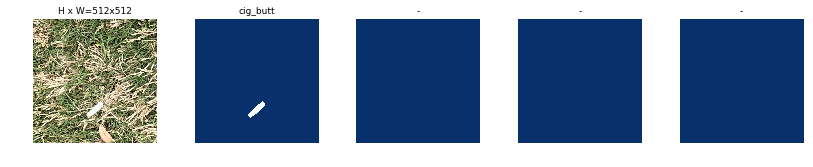

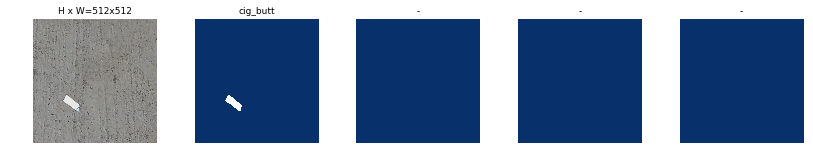

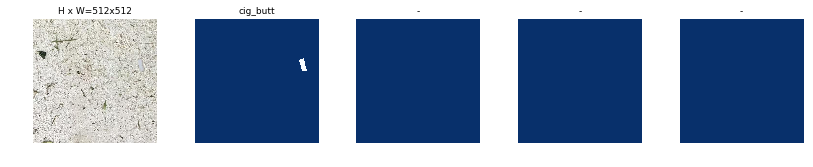

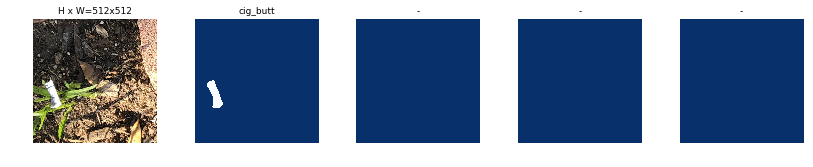

In [8]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Create the Training Model and Train
This code is largely borrowed from the train_shapes.ipynb notebook.

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.



In [11]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./logs/cig_butts20190310T0041/mask_rcnn_cig_butts_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/4


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

  1/500 [..............................] - ETA: 1:43:02 - loss: 3.1065 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 2.6375 - mrcnn_class_loss: 0.4231 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  2/500 [..............................] - ETA: 1:09:40 - loss: 2.9236 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 2.5549 - mrcnn_class_loss: 0.3230 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  3/500 [..............................] - ETA: 58:05 - loss: 2.6916 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 2.4073 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00  

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  4/500 [..............................] - ETA: 52:19 - loss: 2.4305 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 2.2017 - mrcnn_class_loss: 0.1843 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  5/500 [..............................] - ETA: 48:49 - loss: 2.1372 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 1.9448 - mrcnn_class_loss: 0.1486 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  6/500 [..............................] - ETA: 46:27 - loss: 1.8560 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 1.6889 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  7/500 [..............................] - ETA: 44:46 - loss: 1.6108 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 1.4624 - mrcnn_class_loss: 0.1066 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  8/500 [..............................] - ETA: 43:28 - loss: 1.4197 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 1.2857 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  9/500 [..............................] - ETA: 42:26 - loss: 1.2694 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 1.1469 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 10/500 [..............................] - ETA: 41:38 - loss: 1.1473 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 1.0344 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 11/500 [..............................] - ETA: 41:00 - loss: 1.0465 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.9417 - mrcnn_class_loss: 0.0679 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 12/500 [..............................] - ETA: 40:28 - loss: 1.0826 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.8653 - mrcnn_class_loss: 0.0814 - mrcnn_bbox_loss: 0.0176 - mrcnn_mask_loss: 0.0828        

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 13/500 [..............................] - ETA: 39:58 - loss: 1.2076 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.8407 - mrcnn_class_loss: 0.1155 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1452

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 14/500 [..............................] - ETA: 39:31 - loss: 1.3237 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.8187 - mrcnn_class_loss: 0.1594 - mrcnn_bbox_loss: 0.1156 - mrcnn_mask_loss: 0.1980

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 15/500 [..............................] - ETA: 39:07 - loss: 1.4059 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.7984 - mrcnn_class_loss: 0.1921 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2417

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 16/500 [..............................] - ETA: 38:45 - loss: 1.4599 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.7794 - mrcnn_class_loss: 0.2118 - mrcnn_bbox_loss: 0.1612 - mrcnn_mask_loss: 0.2778

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 17/500 [>.............................] - ETA: 38:26 - loss: 1.4865 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.7612 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.1707 - mrcnn_mask_loss: 0.3076

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 18/500 [>.............................] - ETA: 38:09 - loss: 1.4910 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.7436 - mrcnn_class_loss: 0.2144 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.3322

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 19/500 [>.............................] - ETA: 37:52 - loss: 1.4838 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.7265 - mrcnn_class_loss: 0.2054 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3524

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 20/500 [>.............................] - ETA: 37:36 - loss: 1.4727 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.7097 - mrcnn_class_loss: 0.1975 - mrcnn_bbox_loss: 0.1704 - mrcnn_mask_loss: 0.3690

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 21/500 [>.............................] - ETA: 37:22 - loss: 1.4578 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.6930 - mrcnn_class_loss: 0.1899 - mrcnn_bbox_loss: 0.1667 - mrcnn_mask_loss: 0.3827

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 22/500 [>.............................] - ETA: 37:09 - loss: 1.4445 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.6765 - mrcnn_class_loss: 0.1852 - mrcnn_bbox_loss: 0.1637 - mrcnn_mask_loss: 0.3942

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 23/500 [>.............................] - ETA: 36:58 - loss: 1.4308 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.6601 - mrcnn_class_loss: 0.1811 - mrcnn_bbox_loss: 0.1613 - mrcnn_mask_loss: 0.4039

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 24/500 [>.............................] - ETA: 36:47 - loss: 1.4127 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.6438 - mrcnn_class_loss: 0.1750 - mrcnn_bbox_loss: 0.1578 - mrcnn_mask_loss: 0.4123

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 25/500 [>.............................] - ETA: 36:37 - loss: 1.4268 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.6878 - mrcnn_class_loss: 0.1681 - mrcnn_bbox_loss: 0.1515 - mrcnn_mask_loss: 0.3958

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 26/500 [>.............................] - ETA: 36:27 - loss: 1.4373 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.7260 - mrcnn_class_loss: 0.1617 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.3806

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 27/500 [>.............................] - ETA: 36:18 - loss: 1.4412 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.7555 - mrcnn_class_loss: 0.1557 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.3665

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 28/500 [>.............................] - ETA: 36:13 - loss: 1.4371 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.7753 - mrcnn_class_loss: 0.1502 - mrcnn_bbox_loss: 0.1353 - mrcnn_mask_loss: 0.3534

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 29/500 [>.............................] - ETA: 36:09 - loss: 1.4246 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.7850 - mrcnn_class_loss: 0.1450 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.3412

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 30/500 [>.............................] - ETA: 36:01 - loss: 1.4072 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.7884 - mrcnn_class_loss: 0.1402 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.3298

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 31/500 [>.............................] - ETA: 35:56 - loss: 1.3863 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.7870 - mrcnn_class_loss: 0.1357 - mrcnn_bbox_loss: 0.1222 - mrcnn_mask_loss: 0.3192

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 32/500 [>.............................] - ETA: 35:51 - loss: 1.4199 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.7810 - mrcnn_class_loss: 0.1323 - mrcnn_bbox_loss: 0.1563 - mrcnn_mask_loss: 0.3282

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 33/500 [>.............................] - ETA: 35:45 - loss: 1.4338 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.7715 - mrcnn_class_loss: 0.1292 - mrcnn_bbox_loss: 0.1747 - mrcnn_mask_loss: 0.3367

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 34/500 [=>............................] - ETA: 35:40 - loss: 1.4283 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.7590 - mrcnn_class_loss: 0.1262 - mrcnn_bbox_loss: 0.1773 - mrcnn_mask_loss: 0.3442

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 35/500 [=>............................] - ETA: 35:34 - loss: 1.4047 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.7537 - mrcnn_class_loss: 0.1226 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3344

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 36/500 [=>............................] - ETA: 35:26 - loss: 1.3811 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.7474 - mrcnn_class_loss: 0.1192 - mrcnn_bbox_loss: 0.1674 - mrcnn_mask_loss: 0.3251

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 37/500 [=>............................] - ETA: 35:19 - loss: 1.3833 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.7301 - mrcnn_class_loss: 0.1171 - mrcnn_bbox_loss: 0.1834 - mrcnn_mask_loss: 0.3309

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 38/500 [=>............................] - ETA: 35:12 - loss: 1.3580 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.7213 - mrcnn_class_loss: 0.1141 - mrcnn_bbox_loss: 0.1786 - mrcnn_mask_loss: 0.3222

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 39/500 [=>............................] - ETA: 35:07 - loss: 1.3584 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.7043 - mrcnn_class_loss: 0.1122 - mrcnn_bbox_loss: 0.1930 - mrcnn_mask_loss: 0.3272

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 40/500 [=>............................] - ETA: 35:00 - loss: 1.3307 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.6923 - mrcnn_class_loss: 0.1094 - mrcnn_bbox_loss: 0.1882 - mrcnn_mask_loss: 0.3190

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 41/500 [=>............................] - ETA: 34:52 - loss: 1.3018 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.6782 - mrcnn_class_loss: 0.1068 - mrcnn_bbox_loss: 0.1836 - mrcnn_mask_loss: 0.3112

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 42/500 [=>............................] - ETA: 34:46 - loss: 1.2720 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.6626 - mrcnn_class_loss: 0.1042 - mrcnn_bbox_loss: 0.1793 - mrcnn_mask_loss: 0.3038

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 43/500 [=>............................] - ETA: 34:41 - loss: 1.2435 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.6475 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.1751 - mrcnn_mask_loss: 0.2967

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 44/500 [=>............................] - ETA: 34:34 - loss: 1.2178 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.6347 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.1711 - mrcnn_mask_loss: 0.2900

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 45/500 [=>............................] - ETA: 34:29 - loss: 1.1944 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.6235 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.1673 - mrcnn_mask_loss: 0.2835

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 46/500 [=>............................] - ETA: 34:24 - loss: 1.2284 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.6408 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.1772 - mrcnn_mask_loss: 0.2885

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 47/500 [=>............................] - ETA: 34:19 - loss: 1.2060 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.6302 - mrcnn_class_loss: 0.0974 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.2824

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 48/500 [=>............................] - ETA: 34:14 - loss: 1.2249 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.6461 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.2869

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 49/500 [=>............................] - ETA: 34:10 - loss: 1.2382 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.6604 - mrcnn_class_loss: 0.0942 - mrcnn_bbox_loss: 0.1705 - mrcnn_mask_loss: 0.2911

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 50/500 [==>...........................] - ETA: 34:04 - loss: 1.2150 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.6482 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.2853

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 51/500 [==>...........................] - ETA: 34:01 - loss: 1.2148 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.6590 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.1639 - mrcnn_mask_loss: 0.2797

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 52/500 [==>...........................] - ETA: 33:58 - loss: 1.2122 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.6670 - mrcnn_class_loss: 0.0888 - mrcnn_bbox_loss: 0.1607 - mrcnn_mask_loss: 0.2743

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 53/500 [==>...........................] - ETA: 33:52 - loss: 1.2069 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.6718 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.1577 - mrcnn_mask_loss: 0.2691

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 54/500 [==>...........................] - ETA: 33:48 - loss: 1.1990 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.6736 - mrcnn_class_loss: 0.0855 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2641

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 55/500 [==>...........................] - ETA: 33:44 - loss: 1.1887 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.6727 - mrcnn_class_loss: 0.0839 - mrcnn_bbox_loss: 0.1519 - mrcnn_mask_loss: 0.2593

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 56/500 [==>...........................] - ETA: 33:40 - loss: 1.2272 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.6691 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 0.1914 - mrcnn_mask_loss: 0.2628

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 57/500 [==>...........................] - ETA: 33:36 - loss: 1.2083 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.6596 - mrcnn_class_loss: 0.0820 - mrcnn_bbox_loss: 0.1880 - mrcnn_mask_loss: 0.2582

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 58/500 [==>...........................] - ETA: 33:30 - loss: 1.2251 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.6573 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.2026 - mrcnn_mask_loss: 0.2632

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 59/500 [==>...........................] - ETA: 33:25 - loss: 1.2394 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.6496 - mrcnn_class_loss: 0.0803 - mrcnn_bbox_loss: 0.2234 - mrcnn_mask_loss: 0.2657

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 60/500 [==>...........................] - ETA: 33:20 - loss: 1.2402 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.6451 - mrcnn_class_loss: 0.0802 - mrcnn_bbox_loss: 0.2244 - mrcnn_mask_loss: 0.2703

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 61/500 [==>...........................] - ETA: 33:17 - loss: 1.2368 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.6400 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.2747

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 62/500 [==>...........................] - ETA: 33:14 - loss: 1.2344 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.6345 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.2213 - mrcnn_mask_loss: 0.2788

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 63/500 [==>...........................] - ETA: 33:10 - loss: 1.2344 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.6261 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.2293 - mrcnn_mask_loss: 0.2807

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 64/500 [==>...........................] - ETA: 33:06 - loss: 1.2341 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.6203 - mrcnn_class_loss: 0.0779 - mrcnn_bbox_loss: 0.2316 - mrcnn_mask_loss: 0.2844

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 65/500 [==>...........................] - ETA: 33:03 - loss: 1.2326 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.6144 - mrcnn_class_loss: 0.0772 - mrcnn_bbox_loss: 0.2333 - mrcnn_mask_loss: 0.2879

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 66/500 [==>...........................] - ETA: 33:00 - loss: 1.2273 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.6084 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.2317 - mrcnn_mask_loss: 0.2910

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 67/500 [===>..........................] - ETA: 32:56 - loss: 1.2196 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.6021 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.2285 - mrcnn_mask_loss: 0.2937

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 68/500 [===>..........................] - ETA: 32:52 - loss: 1.2127 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.5955 - mrcnn_class_loss: 0.0745 - mrcnn_bbox_loss: 0.2267 - mrcnn_mask_loss: 0.2962

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 69/500 [===>..........................] - ETA: 32:47 - loss: 1.2169 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.5924 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.2342 - mrcnn_mask_loss: 0.2967

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 70/500 [===>..........................] - ETA: 32:42 - loss: 1.2120 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.5857 - mrcnn_class_loss: 0.0730 - mrcnn_bbox_loss: 0.2360 - mrcnn_mask_loss: 0.2974

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 71/500 [===>..........................] - ETA: 32:37 - loss: 1.2039 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.5788 - mrcnn_class_loss: 0.0723 - mrcnn_bbox_loss: 0.2341 - mrcnn_mask_loss: 0.2990

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 72/500 [===>..........................] - ETA: 32:34 - loss: 1.1989 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.5748 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.2334 - mrcnn_mask_loss: 0.2992

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 73/500 [===>..........................] - ETA: 32:31 - loss: 1.1929 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.5704 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.2313 - mrcnn_mask_loss: 0.2993

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 74/500 [===>..........................] - ETA: 32:28 - loss: 1.1863 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5657 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.2296 - mrcnn_mask_loss: 0.2994

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 75/500 [===>..........................] - ETA: 32:26 - loss: 1.1786 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.5589 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.2288 - mrcnn_mask_loss: 0.3002

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 76/500 [===>..........................] - ETA: 32:22 - loss: 1.1810 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5540 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.2356 - mrcnn_mask_loss: 0.2999

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 77/500 [===>..........................] - ETA: 32:19 - loss: 1.1818 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.5491 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.2412 - mrcnn_mask_loss: 0.2994

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 78/500 [===>..........................] - ETA: 32:15 - loss: 1.1789 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.5442 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.2438 - mrcnn_mask_loss: 0.2989

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 79/500 [===>..........................] - ETA: 32:11 - loss: 1.1722 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5391 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.2429 - mrcnn_mask_loss: 0.2981

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 80/500 [===>..........................] - ETA: 32:06 - loss: 1.1616 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5362 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.2399 - mrcnn_mask_loss: 0.2944

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 81/500 [===>..........................] - ETA: 32:02 - loss: 1.1567 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.5310 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.2418 - mrcnn_mask_loss: 0.2935

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 82/500 [===>..........................] - ETA: 31:57 - loss: 1.1574 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.5250 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.2492 - mrcnn_mask_loss: 0.2932

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 83/500 [===>..........................] - ETA: 31:52 - loss: 1.1545 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.5197 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.2532 - mrcnn_mask_loss: 0.2922

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 84/500 [====>.........................] - ETA: 31:47 - loss: 1.1433 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.5158 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.2501 - mrcnn_mask_loss: 0.2887

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 85/500 [====>.........................] - ETA: 31:43 - loss: 1.1320 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.5116 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.2472 - mrcnn_mask_loss: 0.2853

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 86/500 [====>.........................] - ETA: 31:39 - loss: 1.1201 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.5067 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.2443 - mrcnn_mask_loss: 0.2820

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 87/500 [====>.........................] - ETA: 31:35 - loss: 1.1080 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.5014 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.2415 - mrcnn_mask_loss: 0.2788

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 88/500 [====>.........................] - ETA: 31:31 - loss: 1.1099 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.4959 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.2488 - mrcnn_mask_loss: 0.2791

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 89/500 [====>.........................] - ETA: 31:26 - loss: 1.1037 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.4908 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.2491 - mrcnn_mask_loss: 0.2780

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 90/500 [====>.........................] - ETA: 31:22 - loss: 1.0986 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.4854 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.2494 - mrcnn_mask_loss: 0.2783

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 91/500 [====>.........................] - ETA: 31:16 - loss: 1.0907 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.4801 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.2469 - mrcnn_mask_loss: 0.2785

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 92/500 [====>.........................] - ETA: 31:12 - loss: 1.0862 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.4818 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.2443 - mrcnn_mask_loss: 0.2755

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 93/500 [====>.........................] - ETA: 31:07 - loss: 1.0844 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.4767 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.2478 - mrcnn_mask_loss: 0.2756

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 94/500 [====>.........................] - ETA: 31:02 - loss: 1.0843 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.4717 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.2532 - mrcnn_mask_loss: 0.2756

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 95/500 [====>.........................] - ETA: 30:57 - loss: 1.0817 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.4669 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.2569 - mrcnn_mask_loss: 0.2743

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 96/500 [====>.........................] - ETA: 30:52 - loss: 1.0760 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.4672 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.2542 - mrcnn_mask_loss: 0.2714

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 97/500 [====>.........................] - ETA: 30:47 - loss: 1.0697 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.4668 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.2516 - mrcnn_mask_loss: 0.2686

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 98/500 [====>.........................] - ETA: 30:43 - loss: 1.0624 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.4653 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.2490 - mrcnn_mask_loss: 0.2659

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 99/500 [====>.........................] - ETA: 30:38 - loss: 1.0541 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.4626 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.2465 - mrcnn_mask_loss: 0.2632

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


100/500 [=====>........................] - ETA: 30:33 - loss: 1.0447 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.4588 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.2606

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


101/500 [=====>........................] - ETA: 30:28 - loss: 1.0393 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.4544 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.2600

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


102/500 [=====>........................] - ETA: 30:23 - loss: 1.0297 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.4503 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.2416 - mrcnn_mask_loss: 0.2575

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


103/500 [=====>........................] - ETA: 30:18 - loss: 1.0269 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.4530 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.2393 - mrcnn_mask_loss: 0.2550

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


104/500 [=====>........................] - ETA: 30:13 - loss: 1.0192 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.4505 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.2370 - mrcnn_mask_loss: 0.2525

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


105/500 [=====>........................] - ETA: 30:08 - loss: 1.0121 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.4485 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.2347 - mrcnn_mask_loss: 0.2501

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


106/500 [=====>........................] - ETA: 30:04 - loss: 1.0049 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.4464 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.2325 - mrcnn_mask_loss: 0.2478

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


107/500 [=====>........................] - ETA: 29:59 - loss: 1.0010 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.4477 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.2303 - mrcnn_mask_loss: 0.2455

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


108/500 [=====>........................] - ETA: 29:54 - loss: 0.9968 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.4438 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.2309 - mrcnn_mask_loss: 0.2452

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


109/500 [=====>........................] - ETA: 29:49 - loss: 0.9999 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.4441 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.2319 - mrcnn_mask_loss: 0.2471

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


110/500 [=====>........................] - ETA: 29:44 - loss: 1.0006 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.4440 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.2315 - mrcnn_mask_loss: 0.2485

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


111/500 [=====>........................] - ETA: 29:39 - loss: 0.9990 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.4437 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.2295 - mrcnn_mask_loss: 0.2495

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


112/500 [=====>........................] - ETA: 29:34 - loss: 1.0014 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.4402 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.2335 - mrcnn_mask_loss: 0.2505

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


113/500 [=====>........................] - ETA: 29:29 - loss: 1.0017 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.4393 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.2347 - mrcnn_mask_loss: 0.2509

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


114/500 [=====>........................] - ETA: 29:24 - loss: 1.0021 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.4383 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.2363 - mrcnn_mask_loss: 0.2512

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


115/500 [=====>........................] - ETA: 29:19 - loss: 1.0030 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.4394 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.2357 - mrcnn_mask_loss: 0.2519

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


116/500 [=====>........................] - ETA: 29:14 - loss: 1.0014 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.4381 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.2358 - mrcnn_mask_loss: 0.2521

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


117/500 [======>.......................] - ETA: 29:09 - loss: 0.9983 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.4367 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.2346 - mrcnn_mask_loss: 0.2521

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


118/500 [======>.......................] - ETA: 29:04 - loss: 0.9945 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.4351 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.2329 - mrcnn_mask_loss: 0.2521

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


119/500 [======>.......................] - ETA: 28:59 - loss: 0.9937 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.4355 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.2319 - mrcnn_mask_loss: 0.2523

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


120/500 [======>.......................] - ETA: 28:54 - loss: 0.9904 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.4327 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.2310 - mrcnn_mask_loss: 0.2530

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


121/500 [======>.......................] - ETA: 28:49 - loss: 0.9882 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.4326 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.2292 - mrcnn_mask_loss: 0.2531

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


122/500 [======>.......................] - ETA: 28:44 - loss: 0.9833 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.4321 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.2273 - mrcnn_mask_loss: 0.2510

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


123/500 [======>.......................] - ETA: 28:39 - loss: 0.9777 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.4308 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.2255 - mrcnn_mask_loss: 0.2489

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


124/500 [======>.......................] - ETA: 28:34 - loss: 0.9798 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.4286 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.2308 - mrcnn_mask_loss: 0.2483

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


125/500 [======>.......................] - ETA: 28:29 - loss: 0.9728 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.4259 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.2289 - mrcnn_mask_loss: 0.2464

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


126/500 [======>.......................] - ETA: 28:24 - loss: 0.9654 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.4227 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.2271 - mrcnn_mask_loss: 0.2444

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


127/500 [======>.......................] - ETA: 28:19 - loss: 0.9726 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.4236 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.2325 - mrcnn_mask_loss: 0.2456

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


128/500 [======>.......................] - ETA: 28:14 - loss: 0.9654 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.4205 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.2307 - mrcnn_mask_loss: 0.2437

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


129/500 [======>.......................] - ETA: 28:09 - loss: 0.9586 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.4178 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.2289 - mrcnn_mask_loss: 0.2418

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


130/500 [======>.......................] - ETA: 28:04 - loss: 0.9520 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.4152 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.2272 - mrcnn_mask_loss: 0.2400

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


131/500 [======>.......................] - ETA: 27:59 - loss: 0.9541 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.4160 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.2284 - mrcnn_mask_loss: 0.2405

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


132/500 [======>.......................] - ETA: 27:54 - loss: 0.9523 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.4135 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.2300 - mrcnn_mask_loss: 0.2400

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


133/500 [======>.......................] - ETA: 27:49 - loss: 0.9519 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.4140 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.2293 - mrcnn_mask_loss: 0.2401

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


134/500 [=======>......................] - ETA: 27:44 - loss: 0.9502 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.4142 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.2277 - mrcnn_mask_loss: 0.2401

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


135/500 [=======>......................] - ETA: 27:39 - loss: 0.9482 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.4142 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.2265 - mrcnn_mask_loss: 0.2398

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


136/500 [=======>......................] - ETA: 27:35 - loss: 0.9415 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.4113 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.2248 - mrcnn_mask_loss: 0.2381

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


137/500 [=======>......................] - ETA: 27:30 - loss: 0.9397 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.4107 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.2246 - mrcnn_mask_loss: 0.2375

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


138/500 [=======>......................] - ETA: 27:25 - loss: 0.9373 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.4098 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.2239 - mrcnn_mask_loss: 0.2369

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


139/500 [=======>......................] - ETA: 27:20 - loss: 0.9398 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.4159 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.2351

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


140/500 [=======>......................] - ETA: 27:15 - loss: 0.9361 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.4147 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.2345

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


141/500 [=======>......................] - ETA: 27:10 - loss: 0.9324 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.4132 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.2196 - mrcnn_mask_loss: 0.2338

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


142/500 [=======>......................] - ETA: 27:05 - loss: 0.9283 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.4116 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.2331

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


143/500 [=======>......................] - ETA: 27:01 - loss: 0.9304 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.4172 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.2167 - mrcnn_mask_loss: 0.2315

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


144/500 [=======>......................] - ETA: 26:56 - loss: 0.9311 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.4144 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.2202 - mrcnn_mask_loss: 0.2318

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


145/500 [=======>......................] - ETA: 26:52 - loss: 0.9327 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.4195 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.2186 - mrcnn_mask_loss: 0.2302

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


146/500 [=======>......................] - ETA: 26:47 - loss: 0.9339 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.4241 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.2172 - mrcnn_mask_loss: 0.2286

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


147/500 [=======>......................] - ETA: 26:42 - loss: 0.9494 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.4281 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.2348

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


148/500 [=======>......................] - ETA: 26:37 - loss: 0.9493 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.4264 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.2251 - mrcnn_mask_loss: 0.2343

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


149/500 [=======>......................] - ETA: 26:32 - loss: 0.9582 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.4295 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.2283 - mrcnn_mask_loss: 0.2371

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


150/500 [========>.....................] - ETA: 26:28 - loss: 0.9639 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.4323 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.2298 - mrcnn_mask_loss: 0.2386

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


151/500 [========>.....................] - ETA: 26:24 - loss: 0.9669 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.4355 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.2303 - mrcnn_mask_loss: 0.2382

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


152/500 [========>.....................] - ETA: 26:19 - loss: 0.9694 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.4378 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.2298 - mrcnn_mask_loss: 0.2391

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


153/500 [========>.....................] - ETA: 26:15 - loss: 0.9713 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.4398 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.2294 - mrcnn_mask_loss: 0.2395

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


154/500 [========>.....................] - ETA: 26:10 - loss: 0.9725 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.4416 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.2290 - mrcnn_mask_loss: 0.2394

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


155/500 [========>.....................] - ETA: 26:05 - loss: 0.9753 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.4447 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.2295 - mrcnn_mask_loss: 0.2389

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


156/500 [========>.....................] - ETA: 26:01 - loss: 0.9775 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.4451 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.2314 - mrcnn_mask_loss: 0.2391

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


157/500 [========>.....................] - ETA: 25:57 - loss: 0.9781 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.4480 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.2301 - mrcnn_mask_loss: 0.2384

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


158/500 [========>.....................] - ETA: 25:52 - loss: 0.9786 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.4507 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.2289 - mrcnn_mask_loss: 0.2377

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


159/500 [========>.....................] - ETA: 25:48 - loss: 0.9790 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.4532 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.2280 - mrcnn_mask_loss: 0.2369

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


160/500 [========>.....................] - ETA: 25:44 - loss: 0.9806 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.4543 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.2274 - mrcnn_mask_loss: 0.2380

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


161/500 [========>.....................] - ETA: 25:40 - loss: 0.9801 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.4562 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.2262 - mrcnn_mask_loss: 0.2372

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


162/500 [========>.....................] - ETA: 25:36 - loss: 0.9792 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.4578 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.2248 - mrcnn_mask_loss: 0.2363

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


163/500 [========>.....................] - ETA: 25:31 - loss: 0.9872 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.4689 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2235 - mrcnn_mask_loss: 0.2349

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


164/500 [========>.....................] - ETA: 25:27 - loss: 0.9857 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.4696 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.2225 - mrcnn_mask_loss: 0.2340

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


165/500 [========>.....................] - ETA: 25:23 - loss: 0.9836 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.4698 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.2212 - mrcnn_mask_loss: 0.2331

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


166/500 [========>.....................] - ETA: 25:19 - loss: 0.9809 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.4696 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2200 - mrcnn_mask_loss: 0.2322

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


167/500 [=========>....................] - ETA: 25:14 - loss: 0.9881 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.4798 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2187 - mrcnn_mask_loss: 0.2308

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


168/500 [=========>....................] - ETA: 25:10 - loss: 0.9908 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.4803 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.2197 - mrcnn_mask_loss: 0.2319

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


169/500 [=========>....................] - ETA: 25:06 - loss: 0.9972 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.4897 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.2184 - mrcnn_mask_loss: 0.2305

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


170/500 [=========>....................] - ETA: 25:01 - loss: 1.0030 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.4983 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.2291

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


171/500 [=========>....................] - ETA: 24:57 - loss: 1.0078 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.5061 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.2278

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


172/500 [=========>....................] - ETA: 24:52 - loss: 1.0046 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.5036 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.2270

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


173/500 [=========>....................] - ETA: 24:47 - loss: 1.0075 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.5094 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.2149 - mrcnn_mask_loss: 0.2257

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


174/500 [=========>....................] - ETA: 24:42 - loss: 1.0094 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.5141 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.2136 - mrcnn_mask_loss: 0.2244

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


175/500 [=========>....................] - ETA: 24:37 - loss: 1.0130 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.5151 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2164 - mrcnn_mask_loss: 0.2237

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


176/500 [=========>....................] - ETA: 24:32 - loss: 1.0171 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.5175 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2179 - mrcnn_mask_loss: 0.2236

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


177/500 [=========>....................] - ETA: 24:27 - loss: 1.0190 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.5187 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.2185 - mrcnn_mask_loss: 0.2235

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


178/500 [=========>....................] - ETA: 24:22 - loss: 1.0191 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.5188 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2188 - mrcnn_mask_loss: 0.2232

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


179/500 [=========>....................] - ETA: 24:18 - loss: 1.0195 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.5195 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.2191 - mrcnn_mask_loss: 0.2225

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


180/500 [=========>....................] - ETA: 24:13 - loss: 1.0154 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.5170 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.2219

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


181/500 [=========>....................] - ETA: 24:08 - loss: 1.0145 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.5172 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.2214

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


182/500 [=========>....................] - ETA: 24:03 - loss: 1.0130 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.5171 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.2208

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


183/500 [=========>....................] - ETA: 23:58 - loss: 1.0107 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.5164 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.2162 - mrcnn_mask_loss: 0.2202

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


184/500 [==========>...................] - ETA: 23:54 - loss: 1.0091 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.5147 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.2168 - mrcnn_mask_loss: 0.2195

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


185/500 [==========>...................] - ETA: 23:50 - loss: 1.0062 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.5131 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.2188

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


186/500 [==========>...................] - ETA: 23:45 - loss: 1.0028 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.5110 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.2149 - mrcnn_mask_loss: 0.2182

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


187/500 [==========>...................] - ETA: 23:40 - loss: 1.0040 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.5147 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.2137 - mrcnn_mask_loss: 0.2170

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


188/500 [==========>...................] - ETA: 23:36 - loss: 0.9996 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.5121 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.2128 - mrcnn_mask_loss: 0.2164

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


189/500 [==========>...................] - ETA: 23:31 - loss: 0.9952 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.5095 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.2118 - mrcnn_mask_loss: 0.2157

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


190/500 [==========>...................] - ETA: 23:26 - loss: 0.9906 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.5068 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2108 - mrcnn_mask_loss: 0.2150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


191/500 [==========>...................] - ETA: 23:21 - loss: 0.9958 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.5095 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.2137 - mrcnn_mask_loss: 0.2148

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


192/500 [==========>...................] - ETA: 23:17 - loss: 0.9953 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.5100 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.2134 - mrcnn_mask_loss: 0.2141

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


193/500 [==========>...................] - ETA: 23:12 - loss: 0.9971 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.5121 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.2137 - mrcnn_mask_loss: 0.2138

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


194/500 [==========>...................] - ETA: 23:07 - loss: 0.9972 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.5136 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.2128 - mrcnn_mask_loss: 0.2134

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


195/500 [==========>...................] - ETA: 23:02 - loss: 0.9968 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.5145 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2120 - mrcnn_mask_loss: 0.2130

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


196/500 [==========>...................] - ETA: 22:58 - loss: 0.9949 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.5122 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.2133 - mrcnn_mask_loss: 0.2124

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


197/500 [==========>...................] - ETA: 22:53 - loss: 0.9942 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.5120 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.2135 - mrcnn_mask_loss: 0.2119

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


198/500 [==========>...................] - ETA: 22:48 - loss: 0.9929 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.5114 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2135 - mrcnn_mask_loss: 0.2113

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


199/500 [==========>...................] - ETA: 22:44 - loss: 0.9988 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.5154 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.2111

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


200/500 [===========>..................] - ETA: 22:39 - loss: 0.9988 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.5142 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.2173 - mrcnn_mask_loss: 0.2105

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


201/500 [===========>..................] - ETA: 22:35 - loss: 0.9988 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.5128 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2190 - mrcnn_mask_loss: 0.2099

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


202/500 [===========>..................] - ETA: 22:30 - loss: 0.9978 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.5112 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.2200 - mrcnn_mask_loss: 0.2094

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


203/500 [===========>..................] - ETA: 22:25 - loss: 1.0012 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.5144 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.2205 - mrcnn_mask_loss: 0.2091

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


204/500 [===========>..................] - ETA: 22:20 - loss: 0.9975 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.5123 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2198 - mrcnn_mask_loss: 0.2086

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


205/500 [===========>..................] - ETA: 22:16 - loss: 1.0030 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.5149 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.2087

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


206/500 [===========>..................] - ETA: 22:11 - loss: 1.0076 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.5173 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2244 - mrcnn_mask_loss: 0.2087

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


207/500 [===========>..................] - ETA: 22:06 - loss: 1.0104 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.5191 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.2255 - mrcnn_mask_loss: 0.2086

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


208/500 [===========>..................] - ETA: 22:02 - loss: 1.0083 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.5172 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.2261 - mrcnn_mask_loss: 0.2079

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


209/500 [===========>..................] - ETA: 21:57 - loss: 1.0089 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.5181 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.2262 - mrcnn_mask_loss: 0.2076

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


210/500 [===========>..................] - ETA: 21:52 - loss: 1.0089 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.5185 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2262 - mrcnn_mask_loss: 0.2072

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


211/500 [===========>..................] - ETA: 21:48 - loss: 1.0102 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.5221 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.2251 - mrcnn_mask_loss: 0.2063

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


212/500 [===========>..................] - ETA: 21:43 - loss: 1.0092 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.5215 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2249 - mrcnn_mask_loss: 0.2058

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


213/500 [===========>..................] - ETA: 21:38 - loss: 1.0072 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.5204 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2245 - mrcnn_mask_loss: 0.2053

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


214/500 [===========>..................] - ETA: 21:34 - loss: 1.0044 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.5190 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.2237 - mrcnn_mask_loss: 0.2048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


215/500 [===========>..................] - ETA: 21:29 - loss: 1.0099 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.5215 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2275 - mrcnn_mask_loss: 0.2043

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


216/500 [===========>..................] - ETA: 21:24 - loss: 1.0081 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.5204 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2273 - mrcnn_mask_loss: 0.2039

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


217/500 [============>.................] - ETA: 21:20 - loss: 1.0124 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.5224 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2300 - mrcnn_mask_loss: 0.2034

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


218/500 [============>.................] - ETA: 21:15 - loss: 1.0150 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.5242 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2314 - mrcnn_mask_loss: 0.2029

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


219/500 [============>.................] - ETA: 21:10 - loss: 1.0164 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.5256 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2320 - mrcnn_mask_loss: 0.2023

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


220/500 [============>.................] - ETA: 21:06 - loss: 1.0134 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.5233 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.2320 - mrcnn_mask_loss: 0.2018

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


221/500 [============>.................] - ETA: 21:01 - loss: 1.0148 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.5241 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.2331 - mrcnn_mask_loss: 0.2014

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


222/500 [============>.................] - ETA: 20:56 - loss: 1.0160 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.5248 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.2341 - mrcnn_mask_loss: 0.2008

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


223/500 [============>.................] - ETA: 20:52 - loss: 1.0178 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.5261 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.2349 - mrcnn_mask_loss: 0.2007

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


224/500 [============>.................] - ETA: 20:47 - loss: 1.0170 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.5263 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.2345 - mrcnn_mask_loss: 0.2002

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


225/500 [============>.................] - ETA: 20:42 - loss: 1.0156 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.5264 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.2336 - mrcnn_mask_loss: 0.1997

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


226/500 [============>.................] - ETA: 20:38 - loss: 1.0140 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.5263 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.2328 - mrcnn_mask_loss: 0.1992

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


227/500 [============>.................] - ETA: 20:33 - loss: 1.0144 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.5271 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.2326 - mrcnn_mask_loss: 0.1989

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


228/500 [============>.................] - ETA: 20:29 - loss: 1.0107 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.5249 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.2318 - mrcnn_mask_loss: 0.1984

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


229/500 [============>.................] - ETA: 20:24 - loss: 1.0103 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.5255 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.2311 - mrcnn_mask_loss: 0.1981

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


230/500 [============>.................] - ETA: 20:20 - loss: 1.0095 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.5260 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.2302 - mrcnn_mask_loss: 0.1978

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


231/500 [============>.................] - ETA: 20:15 - loss: 1.0085 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.5263 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.2293 - mrcnn_mask_loss: 0.1974

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


232/500 [============>.................] - ETA: 20:10 - loss: 1.0067 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.5250 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.2294 - mrcnn_mask_loss: 0.1968

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


233/500 [============>.................] - ETA: 20:06 - loss: 1.0053 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.5250 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.2285 - mrcnn_mask_loss: 0.1965

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


234/500 [=============>................] - ETA: 20:01 - loss: 1.0035 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.5247 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.2276 - mrcnn_mask_loss: 0.1960

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


235/500 [=============>................] - ETA: 19:56 - loss: 1.0029 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.5233 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.2289 - mrcnn_mask_loss: 0.1956

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


236/500 [=============>................] - ETA: 19:52 - loss: 1.0009 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.5226 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.2281 - mrcnn_mask_loss: 0.1952

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


237/500 [=============>................] - ETA: 19:47 - loss: 0.9987 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.5217 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.2274 - mrcnn_mask_loss: 0.1948

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


238/500 [=============>................] - ETA: 19:42 - loss: 0.9962 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.5206 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.2265 - mrcnn_mask_loss: 0.1944

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


239/500 [=============>................] - ETA: 19:38 - loss: 0.9944 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.5192 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.2266 - mrcnn_mask_loss: 0.1939

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


240/500 [=============>................] - ETA: 19:33 - loss: 0.9926 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.5174 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.2270 - mrcnn_mask_loss: 0.1935

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


241/500 [=============>................] - ETA: 19:29 - loss: 0.9903 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.5161 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.2267 - mrcnn_mask_loss: 0.1930

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


242/500 [=============>................] - ETA: 19:24 - loss: 0.9877 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.5147 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.2261 - mrcnn_mask_loss: 0.1925

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


243/500 [=============>................] - ETA: 19:19 - loss: 0.9848 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.5132 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.2253 - mrcnn_mask_loss: 0.1920

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


244/500 [=============>................] - ETA: 19:15 - loss: 0.9825 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.5115 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.2248 - mrcnn_mask_loss: 0.1919

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


245/500 [=============>................] - ETA: 19:10 - loss: 0.9796 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.5099 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.2241 - mrcnn_mask_loss: 0.1914

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


246/500 [=============>................] - ETA: 19:06 - loss: 0.9767 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.5083 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.2235 - mrcnn_mask_loss: 0.1910

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


247/500 [=============>................] - ETA: 19:01 - loss: 0.9803 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.5100 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.2260 - mrcnn_mask_loss: 0.1906

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


248/500 [=============>................] - ETA: 18:56 - loss: 0.9774 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.5083 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.2254 - mrcnn_mask_loss: 0.1901

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


249/500 [=============>................] - ETA: 18:52 - loss: 0.9744 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.5066 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.2247 - mrcnn_mask_loss: 0.1896

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


250/500 [==============>...............] - ETA: 18:47 - loss: 0.9712 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.5049 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.2240 - mrcnn_mask_loss: 0.1892

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


251/500 [==============>...............] - ETA: 18:43 - loss: 0.9725 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.5062 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.2245 - mrcnn_mask_loss: 0.1888

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


252/500 [==============>...............] - ETA: 18:38 - loss: 0.9709 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.5045 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.2249 - mrcnn_mask_loss: 0.1885

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


253/500 [==============>...............] - ETA: 18:34 - loss: 0.9711 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.5056 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.2244 - mrcnn_mask_loss: 0.1882

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


254/500 [==============>...............] - ETA: 18:29 - loss: 0.9708 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.5066 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.2236 - mrcnn_mask_loss: 0.1879

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


255/500 [==============>...............] - ETA: 18:24 - loss: 0.9704 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.5074 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.1876

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


256/500 [==============>...............] - ETA: 18:20 - loss: 0.9677 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.5055 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.1871

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


257/500 [==============>...............] - ETA: 18:15 - loss: 0.9672 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.5059 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.2225 - mrcnn_mask_loss: 0.1867

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


258/500 [==============>...............] - ETA: 18:11 - loss: 0.9663 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.5059 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.1863

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


259/500 [==============>...............] - ETA: 18:06 - loss: 0.9704 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.5080 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.2244 - mrcnn_mask_loss: 0.1861

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


260/500 [==============>...............] - ETA: 18:01 - loss: 0.9687 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.5077 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.2237 - mrcnn_mask_loss: 0.1856

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


261/500 [==============>...............] - ETA: 17:57 - loss: 0.9668 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.5071 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.1852

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


262/500 [==============>...............] - ETA: 17:52 - loss: 0.9647 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.5063 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.1848

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


263/500 [==============>...............] - ETA: 17:48 - loss: 0.9670 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.5080 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.2231 - mrcnn_mask_loss: 0.1847

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


264/500 [==============>...............] - ETA: 17:43 - loss: 0.9644 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.5062 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.1844

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


265/500 [==============>...............] - ETA: 17:39 - loss: 0.9655 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.5076 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.2229 - mrcnn_mask_loss: 0.1841

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


266/500 [==============>...............] - ETA: 17:34 - loss: 0.9662 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.5089 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.1838

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


267/500 [===============>..............] - ETA: 17:29 - loss: 0.9661 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.5101 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.1835

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


268/500 [===============>..............] - ETA: 17:25 - loss: 0.9639 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.5084 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.1831

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


269/500 [===============>..............] - ETA: 17:20 - loss: 0.9653 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.5093 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.2225 - mrcnn_mask_loss: 0.1828

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


270/500 [===============>..............] - ETA: 17:16 - loss: 0.9665 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.5101 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.2234 - mrcnn_mask_loss: 0.1824

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


271/500 [===============>..............] - ETA: 17:11 - loss: 0.9695 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.5109 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.2261 - mrcnn_mask_loss: 0.1820

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


272/500 [===============>..............] - ETA: 17:07 - loss: 0.9696 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.5115 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.2260 - mrcnn_mask_loss: 0.1817

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


273/500 [===============>..............] - ETA: 17:02 - loss: 0.9691 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.5120 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.2255 - mrcnn_mask_loss: 0.1813

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


274/500 [===============>..............] - ETA: 16:57 - loss: 0.9683 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.5125 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.2248 - mrcnn_mask_loss: 0.1809

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


275/500 [===============>..............] - ETA: 16:53 - loss: 0.9692 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.5138 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.2248 - mrcnn_mask_loss: 0.1805

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


276/500 [===============>..............] - ETA: 16:48 - loss: 0.9673 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.5125 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.2248 - mrcnn_mask_loss: 0.1802

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


277/500 [===============>..............] - ETA: 16:44 - loss: 0.9676 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.5141 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.2240 - mrcnn_mask_loss: 0.1797

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


278/500 [===============>..............] - ETA: 16:39 - loss: 0.9677 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.5155 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.1793

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


279/500 [===============>..............] - ETA: 16:35 - loss: 0.9677 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.5167 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.1788

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


280/500 [===============>..............] - ETA: 16:30 - loss: 0.9684 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.5167 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.2238 - mrcnn_mask_loss: 0.1785

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


281/500 [===============>..............] - ETA: 16:26 - loss: 0.9688 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.5174 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.2240 - mrcnn_mask_loss: 0.1781

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


282/500 [===============>..............] - ETA: 16:21 - loss: 0.9686 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.5179 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.2239 - mrcnn_mask_loss: 0.1777

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


283/500 [===============>..............] - ETA: 16:16 - loss: 0.9735 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.5214 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.2256 - mrcnn_mask_loss: 0.1775

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


284/500 [================>.............] - ETA: 16:12 - loss: 0.9723 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.5213 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.2251 - mrcnn_mask_loss: 0.1770

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


285/500 [================>.............] - ETA: 16:07 - loss: 0.9708 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.5210 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.2245 - mrcnn_mask_loss: 0.1766

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


286/500 [================>.............] - ETA: 16:03 - loss: 0.9696 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5205 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.2239 - mrcnn_mask_loss: 0.1762

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


287/500 [================>.............] - ETA: 15:58 - loss: 0.9711 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5236 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.2231 - mrcnn_mask_loss: 0.1755

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


288/500 [================>.............] - ETA: 15:54 - loss: 0.9717 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5240 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.2235 - mrcnn_mask_loss: 0.1754

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


289/500 [================>.............] - ETA: 15:49 - loss: 0.9727 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5266 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.1748

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


290/500 [================>.............] - ETA: 15:44 - loss: 0.9776 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5287 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.2250 - mrcnn_mask_loss: 0.1753

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


291/500 [================>.............] - ETA: 15:40 - loss: 0.9807 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5302 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.2265 - mrcnn_mask_loss: 0.1755

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


292/500 [================>.............] - ETA: 15:35 - loss: 0.9795 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5291 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.2270 - mrcnn_mask_loss: 0.1751

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


293/500 [================>.............] - ETA: 15:31 - loss: 0.9795 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5293 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.2269 - mrcnn_mask_loss: 0.1749

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


294/500 [================>.............] - ETA: 15:26 - loss: 0.9788 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5295 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.2264 - mrcnn_mask_loss: 0.1748

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


295/500 [================>.............] - ETA: 15:22 - loss: 0.9809 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5330 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.2257 - mrcnn_mask_loss: 0.1742

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


296/500 [================>.............] - ETA: 15:17 - loss: 0.9813 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5340 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.2253 - mrcnn_mask_loss: 0.1740

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


297/500 [================>.............] - ETA: 15:13 - loss: 0.9817 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5349 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.2251 - mrcnn_mask_loss: 0.1739

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


298/500 [================>.............] - ETA: 15:08 - loss: 0.9819 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5352 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.2253 - mrcnn_mask_loss: 0.1737

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


299/500 [================>.............] - ETA: 15:04 - loss: 0.9833 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5380 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.2245 - mrcnn_mask_loss: 0.1731

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


300/500 [=================>............] - ETA: 14:59 - loss: 0.9821 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5370 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.2248 - mrcnn_mask_loss: 0.1728

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


301/500 [=================>............] - ETA: 14:54 - loss: 0.9828 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5392 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.2240 - mrcnn_mask_loss: 0.1722

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


302/500 [=================>............] - ETA: 14:50 - loss: 0.9831 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5409 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.1716

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


303/500 [=================>............] - ETA: 14:45 - loss: 0.9829 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5420 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.1711

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


304/500 [=================>............] - ETA: 14:41 - loss: 0.9824 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5418 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.1708

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


305/500 [=================>............] - ETA: 14:36 - loss: 0.9829 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5419 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.1706

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


306/500 [=================>............] - ETA: 14:32 - loss: 0.9823 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5417 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.1705

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


307/500 [=================>............] - ETA: 14:28 - loss: 0.9835 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5419 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.2242 - mrcnn_mask_loss: 0.1703

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


308/500 [=================>............] - ETA: 14:23 - loss: 0.9821 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5412 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.2238 - mrcnn_mask_loss: 0.1701

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


309/500 [=================>............] - ETA: 14:19 - loss: 0.9806 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5403 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.2234 - mrcnn_mask_loss: 0.1700

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


310/500 [=================>............] - ETA: 14:14 - loss: 0.9787 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5393 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.1698

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


311/500 [=================>............] - ETA: 14:10 - loss: 0.9787 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5395 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.2229 - mrcnn_mask_loss: 0.1695

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


312/500 [=================>............] - ETA: 14:05 - loss: 0.9789 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5396 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.1693

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


313/500 [=================>............] - ETA: 14:01 - loss: 0.9783 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.5397 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.2229 - mrcnn_mask_loss: 0.1691

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


314/500 [=================>............] - ETA: 13:56 - loss: 0.9775 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.5397 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.1688

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


315/500 [=================>............] - ETA: 13:51 - loss: 0.9771 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.5396 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.1684

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


316/500 [=================>............] - ETA: 13:47 - loss: 0.9779 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.5383 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.2246 - mrcnn_mask_loss: 0.1685

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


317/500 [==================>...........] - ETA: 13:42 - loss: 0.9770 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.5380 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.2244 - mrcnn_mask_loss: 0.1682

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


318/500 [==================>...........] - ETA: 13:38 - loss: 0.9757 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.5377 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.2240 - mrcnn_mask_loss: 0.1678

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


319/500 [==================>...........] - ETA: 13:33 - loss: 0.9763 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.5373 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.2251 - mrcnn_mask_loss: 0.1676

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


320/500 [==================>...........] - ETA: 13:29 - loss: 0.9748 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.5367 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.2247 - mrcnn_mask_loss: 0.1673

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


321/500 [==================>...........] - ETA: 13:24 - loss: 0.9735 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.5360 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.2243 - mrcnn_mask_loss: 0.1669

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


322/500 [==================>...........] - ETA: 13:20 - loss: 0.9719 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.5352 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.2238 - mrcnn_mask_loss: 0.1666

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


323/500 [==================>...........] - ETA: 13:15 - loss: 0.9715 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.5348 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.2242 - mrcnn_mask_loss: 0.1663

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


324/500 [==================>...........] - ETA: 13:11 - loss: 0.9705 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.5337 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.2244 - mrcnn_mask_loss: 0.1664

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


325/500 [==================>...........] - ETA: 13:06 - loss: 0.9696 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5333 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.2243 - mrcnn_mask_loss: 0.1661

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


326/500 [==================>...........] - ETA: 13:02 - loss: 0.9685 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5328 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.2240 - mrcnn_mask_loss: 0.1658

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


327/500 [==================>...........] - ETA: 12:57 - loss: 0.9672 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5323 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.2236 - mrcnn_mask_loss: 0.1655

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


328/500 [==================>...........] - ETA: 12:53 - loss: 0.9660 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5312 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.2240 - mrcnn_mask_loss: 0.1652

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


329/500 [==================>...........] - ETA: 12:48 - loss: 0.9646 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5306 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.2236 - mrcnn_mask_loss: 0.1649

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


330/500 [==================>...........] - ETA: 12:44 - loss: 0.9630 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5300 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.2231 - mrcnn_mask_loss: 0.1646

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


331/500 [==================>...........] - ETA: 12:39 - loss: 0.9637 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5298 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.2243 - mrcnn_mask_loss: 0.1644

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


332/500 [==================>...........] - ETA: 12:35 - loss: 0.9620 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5290 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.2237 - mrcnn_mask_loss: 0.1641

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


333/500 [==================>...........] - ETA: 12:30 - loss: 0.9602 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.5282 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.1637

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


334/500 [===================>..........] - ETA: 12:26 - loss: 0.9584 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5273 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.1634

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


335/500 [===================>..........] - ETA: 12:21 - loss: 0.9583 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5271 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.1632

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


336/500 [===================>..........] - ETA: 12:17 - loss: 0.9565 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5259 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.1629

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


337/500 [===================>..........] - ETA: 12:12 - loss: 0.9557 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.5256 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.1626

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


338/500 [===================>..........] - ETA: 12:08 - loss: 0.9547 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5253 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.1623

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


339/500 [===================>..........] - ETA: 12:03 - loss: 0.9536 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5250 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.1620

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


340/500 [===================>..........] - ETA: 11:58 - loss: 0.9522 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5237 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.1617

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


341/500 [===================>..........] - ETA: 11:54 - loss: 0.9508 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5232 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.1615

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


342/500 [===================>..........] - ETA: 11:49 - loss: 0.9493 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5225 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.2210 - mrcnn_mask_loss: 0.1612

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


343/500 [===================>..........] - ETA: 11:45 - loss: 0.9503 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.5247 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.2204 - mrcnn_mask_loss: 0.1607

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


344/500 [===================>..........] - ETA: 11:40 - loss: 0.9487 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5238 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.2201 - mrcnn_mask_loss: 0.1604

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


345/500 [===================>..........] - ETA: 11:36 - loss: 0.9468 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5228 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.2197 - mrcnn_mask_loss: 0.1601

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


346/500 [===================>..........] - ETA: 11:31 - loss: 0.9447 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5216 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.2191 - mrcnn_mask_loss: 0.1598

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


347/500 [===================>..........] - ETA: 11:27 - loss: 0.9454 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5235 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.2185 - mrcnn_mask_loss: 0.1593

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


348/500 [===================>..........] - ETA: 11:22 - loss: 0.9436 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5222 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.2183 - mrcnn_mask_loss: 0.1590

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


349/500 [===================>..........] - ETA: 11:18 - loss: 0.9438 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5237 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.2177 - mrcnn_mask_loss: 0.1586

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


350/500 [====================>.........] - ETA: 11:13 - loss: 0.9439 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5248 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.1581

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


351/500 [====================>.........] - ETA: 11:09 - loss: 0.9436 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5257 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.2165 - mrcnn_mask_loss: 0.1577

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


352/500 [====================>.........] - ETA: 11:04 - loss: 0.9429 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5243 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.1574

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


353/500 [====================>.........] - ETA: 11:00 - loss: 0.9421 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5247 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.2170 - mrcnn_mask_loss: 0.1569

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


354/500 [====================>.........] - ETA: 10:55 - loss: 0.9411 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5248 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.2164 - mrcnn_mask_loss: 0.1565

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


355/500 [====================>.........] - ETA: 10:51 - loss: 0.9434 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5283 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.1560

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


356/500 [====================>.........] - ETA: 10:46 - loss: 0.9438 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5281 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.1561

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


357/500 [====================>.........] - ETA: 10:42 - loss: 0.9433 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5280 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.1561

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


358/500 [====================>.........] - ETA: 10:37 - loss: 0.9428 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5279 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.2150 - mrcnn_mask_loss: 0.1562

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


359/500 [====================>.........] - ETA: 10:33 - loss: 0.9442 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5304 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.2144 - mrcnn_mask_loss: 0.1557

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


360/500 [====================>.........] - ETA: 10:28 - loss: 0.9429 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5291 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.2149 - mrcnn_mask_loss: 0.1555

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


361/500 [====================>.........] - ETA: 10:24 - loss: 0.9436 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5308 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.2143 - mrcnn_mask_loss: 0.1550

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


362/500 [====================>.........] - ETA: 10:19 - loss: 0.9437 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5321 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.2137 - mrcnn_mask_loss: 0.1546

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


363/500 [====================>.........] - ETA: 10:15 - loss: 0.9445 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5326 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.2142 - mrcnn_mask_loss: 0.1543

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


364/500 [====================>.........] - ETA: 10:10 - loss: 0.9448 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5323 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.1542

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


365/500 [====================>.........] - ETA: 10:06 - loss: 0.9442 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5318 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.1540

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


366/500 [====================>.........] - ETA: 10:01 - loss: 0.9433 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5311 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.1538

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


367/500 [=====================>........] - ETA: 9:57 - loss: 0.9436 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5324 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.2146 - mrcnn_mask_loss: 0.1534 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


368/500 [=====================>........] - ETA: 9:52 - loss: 0.9420 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5315 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.2142 - mrcnn_mask_loss: 0.1531

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


369/500 [=====================>........] - ETA: 9:48 - loss: 0.9406 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5306 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.1529

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


370/500 [=====================>........] - ETA: 9:43 - loss: 0.9390 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5296 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.2137 - mrcnn_mask_loss: 0.1527

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


371/500 [=====================>........] - ETA: 9:38 - loss: 0.9387 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5303 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.2131 - mrcnn_mask_loss: 0.1523

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


372/500 [=====================>........] - ETA: 9:34 - loss: 0.9384 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5298 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.2135 - mrcnn_mask_loss: 0.1522

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


373/500 [=====================>........] - ETA: 9:29 - loss: 0.9376 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5301 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.2129 - mrcnn_mask_loss: 0.1517

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


374/500 [=====================>........] - ETA: 9:25 - loss: 0.9365 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5300 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.2123 - mrcnn_mask_loss: 0.1513

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


375/500 [=====================>........] - ETA: 9:20 - loss: 0.9351 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5296 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.2118 - mrcnn_mask_loss: 0.1509

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


376/500 [=====================>........] - ETA: 9:16 - loss: 0.9341 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5287 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.2120 - mrcnn_mask_loss: 0.1507

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


377/500 [=====================>........] - ETA: 9:11 - loss: 0.9323 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5279 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.1503

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


378/500 [=====================>........] - ETA: 9:07 - loss: 0.9305 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5270 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.2109 - mrcnn_mask_loss: 0.1499

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


379/500 [=====================>........] - ETA: 9:02 - loss: 0.9313 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5278 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.2110 - mrcnn_mask_loss: 0.1499

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


380/500 [=====================>........] - ETA: 8:58 - loss: 0.9292 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5268 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.2105 - mrcnn_mask_loss: 0.1495

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


381/500 [=====================>........] - ETA: 8:53 - loss: 0.9271 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5257 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.1491

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


382/500 [=====================>........] - ETA: 8:49 - loss: 0.9249 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5244 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.2093 - mrcnn_mask_loss: 0.1487

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


383/500 [=====================>........] - ETA: 8:44 - loss: 0.9253 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.5251 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.2089 - mrcnn_mask_loss: 0.1486

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


384/500 [======================>.......] - ETA: 8:40 - loss: 0.9248 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5245 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.1483

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


385/500 [======================>.......] - ETA: 8:35 - loss: 0.9248 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5251 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.2090 - mrcnn_mask_loss: 0.1482

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


386/500 [======================>.......] - ETA: 8:31 - loss: 0.9246 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5256 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.1481

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


387/500 [======================>.......] - ETA: 8:26 - loss: 0.9242 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5259 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.2080 - mrcnn_mask_loss: 0.1480

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


388/500 [======================>.......] - ETA: 8:22 - loss: 0.9227 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5253 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.1476

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


389/500 [======================>.......] - ETA: 8:17 - loss: 0.9221 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5253 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.2071 - mrcnn_mask_loss: 0.1475

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


390/500 [======================>.......] - ETA: 8:13 - loss: 0.9213 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5251 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.1473

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


391/500 [======================>.......] - ETA: 8:08 - loss: 0.9233 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5260 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.2076 - mrcnn_mask_loss: 0.1473

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


392/500 [======================>.......] - ETA: 8:04 - loss: 0.9221 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.5255 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.2071 - mrcnn_mask_loss: 0.1472

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


393/500 [======================>.......] - ETA: 7:59 - loss: 0.9207 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5247 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.1471

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


394/500 [======================>.......] - ETA: 7:55 - loss: 0.9191 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5238 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.2061 - mrcnn_mask_loss: 0.1470

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


395/500 [======================>.......] - ETA: 7:50 - loss: 0.9194 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5238 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.2064 - mrcnn_mask_loss: 0.1470

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


396/500 [======================>.......] - ETA: 7:46 - loss: 0.9180 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5233 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.2059 - mrcnn_mask_loss: 0.1467

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


397/500 [======================>.......] - ETA: 7:41 - loss: 0.9183 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5228 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.1467

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


398/500 [======================>.......] - ETA: 7:37 - loss: 0.9186 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5222 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.1466

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


399/500 [======================>.......] - ETA: 7:32 - loss: 0.9186 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5215 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.1466

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


400/500 [=======================>......] - ETA: 7:28 - loss: 0.9175 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5203 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.2089 - mrcnn_mask_loss: 0.1465

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


401/500 [=======================>......] - ETA: 7:23 - loss: 0.9170 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5192 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.1466

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


402/500 [=======================>......] - ETA: 7:19 - loss: 0.9159 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5180 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.1465

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


403/500 [=======================>......] - ETA: 7:14 - loss: 0.9170 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5201 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.2090 - mrcnn_mask_loss: 0.1461

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


404/500 [=======================>......] - ETA: 7:10 - loss: 0.9157 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5191 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.2087 - mrcnn_mask_loss: 0.1462

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


405/500 [=======================>......] - ETA: 7:05 - loss: 0.9142 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5180 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.2084 - mrcnn_mask_loss: 0.1461

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


406/500 [=======================>......] - ETA: 7:01 - loss: 0.9128 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5168 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.2083 - mrcnn_mask_loss: 0.1460

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


407/500 [=======================>......] - ETA: 6:56 - loss: 0.9151 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5181 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.1458

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


408/500 [=======================>......] - ETA: 6:52 - loss: 0.9138 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5172 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.2093 - mrcnn_mask_loss: 0.1457

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


409/500 [=======================>......] - ETA: 6:47 - loss: 0.9155 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5183 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.2101 - mrcnn_mask_loss: 0.1455

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


410/500 [=======================>......] - ETA: 6:43 - loss: 0.9166 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5192 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.2106 - mrcnn_mask_loss: 0.1454

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


411/500 [=======================>......] - ETA: 6:38 - loss: 0.9172 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5199 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.2107 - mrcnn_mask_loss: 0.1452

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


412/500 [=======================>......] - ETA: 6:34 - loss: 0.9176 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5197 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.2112 - mrcnn_mask_loss: 0.1451

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


413/500 [=======================>......] - ETA: 6:29 - loss: 0.9174 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5201 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.2110 - mrcnn_mask_loss: 0.1449

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


414/500 [=======================>......] - ETA: 6:25 - loss: 0.9170 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5202 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.2106 - mrcnn_mask_loss: 0.1447

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


415/500 [=======================>......] - ETA: 6:21 - loss: 0.9178 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5220 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.2101 - mrcnn_mask_loss: 0.1443

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


416/500 [=======================>......] - ETA: 6:16 - loss: 0.9171 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5219 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.2098 - mrcnn_mask_loss: 0.1441

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


417/500 [========================>.....] - ETA: 6:12 - loss: 0.9162 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5216 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.1439

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


418/500 [========================>.....] - ETA: 6:07 - loss: 0.9151 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5211 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.2091 - mrcnn_mask_loss: 0.1437

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


419/500 [========================>.....] - ETA: 6:03 - loss: 0.9175 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5225 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.2089 - mrcnn_mask_loss: 0.1449

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


420/500 [========================>.....] - ETA: 5:58 - loss: 0.9175 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5226 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.2089 - mrcnn_mask_loss: 0.1449

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


421/500 [========================>.....] - ETA: 5:54 - loss: 0.9192 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5238 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.1458

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


422/500 [========================>.....] - ETA: 5:49 - loss: 0.9207 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5249 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.2081 - mrcnn_mask_loss: 0.1466

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


423/500 [========================>.....] - ETA: 5:45 - loss: 0.9218 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5259 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.1472

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


424/500 [========================>.....] - ETA: 5:40 - loss: 0.9202 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5249 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.2074 - mrcnn_mask_loss: 0.1471

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


425/500 [========================>.....] - ETA: 5:36 - loss: 0.9206 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5257 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.2070 - mrcnn_mask_loss: 0.1471

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


426/500 [========================>.....] - ETA: 5:31 - loss: 0.9207 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5263 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.1471

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


427/500 [========================>.....] - ETA: 5:27 - loss: 0.9214 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5270 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.1471

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


428/500 [========================>.....] - ETA: 5:22 - loss: 0.9217 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5273 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.2062 - mrcnn_mask_loss: 0.1472

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


429/500 [========================>.....] - ETA: 5:18 - loss: 0.9215 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5274 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.2058 - mrcnn_mask_loss: 0.1473

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


430/500 [========================>.....] - ETA: 5:13 - loss: 0.9212 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5273 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.2053 - mrcnn_mask_loss: 0.1475

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


431/500 [========================>.....] - ETA: 5:09 - loss: 0.9214 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5278 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.2049 - mrcnn_mask_loss: 0.1477

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


432/500 [========================>.....] - ETA: 5:04 - loss: 0.9200 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5267 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.1478

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


433/500 [========================>.....] - ETA: 5:00 - loss: 0.9200 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5271 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.2042 - mrcnn_mask_loss: 0.1479

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


434/500 [=========================>....] - ETA: 4:55 - loss: 0.9199 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5273 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2038 - mrcnn_mask_loss: 0.1480

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


435/500 [=========================>....] - ETA: 4:51 - loss: 0.9195 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5274 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2033 - mrcnn_mask_loss: 0.1481

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


436/500 [=========================>....] - ETA: 4:46 - loss: 0.9190 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5265 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2036 - mrcnn_mask_loss: 0.1482

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


437/500 [=========================>....] - ETA: 4:42 - loss: 0.9184 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5262 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2033 - mrcnn_mask_loss: 0.1482

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


438/500 [=========================>....] - ETA: 4:37 - loss: 0.9177 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5258 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.1482

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


439/500 [=========================>....] - ETA: 4:33 - loss: 0.9177 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5261 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2028 - mrcnn_mask_loss: 0.1482

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


440/500 [=========================>....] - ETA: 4:28 - loss: 0.9166 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5254 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.2024 - mrcnn_mask_loss: 0.1481

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


441/500 [=========================>....] - ETA: 4:24 - loss: 0.9153 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5246 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.2020 - mrcnn_mask_loss: 0.1481

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


442/500 [=========================>....] - ETA: 4:20 - loss: 0.9138 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5237 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.2015 - mrcnn_mask_loss: 0.1480

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


443/500 [=========================>....] - ETA: 4:15 - loss: 0.9134 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5238 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.2012 - mrcnn_mask_loss: 0.1480

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


444/500 [=========================>....] - ETA: 4:11 - loss: 0.9122 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5229 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.2009 - mrcnn_mask_loss: 0.1481

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


445/500 [=========================>....] - ETA: 4:06 - loss: 0.9117 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5227 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.2006 - mrcnn_mask_loss: 0.1481

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


446/500 [=========================>....] - ETA: 4:02 - loss: 0.9111 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5225 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.2003 - mrcnn_mask_loss: 0.1480

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


447/500 [=========================>....] - ETA: 3:57 - loss: 0.9103 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5220 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1999 - mrcnn_mask_loss: 0.1479

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


448/500 [=========================>....] - ETA: 3:53 - loss: 0.9092 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5209 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.2001 - mrcnn_mask_loss: 0.1478

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


449/500 [=========================>....] - ETA: 3:48 - loss: 0.9081 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5202 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1998 - mrcnn_mask_loss: 0.1477

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


450/500 [==========================>...] - ETA: 3:44 - loss: 0.9069 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5194 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1995 - mrcnn_mask_loss: 0.1476

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


451/500 [==========================>...] - ETA: 3:39 - loss: 0.9061 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5195 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1990 - mrcnn_mask_loss: 0.1473

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


452/500 [==========================>...] - ETA: 3:35 - loss: 0.9047 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5186 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1988 - mrcnn_mask_loss: 0.1471

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


453/500 [==========================>...] - ETA: 3:30 - loss: 0.9032 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5175 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1985 - mrcnn_mask_loss: 0.1470

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


454/500 [==========================>...] - ETA: 3:26 - loss: 0.9016 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5165 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.1981 - mrcnn_mask_loss: 0.1468

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


455/500 [==========================>...] - ETA: 3:21 - loss: 0.9005 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5162 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.1977 - mrcnn_mask_loss: 0.1465

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


456/500 [==========================>...] - ETA: 3:17 - loss: 0.8996 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5154 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.1977 - mrcnn_mask_loss: 0.1464

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


457/500 [==========================>...] - ETA: 3:13 - loss: 0.8982 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5149 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1973 - mrcnn_mask_loss: 0.1461

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


458/500 [==========================>...] - ETA: 3:08 - loss: 0.8967 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5141 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1969 - mrcnn_mask_loss: 0.1457

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


459/500 [==========================>...] - ETA: 3:04 - loss: 0.8976 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5132 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1987 - mrcnn_mask_loss: 0.1457

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


460/500 [==========================>...] - ETA: 2:59 - loss: 0.8978 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5124 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1998 - mrcnn_mask_loss: 0.1456

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


461/500 [==========================>...] - ETA: 2:55 - loss: 0.8975 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5114 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.2005 - mrcnn_mask_loss: 0.1456

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


462/500 [==========================>...] - ETA: 2:50 - loss: 0.8966 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5105 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.2005 - mrcnn_mask_loss: 0.1455

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


463/500 [==========================>...] - ETA: 2:46 - loss: 0.8985 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5118 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.2004 - mrcnn_mask_loss: 0.1461

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


464/500 [==========================>...] - ETA: 2:41 - loss: 0.8980 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5111 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.2004 - mrcnn_mask_loss: 0.1462

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


465/500 [==========================>...] - ETA: 2:37 - loss: 0.8981 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5105 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.2009 - mrcnn_mask_loss: 0.1462

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


466/500 [==========================>...] - ETA: 2:32 - loss: 0.8979 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5099 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2011 - mrcnn_mask_loss: 0.1462

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


467/500 [===========================>..] - ETA: 2:28 - loss: 0.8990 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5110 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2010 - mrcnn_mask_loss: 0.1463

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


468/500 [===========================>..] - ETA: 2:23 - loss: 0.8987 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.5103 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2015 - mrcnn_mask_loss: 0.1461

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


469/500 [===========================>..] - ETA: 2:19 - loss: 0.9001 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5114 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2017 - mrcnn_mask_loss: 0.1462

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


470/500 [===========================>..] - ETA: 2:14 - loss: 0.9011 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5124 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2016 - mrcnn_mask_loss: 0.1462

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


471/500 [===========================>..] - ETA: 2:10 - loss: 0.9019 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5133 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.2014 - mrcnn_mask_loss: 0.1462

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


472/500 [===========================>..] - ETA: 2:05 - loss: 0.9008 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5124 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.2012 - mrcnn_mask_loss: 0.1462

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


473/500 [===========================>..] - ETA: 2:01 - loss: 0.9015 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5130 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.2012 - mrcnn_mask_loss: 0.1461

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


474/500 [===========================>..] - ETA: 1:56 - loss: 0.9020 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5136 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.2012 - mrcnn_mask_loss: 0.1460

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


475/500 [===========================>..] - ETA: 1:52 - loss: 0.9024 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5144 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.2010 - mrcnn_mask_loss: 0.1459

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


476/500 [===========================>..] - ETA: 1:47 - loss: 0.9023 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5148 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.2007 - mrcnn_mask_loss: 0.1458

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


477/500 [===========================>..] - ETA: 1:43 - loss: 0.9021 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5150 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.2003 - mrcnn_mask_loss: 0.1456

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


478/500 [===========================>..] - ETA: 1:38 - loss: 0.9017 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5151 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.2000 - mrcnn_mask_loss: 0.1455

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


479/500 [===========================>..] - ETA: 1:34 - loss: 0.9019 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5159 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.1996 - mrcnn_mask_loss: 0.1453

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


480/500 [===========================>..] - ETA: 1:29 - loss: 0.9007 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5149 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.1995 - mrcnn_mask_loss: 0.1453

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


481/500 [===========================>..] - ETA: 1:25 - loss: 0.9009 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5155 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1991 - mrcnn_mask_loss: 0.1451

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


482/500 [===========================>..] - ETA: 1:20 - loss: 0.9024 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5159 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.2003 - mrcnn_mask_loss: 0.1451

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


483/500 [===========================>..] - ETA: 1:16 - loss: 0.9038 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5162 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.2014 - mrcnn_mask_loss: 0.1450

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


484/500 [============================>.] - ETA: 1:11 - loss: 0.9029 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5155 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.2014 - mrcnn_mask_loss: 0.1449

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


485/500 [============================>.] - ETA: 1:07 - loss: 0.9040 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5156 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.2025 - mrcnn_mask_loss: 0.1448

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


486/500 [============================>.] - ETA: 1:02 - loss: 0.9045 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5155 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.2033 - mrcnn_mask_loss: 0.1446

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


487/500 [============================>.] - ETA: 58s - loss: 0.9057 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5164 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.2036 - mrcnn_mask_loss: 0.1446 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


488/500 [============================>.] - ETA: 53s - loss: 0.9053 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5161 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2038 - mrcnn_mask_loss: 0.1445

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


489/500 [============================>.] - ETA: 49s - loss: 0.9045 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5156 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.2037 - mrcnn_mask_loss: 0.1444

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


490/500 [============================>.] - ETA: 44s - loss: 0.9035 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5149 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.1442

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


491/500 [============================>.] - ETA: 40s - loss: 0.9042 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5155 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.2036 - mrcnn_mask_loss: 0.1443

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


492/500 [============================>.] - ETA: 35s - loss: 0.9037 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5149 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.2038 - mrcnn_mask_loss: 0.1442

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


493/500 [============================>.] - ETA: 31s - loss: 0.9043 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5153 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.1443

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


494/500 [============================>.] - ETA: 26s - loss: 0.9046 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5156 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.1443

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


495/500 [============================>.] - ETA: 22s - loss: 0.9046 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5156 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.1444

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


496/500 [============================>.] - ETA: 17s - loss: 0.9042 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5147 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.2047 - mrcnn_mask_loss: 0.1442

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


497/500 [============================>.] - ETA: 13s - loss: 0.9036 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5144 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.1442

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


498/500 [============================>.] - ETA: 8s - loss: 0.9027 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5138 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.2044 - mrcnn_mask_loss: 0.1441 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


499/500 [============================>.] - ETA: 4s - loss: 0.9046 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5156 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.1440

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

500/500 [==============================] - 2259s 5s/step - loss: 0.9038 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.5147 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.2048 - mrcnn_mask_loss: 0.1439 - val_loss: 2.3256 - val_rpn_class_loss: 0.0341 - val_rpn_bbox_loss: 2.2914 - val_mrcnn_class_loss: 1.2755e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 2/4
  1/500 [..............................] - ETA: 37:31 - loss: 0.4781 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0462 - mrcnn_class_loss: 0.0031 - mrcnn_bbox_loss: 0.2944 - mrcnn_mask_loss: 0.1237

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  2/500 [..............................] - ETA: 37:13 - loss: 0.3597 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0356 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.2053 - mrcnn_mask_loss: 0.1054

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  3/500 [..............................] - ETA: 37:01 - loss: 0.7551 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.4011 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.2291 - mrcnn_mask_loss: 0.1073

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  4/500 [..............................] - ETA: 36:48 - loss: 0.7445 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.3420 - mrcnn_class_loss: 0.0061 - mrcnn_bbox_loss: 0.2827 - mrcnn_mask_loss: 0.1045

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  5/500 [..............................] - ETA: 36:46 - loss: 0.8990 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4638 - mrcnn_class_loss: 0.0056 - mrcnn_bbox_loss: 0.3041 - mrcnn_mask_loss: 0.1164

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  6/500 [..............................] - ETA: 36:39 - loss: 0.9586 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.5247 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.2965 - mrcnn_mask_loss: 0.1198

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  7/500 [..............................] - ETA: 36:46 - loss: 0.9641 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.5455 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.2796 - mrcnn_mask_loss: 0.1198

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  8/500 [..............................] - ETA: 36:50 - loss: 0.8842 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.4815 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.2699 - mrcnn_mask_loss: 0.1144

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  9/500 [..............................] - ETA: 36:56 - loss: 0.8613 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4695 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.2633 - mrcnn_mask_loss: 0.1111

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 10/500 [..............................] - ETA: 37:00 - loss: 0.8292 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4480 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.2577 - mrcnn_mask_loss: 0.1070

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 11/500 [..............................] - ETA: 37:02 - loss: 0.9414 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.5151 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.2950 - mrcnn_mask_loss: 0.1139

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 12/500 [..............................] - ETA: 37:04 - loss: 0.8917 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.4846 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.2817 - mrcnn_mask_loss: 0.1088

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 13/500 [..............................] - ETA: 37:05 - loss: 0.8453 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.4579 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.2661 - mrcnn_mask_loss: 0.1041

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 14/500 [..............................] - ETA: 37:04 - loss: 0.8021 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4341 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.2514 - mrcnn_mask_loss: 0.1000

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 15/500 [..............................] - ETA: 37:04 - loss: 0.8679 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4764 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.2731 - mrcnn_mask_loss: 0.1014

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 16/500 [..............................] - ETA: 37:07 - loss: 0.8337 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.4511 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.2628 - mrcnn_mask_loss: 0.1031

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 17/500 [>.............................] - ETA: 37:06 - loss: 0.8718 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4796 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.2717 - mrcnn_mask_loss: 0.1036

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 18/500 [>.............................] - ETA: 37:05 - loss: 0.8950 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4993 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.2753 - mrcnn_mask_loss: 0.1031

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 19/500 [>.............................] - ETA: 37:03 - loss: 0.9020 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.5099 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.2731 - mrcnn_mask_loss: 0.1018

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 20/500 [>.............................] - ETA: 37:00 - loss: 0.8777 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4873 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.2738 - mrcnn_mask_loss: 0.0996

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 21/500 [>.............................] - ETA: 36:57 - loss: 0.8713 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4844 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.2715 - mrcnn_mask_loss: 0.0987

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 22/500 [>.............................] - ETA: 36:54 - loss: 0.8598 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4775 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.2677 - mrcnn_mask_loss: 0.0979

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 23/500 [>.............................] - ETA: 36:50 - loss: 0.8822 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.5160 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.2561 - mrcnn_mask_loss: 0.0937

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 24/500 [>.............................] - ETA: 36:45 - loss: 0.8628 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.5035 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.2498 - mrcnn_mask_loss: 0.0932

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 25/500 [>.............................] - ETA: 36:42 - loss: 0.8423 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4903 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.2435 - mrcnn_mask_loss: 0.0922

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 26/500 [>.............................] - ETA: 36:38 - loss: 0.8210 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4766 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.2368 - mrcnn_mask_loss: 0.0910

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 27/500 [>.............................] - ETA: 36:34 - loss: 0.8320 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4999 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.2281 - mrcnn_mask_loss: 0.0877

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 28/500 [>.............................] - ETA: 36:30 - loss: 0.8137 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4844 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.2261 - mrcnn_mask_loss: 0.0872

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 29/500 [>.............................] - ETA: 36:26 - loss: 0.8355 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.5005 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.2319 - mrcnn_mask_loss: 0.0871

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 30/500 [>.............................] - ETA: 36:22 - loss: 0.8476 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.5130 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.2317 - mrcnn_mask_loss: 0.0871

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 31/500 [>.............................] - ETA: 36:17 - loss: 0.8506 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.5222 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.2257 - mrcnn_mask_loss: 0.0870

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 32/500 [>.............................] - ETA: 36:11 - loss: 0.8361 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.5075 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.2262 - mrcnn_mask_loss: 0.0866

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 33/500 [>.............................] - ETA: 36:07 - loss: 0.8380 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.5115 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.2240 - mrcnn_mask_loss: 0.0869

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 34/500 [=>............................] - ETA: 36:03 - loss: 0.8385 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.5132 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.2231 - mrcnn_mask_loss: 0.0867

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 35/500 [=>............................] - ETA: 35:59 - loss: 0.8389 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.5093 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.2266 - mrcnn_mask_loss: 0.0877

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 36/500 [=>............................] - ETA: 35:55 - loss: 0.8322 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.5079 - mrcnn_class_loss: 0.0067 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.0876

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 37/500 [=>............................] - ETA: 35:50 - loss: 0.8236 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.5048 - mrcnn_class_loss: 0.0065 - mrcnn_bbox_loss: 0.2162 - mrcnn_mask_loss: 0.0874

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 38/500 [=>............................] - ETA: 35:46 - loss: 0.8141 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.5000 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.2120 - mrcnn_mask_loss: 0.0872

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 39/500 [=>............................] - ETA: 35:42 - loss: 0.8104 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4973 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.2103 - mrcnn_mask_loss: 0.0880

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 40/500 [=>............................] - ETA: 35:36 - loss: 0.7997 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4878 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.2081 - mrcnn_mask_loss: 0.0877

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 41/500 [=>............................] - ETA: 35:30 - loss: 0.7940 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4848 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.2049 - mrcnn_mask_loss: 0.0882

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 42/500 [=>............................] - ETA: 35:25 - loss: 0.7869 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4811 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.2008 - mrcnn_mask_loss: 0.0890

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 43/500 [=>............................] - ETA: 35:20 - loss: 0.7779 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4762 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.1965 - mrcnn_mask_loss: 0.0892

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 44/500 [=>............................] - ETA: 35:14 - loss: 0.7643 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4670 - mrcnn_class_loss: 0.0069 - mrcnn_bbox_loss: 0.1924 - mrcnn_mask_loss: 0.0891

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 45/500 [=>............................] - ETA: 35:08 - loss: 0.7553 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4604 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.1900 - mrcnn_mask_loss: 0.0891

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 46/500 [=>............................] - ETA: 35:03 - loss: 0.7453 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4532 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.1871 - mrcnn_mask_loss: 0.0893

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 47/500 [=>............................] - ETA: 34:57 - loss: 0.7497 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4573 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.1844 - mrcnn_mask_loss: 0.0897

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 48/500 [=>............................] - ETA: 34:52 - loss: 0.7383 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4489 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.1814 - mrcnn_mask_loss: 0.0898

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 49/500 [=>............................] - ETA: 34:48 - loss: 0.7285 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4402 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.1799 - mrcnn_mask_loss: 0.0899

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 50/500 [==>...........................] - ETA: 34:43 - loss: 0.7179 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4317 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.1778 - mrcnn_mask_loss: 0.0900

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 51/500 [==>...........................] - ETA: 34:39 - loss: 0.7184 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4348 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.1747 - mrcnn_mask_loss: 0.0908

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 52/500 [==>...........................] - ETA: 34:35 - loss: 0.7088 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4271 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.0916

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 53/500 [==>...........................] - ETA: 34:31 - loss: 0.7084 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4294 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.0922

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 54/500 [==>...........................] - ETA: 34:27 - loss: 0.7136 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4311 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.0920

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 55/500 [==>...........................] - ETA: 34:22 - loss: 0.7161 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4321 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.1747 - mrcnn_mask_loss: 0.0920

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 56/500 [==>...........................] - ETA: 34:18 - loss: 0.7115 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4265 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.1758 - mrcnn_mask_loss: 0.0916

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 57/500 [==>...........................] - ETA: 34:14 - loss: 0.7126 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4266 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.1758 - mrcnn_mask_loss: 0.0915

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 58/500 [==>...........................] - ETA: 34:09 - loss: 0.7116 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4261 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.1757 - mrcnn_mask_loss: 0.0914

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 59/500 [==>...........................] - ETA: 34:05 - loss: 0.7162 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4352 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.0898

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 60/500 [==>...........................] - ETA: 34:01 - loss: 0.7142 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4335 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.0894

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 61/500 [==>...........................] - ETA: 33:56 - loss: 0.7098 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4313 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.1709 - mrcnn_mask_loss: 0.0892

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 62/500 [==>...........................] - ETA: 33:52 - loss: 0.7055 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4285 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.0886

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 63/500 [==>...........................] - ETA: 33:48 - loss: 0.7135 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4406 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.0872

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 64/500 [==>...........................] - ETA: 33:44 - loss: 0.7113 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4370 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.1682 - mrcnn_mask_loss: 0.0871

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 65/500 [==>...........................] - ETA: 33:39 - loss: 0.7209 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4434 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.1703 - mrcnn_mask_loss: 0.0876

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 66/500 [==>...........................] - ETA: 33:35 - loss: 0.7287 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4487 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.0880

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 67/500 [===>..........................] - ETA: 33:30 - loss: 0.7367 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4537 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.0890

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 68/500 [===>..........................] - ETA: 33:26 - loss: 0.7351 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4483 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.1778 - mrcnn_mask_loss: 0.0889

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 69/500 [===>..........................] - ETA: 33:22 - loss: 0.7388 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4524 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.1762 - mrcnn_mask_loss: 0.0897

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 70/500 [===>..........................] - ETA: 33:18 - loss: 0.7417 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.4554 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.1752 - mrcnn_mask_loss: 0.0901

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 71/500 [===>..........................] - ETA: 33:14 - loss: 0.7590 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4569 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.1824 - mrcnn_mask_loss: 0.0968

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 72/500 [===>..........................] - ETA: 33:09 - loss: 0.7643 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.4576 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.1866 - mrcnn_mask_loss: 0.0970

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 73/500 [===>..........................] - ETA: 33:05 - loss: 0.7682 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4579 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.1901 - mrcnn_mask_loss: 0.0971

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 74/500 [===>..........................] - ETA: 33:01 - loss: 0.7691 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.4578 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.1909 - mrcnn_mask_loss: 0.0974

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 75/500 [===>..........................] - ETA: 32:56 - loss: 0.7763 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4588 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.1928 - mrcnn_mask_loss: 0.1008

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 76/500 [===>..........................] - ETA: 32:52 - loss: 0.7697 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4532 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.1923 - mrcnn_mask_loss: 0.1005

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 77/500 [===>..........................] - ETA: 32:47 - loss: 0.7718 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.4535 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.1917 - mrcnn_mask_loss: 0.1024

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 78/500 [===>..........................] - ETA: 32:43 - loss: 0.7717 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.4530 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.1905 - mrcnn_mask_loss: 0.1036

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 79/500 [===>..........................] - ETA: 32:38 - loss: 0.7696 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4515 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.1891 - mrcnn_mask_loss: 0.1044

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 80/500 [===>..........................] - ETA: 32:34 - loss: 0.7722 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.4532 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.1899 - mrcnn_mask_loss: 0.1046

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 81/500 [===>..........................] - ETA: 32:29 - loss: 0.7677 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4496 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.1884 - mrcnn_mask_loss: 0.1052

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 82/500 [===>..........................] - ETA: 32:25 - loss: 0.7626 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4455 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.1868 - mrcnn_mask_loss: 0.1058

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 83/500 [===>..........................] - ETA: 32:21 - loss: 0.7670 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4476 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.1883 - mrcnn_mask_loss: 0.1061

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 84/500 [====>.........................] - ETA: 32:16 - loss: 0.7607 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4428 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1867 - mrcnn_mask_loss: 0.1064

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 85/500 [====>.........................] - ETA: 32:12 - loss: 0.7543 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4378 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1850 - mrcnn_mask_loss: 0.1067

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 86/500 [====>.........................] - ETA: 32:08 - loss: 0.7473 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4328 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1831 - mrcnn_mask_loss: 0.1067

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 87/500 [====>.........................] - ETA: 32:03 - loss: 0.7488 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4335 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1826 - mrcnn_mask_loss: 0.1069

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 88/500 [====>.........................] - ETA: 31:59 - loss: 0.7477 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4331 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1818 - mrcnn_mask_loss: 0.1070

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 89/500 [====>.........................] - ETA: 31:54 - loss: 0.7484 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4330 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.1807 - mrcnn_mask_loss: 0.1070

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 90/500 [====>.........................] - ETA: 31:50 - loss: 0.7463 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4325 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.1792 - mrcnn_mask_loss: 0.1069

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 91/500 [====>.........................] - ETA: 31:45 - loss: 0.7441 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4314 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1776 - mrcnn_mask_loss: 0.1068

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 92/500 [====>.........................] - ETA: 31:41 - loss: 0.7467 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4274 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.1833 - mrcnn_mask_loss: 0.1075

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 93/500 [====>.........................] - ETA: 31:36 - loss: 0.7432 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4256 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.1818 - mrcnn_mask_loss: 0.1072

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 94/500 [====>.........................] - ETA: 31:32 - loss: 0.7393 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4236 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.1802 - mrcnn_mask_loss: 0.1068

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 95/500 [====>.........................] - ETA: 31:27 - loss: 0.7381 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4231 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.1801 - mrcnn_mask_loss: 0.1062

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 96/500 [====>.........................] - ETA: 31:23 - loss: 0.7342 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4207 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.1788 - mrcnn_mask_loss: 0.1057

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 97/500 [====>.........................] - ETA: 31:18 - loss: 0.7302 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4182 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.1776 - mrcnn_mask_loss: 0.1052

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 98/500 [====>.........................] - ETA: 31:13 - loss: 0.7256 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4155 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.1761 - mrcnn_mask_loss: 0.1047

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 99/500 [====>.........................] - ETA: 31:07 - loss: 0.7236 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4153 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.1748 - mrcnn_mask_loss: 0.1042

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


100/500 [=====>........................] - ETA: 31:02 - loss: 0.7246 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4130 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.1766 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


101/500 [=====>........................] - ETA: 30:56 - loss: 0.7220 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4125 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.1750 - mrcnn_mask_loss: 0.1043

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


102/500 [=====>........................] - ETA: 30:51 - loss: 0.7191 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4118 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.1037

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


103/500 [=====>........................] - ETA: 30:45 - loss: 0.7157 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4106 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.1032

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


104/500 [=====>........................] - ETA: 30:40 - loss: 0.7131 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4076 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.1029

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


105/500 [=====>........................] - ETA: 30:34 - loss: 0.7089 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4055 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1711 - mrcnn_mask_loss: 0.1024

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


106/500 [=====>........................] - ETA: 30:29 - loss: 0.7044 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4031 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.1697 - mrcnn_mask_loss: 0.1019

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


107/500 [=====>........................] - ETA: 30:23 - loss: 0.7156 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4024 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.1098

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


108/500 [=====>........................] - ETA: 30:18 - loss: 0.7106 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.3994 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.1093

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


109/500 [=====>........................] - ETA: 30:12 - loss: 0.7054 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.3964 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.1705 - mrcnn_mask_loss: 0.1088

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


110/500 [=====>........................] - ETA: 30:07 - loss: 0.7001 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.3933 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.1083

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


111/500 [=====>........................] - ETA: 30:02 - loss: 0.7054 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.3934 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.1709 - mrcnn_mask_loss: 0.1117

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


112/500 [=====>........................] - ETA: 29:56 - loss: 0.7057 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.3938 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.1711 - mrcnn_mask_loss: 0.1113

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


113/500 [=====>........................] - ETA: 29:51 - loss: 0.7087 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.3944 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1714 - mrcnn_mask_loss: 0.1132

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


114/500 [=====>........................] - ETA: 29:46 - loss: 0.7101 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.3952 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.1709 - mrcnn_mask_loss: 0.1145

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


115/500 [=====>........................] - ETA: 29:40 - loss: 0.7105 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3958 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.1701 - mrcnn_mask_loss: 0.1153

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


116/500 [=====>........................] - ETA: 29:35 - loss: 0.7069 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3926 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.1703 - mrcnn_mask_loss: 0.1148

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


117/500 [======>.......................] - ETA: 29:30 - loss: 0.7068 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3930 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.1697 - mrcnn_mask_loss: 0.1149

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


118/500 [======>.......................] - ETA: 29:24 - loss: 0.7066 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3931 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.1150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


119/500 [======>.......................] - ETA: 29:19 - loss: 0.7076 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3966 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.1677 - mrcnn_mask_loss: 0.1140

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


120/500 [======>.......................] - ETA: 29:14 - loss: 0.7065 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3963 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.1667 - mrcnn_mask_loss: 0.1143

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


121/500 [======>.......................] - ETA: 29:09 - loss: 0.7052 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3958 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.1657 - mrcnn_mask_loss: 0.1146

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


122/500 [======>.......................] - ETA: 29:04 - loss: 0.7033 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3951 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.1148

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


123/500 [======>.......................] - ETA: 28:59 - loss: 0.7035 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3976 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.1632 - mrcnn_mask_loss: 0.1139

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


124/500 [======>.......................] - ETA: 28:53 - loss: 0.7006 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3949 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.1637 - mrcnn_mask_loss: 0.1134

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


125/500 [======>.......................] - ETA: 28:48 - loss: 0.7000 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3967 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1624 - mrcnn_mask_loss: 0.1125

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


126/500 [======>.......................] - ETA: 28:43 - loss: 0.7032 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3980 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.1643 - mrcnn_mask_loss: 0.1125

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


127/500 [======>.......................] - ETA: 28:38 - loss: 0.7038 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3989 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.1641 - mrcnn_mask_loss: 0.1125

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


128/500 [======>.......................] - ETA: 28:32 - loss: 0.7013 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3971 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.1635 - mrcnn_mask_loss: 0.1125

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


129/500 [======>.......................] - ETA: 28:27 - loss: 0.7011 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3973 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.1630 - mrcnn_mask_loss: 0.1126

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


130/500 [======>.......................] - ETA: 28:22 - loss: 0.7008 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3973 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.1629 - mrcnn_mask_loss: 0.1126

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


131/500 [======>.......................] - ETA: 28:17 - loss: 0.7057 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3993 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.1650 - mrcnn_mask_loss: 0.1129

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


132/500 [======>.......................] - ETA: 28:12 - loss: 0.7042 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3989 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.1641 - mrcnn_mask_loss: 0.1128

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


133/500 [======>.......................] - ETA: 28:07 - loss: 0.7023 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3984 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.1630 - mrcnn_mask_loss: 0.1128

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


134/500 [=======>......................] - ETA: 28:02 - loss: 0.7002 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3976 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.1619 - mrcnn_mask_loss: 0.1125

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


135/500 [=======>......................] - ETA: 27:57 - loss: 0.7026 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3991 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.1627 - mrcnn_mask_loss: 0.1126

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


136/500 [=======>......................] - ETA: 27:51 - loss: 0.6998 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3967 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.1623 - mrcnn_mask_loss: 0.1127

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


137/500 [=======>......................] - ETA: 27:46 - loss: 0.7008 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3978 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.1621 - mrcnn_mask_loss: 0.1127

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


138/500 [=======>......................] - ETA: 27:42 - loss: 0.7010 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3986 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.1616 - mrcnn_mask_loss: 0.1126

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


139/500 [=======>......................] - ETA: 27:37 - loss: 0.7008 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3990 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1611 - mrcnn_mask_loss: 0.1127

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


140/500 [=======>......................] - ETA: 27:32 - loss: 0.6979 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3971 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1603 - mrcnn_mask_loss: 0.1125

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


141/500 [=======>......................] - ETA: 27:27 - loss: 0.6970 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3969 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1596 - mrcnn_mask_loss: 0.1125

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


142/500 [=======>......................] - ETA: 27:21 - loss: 0.6957 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3964 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1588 - mrcnn_mask_loss: 0.1126

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


143/500 [=======>......................] - ETA: 27:16 - loss: 0.7050 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4001 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.1595 - mrcnn_mask_loss: 0.1166

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


144/500 [=======>......................] - ETA: 27:11 - loss: 0.7029 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3990 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.1587 - mrcnn_mask_loss: 0.1165

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


145/500 [=======>......................] - ETA: 27:06 - loss: 0.7006 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3977 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1578 - mrcnn_mask_loss: 0.1164

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


146/500 [=======>......................] - ETA: 27:01 - loss: 0.6979 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3962 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.1569 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


147/500 [=======>......................] - ETA: 26:57 - loss: 0.7042 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3992 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.1174

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


148/500 [=======>......................] - ETA: 26:52 - loss: 0.7019 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3968 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.1174

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


149/500 [=======>......................] - ETA: 26:47 - loss: 0.7053 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3995 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.1583 - mrcnn_mask_loss: 0.1178

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


150/500 [========>.....................] - ETA: 26:42 - loss: 0.7093 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4018 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.1579 - mrcnn_mask_loss: 0.1180

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


151/500 [========>.....................] - ETA: 26:37 - loss: 0.7115 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4037 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.1574 - mrcnn_mask_loss: 0.1181

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


152/500 [========>.....................] - ETA: 26:32 - loss: 0.7105 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4015 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.1581 - mrcnn_mask_loss: 0.1186

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


153/500 [========>.....................] - ETA: 26:27 - loss: 0.7110 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4024 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.1185

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


154/500 [========>.....................] - ETA: 26:22 - loss: 0.7113 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4027 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1570 - mrcnn_mask_loss: 0.1185

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


155/500 [========>.....................] - ETA: 26:17 - loss: 0.7172 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4069 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1568 - mrcnn_mask_loss: 0.1191

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


156/500 [========>.....................] - ETA: 26:13 - loss: 0.7164 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4061 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1568 - mrcnn_mask_loss: 0.1191

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


157/500 [========>.....................] - ETA: 26:08 - loss: 0.7155 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4049 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.1569 - mrcnn_mask_loss: 0.1192

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


158/500 [========>.....................] - ETA: 26:03 - loss: 0.7137 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4031 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.1566 - mrcnn_mask_loss: 0.1192

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


159/500 [========>.....................] - ETA: 25:58 - loss: 0.7163 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4064 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.1559 - mrcnn_mask_loss: 0.1192

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


160/500 [========>.....................] - ETA: 25:53 - loss: 0.7168 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4047 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.1568 - mrcnn_mask_loss: 0.1200

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


161/500 [========>.....................] - ETA: 25:49 - loss: 0.7194 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4073 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.1562 - mrcnn_mask_loss: 0.1200

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


162/500 [========>.....................] - ETA: 25:44 - loss: 0.7220 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4093 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.1567 - mrcnn_mask_loss: 0.1198

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


163/500 [========>.....................] - ETA: 25:39 - loss: 0.7231 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4105 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.1567 - mrcnn_mask_loss: 0.1196

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


164/500 [========>.....................] - ETA: 25:34 - loss: 0.7217 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4089 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.1571 - mrcnn_mask_loss: 0.1194

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


165/500 [========>.....................] - ETA: 25:29 - loss: 0.7206 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4084 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.1566 - mrcnn_mask_loss: 0.1192

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


166/500 [========>.....................] - ETA: 25:24 - loss: 0.7187 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.4072 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.1561 - mrcnn_mask_loss: 0.1190

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


167/500 [=========>....................] - ETA: 25:19 - loss: 0.7239 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4118 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.1568 - mrcnn_mask_loss: 0.1191

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


168/500 [=========>....................] - ETA: 25:14 - loss: 0.7231 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4099 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.1189

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


169/500 [=========>....................] - ETA: 25:09 - loss: 0.7218 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.4079 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.1586 - mrcnn_mask_loss: 0.1187

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


170/500 [=========>....................] - ETA: 25:05 - loss: 0.7191 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.4061 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.1579 - mrcnn_mask_loss: 0.1185

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


171/500 [=========>....................] - ETA: 25:00 - loss: 0.7226 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.4099 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.1575 - mrcnn_mask_loss: 0.1187

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


172/500 [=========>....................] - ETA: 24:55 - loss: 0.7215 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.4090 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.1572 - mrcnn_mask_loss: 0.1186

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


173/500 [=========>....................] - ETA: 24:50 - loss: 0.7241 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4121 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.1567 - mrcnn_mask_loss: 0.1187

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


174/500 [=========>....................] - ETA: 24:45 - loss: 0.7262 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4148 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.1560 - mrcnn_mask_loss: 0.1188

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


175/500 [=========>....................] - ETA: 24:41 - loss: 0.7275 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.4170 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.1553 - mrcnn_mask_loss: 0.1187

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


176/500 [=========>....................] - ETA: 24:36 - loss: 0.7248 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.4153 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.1545 - mrcnn_mask_loss: 0.1186

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


177/500 [=========>....................] - ETA: 24:31 - loss: 0.7251 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.4165 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.1539 - mrcnn_mask_loss: 0.1184

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


178/500 [=========>....................] - ETA: 24:39 - loss: 0.7248 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.4171 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.1533 - mrcnn_mask_loss: 0.1182

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


179/500 [=========>....................] - ETA: 24:45 - loss: 0.7282 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.4184 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.1554 - mrcnn_mask_loss: 0.1182

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


180/500 [=========>....................] - ETA: 25:02 - loss: 0.7268 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.4181 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.1547 - mrcnn_mask_loss: 0.1178

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


181/500 [=========>....................] - ETA: 25:10 - loss: 0.7250 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.4174 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1540 - mrcnn_mask_loss: 0.1175

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


182/500 [=========>....................] - ETA: 25:05 - loss: 0.7226 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4161 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1532 - mrcnn_mask_loss: 0.1171

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


183/500 [=========>....................] - ETA: 24:59 - loss: 0.7227 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4165 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.1531 - mrcnn_mask_loss: 0.1171

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


184/500 [==========>...................] - ETA: 24:54 - loss: 0.7207 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4145 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.1531 - mrcnn_mask_loss: 0.1172

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


185/500 [==========>...................] - ETA: 24:48 - loss: 0.7197 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.4143 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1524 - mrcnn_mask_loss: 0.1171

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


186/500 [==========>...................] - ETA: 24:43 - loss: 0.7195 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.4139 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1527 - mrcnn_mask_loss: 0.1170

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


187/500 [==========>...................] - ETA: 24:38 - loss: 0.7185 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.4131 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.1525 - mrcnn_mask_loss: 0.1169

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


188/500 [==========>...................] - ETA: 24:33 - loss: 0.7176 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.4114 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1534 - mrcnn_mask_loss: 0.1168

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


189/500 [==========>...................] - ETA: 24:27 - loss: 0.7154 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.4101 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1529 - mrcnn_mask_loss: 0.1166

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


190/500 [==========>...................] - ETA: 24:22 - loss: 0.7133 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.4085 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.1523 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


191/500 [==========>...................] - ETA: 24:17 - loss: 0.7547 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4514 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1515 - mrcnn_mask_loss: 0.1157

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


192/500 [==========>...................] - ETA: 24:11 - loss: 0.7519 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4494 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.1155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


193/500 [==========>...................] - ETA: 24:06 - loss: 0.7489 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4473 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.1152

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


194/500 [==========>...................] - ETA: 24:01 - loss: 0.7458 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4452 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.1150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


195/500 [==========>...................] - ETA: 23:56 - loss: 0.7777 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.4785 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1488 - mrcnn_mask_loss: 0.1144

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


196/500 [==========>...................] - ETA: 23:51 - loss: 0.7774 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.4782 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1491 - mrcnn_mask_loss: 0.1140

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


197/500 [==========>...................] - ETA: 23:46 - loss: 0.8013 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5035 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.1484 - mrcnn_mask_loss: 0.1135

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


198/500 [==========>...................] - ETA: 23:40 - loss: 0.8203 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5239 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.1129

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


199/500 [==========>...................] - ETA: 23:35 - loss: 0.8332 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5382 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.1123

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


200/500 [===========>..................] - ETA: 23:30 - loss: 0.8312 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5355 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.1122

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


201/500 [===========>..................] - ETA: 23:25 - loss: 0.8318 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5375 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.1117

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


202/500 [===========>..................] - ETA: 23:20 - loss: 0.8309 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5359 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.1462 - mrcnn_mask_loss: 0.1126

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


203/500 [===========>..................] - ETA: 23:14 - loss: 0.8385 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5438 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1463 - mrcnn_mask_loss: 0.1123

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


204/500 [===========>..................] - ETA: 23:09 - loss: 0.8378 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5421 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.1129

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


205/500 [===========>..................] - ETA: 23:04 - loss: 0.8368 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5407 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.1135

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


206/500 [===========>..................] - ETA: 22:59 - loss: 0.8353 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5392 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.1140

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


207/500 [===========>..................] - ETA: 22:54 - loss: 0.8423 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5464 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1463 - mrcnn_mask_loss: 0.1137

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


208/500 [===========>..................] - ETA: 22:49 - loss: 0.8403 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5440 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.1135

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


209/500 [===========>..................] - ETA: 22:44 - loss: 0.8465 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5506 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.1132

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


210/500 [===========>..................] - ETA: 22:38 - loss: 0.8520 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5567 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.1128

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


211/500 [===========>..................] - ETA: 22:33 - loss: 0.8568 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5622 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1463 - mrcnn_mask_loss: 0.1125

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


212/500 [===========>..................] - ETA: 22:28 - loss: 0.8559 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5598 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.1126

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


213/500 [===========>..................] - ETA: 22:23 - loss: 0.8597 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5640 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.1123

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


214/500 [===========>..................] - ETA: 22:18 - loss: 0.8628 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5675 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.1119

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


215/500 [===========>..................] - ETA: 22:13 - loss: 0.8707 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5721 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1493 - mrcnn_mask_loss: 0.1135

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


216/500 [===========>..................] - ETA: 22:08 - loss: 0.8730 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5746 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.1131

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


217/500 [============>.................] - ETA: 22:03 - loss: 0.8750 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5768 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.1128

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


218/500 [============>.................] - ETA: 21:58 - loss: 0.8765 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5788 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1494 - mrcnn_mask_loss: 0.1125

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


219/500 [============>.................] - ETA: 21:53 - loss: 0.8814 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5826 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.1499 - mrcnn_mask_loss: 0.1129

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


220/500 [============>.................] - ETA: 21:48 - loss: 0.8801 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5802 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.1133

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


221/500 [============>.................] - ETA: 21:43 - loss: 0.8835 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5833 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1508 - mrcnn_mask_loss: 0.1135

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


222/500 [============>.................] - ETA: 21:38 - loss: 0.8862 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5859 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.1136

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


223/500 [============>.................] - ETA: 21:33 - loss: 0.8887 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5879 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1511 - mrcnn_mask_loss: 0.1136

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


224/500 [============>.................] - ETA: 21:28 - loss: 0.8913 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5894 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.1525 - mrcnn_mask_loss: 0.1133

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


225/500 [============>.................] - ETA: 21:23 - loss: 0.8919 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5901 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.1525 - mrcnn_mask_loss: 0.1133

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


226/500 [============>.................] - ETA: 21:17 - loss: 0.8916 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5902 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1523 - mrcnn_mask_loss: 0.1132

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


227/500 [============>.................] - ETA: 21:12 - loss: 0.8919 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5903 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1526 - mrcnn_mask_loss: 0.1131

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


228/500 [============>.................] - ETA: 21:07 - loss: 0.8907 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5893 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1524 - mrcnn_mask_loss: 0.1131

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


229/500 [============>.................] - ETA: 21:02 - loss: 0.8889 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5879 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1521 - mrcnn_mask_loss: 0.1131

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


230/500 [============>.................] - ETA: 20:57 - loss: 0.8867 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5862 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1517 - mrcnn_mask_loss: 0.1131

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


231/500 [============>.................] - ETA: 20:52 - loss: 0.8858 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5861 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.1511 - mrcnn_mask_loss: 0.1131

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


232/500 [============>.................] - ETA: 20:47 - loss: 0.8882 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5876 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.1128

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


233/500 [============>.................] - ETA: 20:42 - loss: 0.8872 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5873 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1514 - mrcnn_mask_loss: 0.1127

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


234/500 [=============>................] - ETA: 20:37 - loss: 0.8861 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5869 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1508 - mrcnn_mask_loss: 0.1127

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


235/500 [=============>................] - ETA: 20:32 - loss: 0.8847 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5863 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.1125

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


236/500 [=============>................] - ETA: 20:27 - loss: 0.8822 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5840 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.1124

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


237/500 [=============>................] - ETA: 20:22 - loss: 0.8805 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5831 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.1497 - mrcnn_mask_loss: 0.1123

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


238/500 [=============>................] - ETA: 20:17 - loss: 0.8787 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5819 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1493 - mrcnn_mask_loss: 0.1121

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


239/500 [=============>................] - ETA: 20:12 - loss: 0.8808 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5816 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.1124

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


240/500 [=============>................] - ETA: 20:08 - loss: 0.8785 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5801 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.1122

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


241/500 [=============>................] - ETA: 20:03 - loss: 0.8761 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5785 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.1121

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


242/500 [=============>................] - ETA: 19:58 - loss: 0.8734 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5767 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.1119

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


243/500 [=============>................] - ETA: 19:53 - loss: 0.8738 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5762 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.1121

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


244/500 [=============>................] - ETA: 19:48 - loss: 0.8724 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5749 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1503 - mrcnn_mask_loss: 0.1121

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


245/500 [=============>................] - ETA: 19:43 - loss: 0.8718 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5742 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.1123

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


246/500 [=============>................] - ETA: 19:38 - loss: 0.8706 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5733 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1498 - mrcnn_mask_loss: 0.1124

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


247/500 [=============>................] - ETA: 19:33 - loss: 0.8692 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5722 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1494 - mrcnn_mask_loss: 0.1125

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


248/500 [=============>................] - ETA: 19:28 - loss: 0.8673 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5700 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1499 - mrcnn_mask_loss: 0.1125

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


249/500 [=============>................] - ETA: 19:23 - loss: 0.8656 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5685 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1497 - mrcnn_mask_loss: 0.1126

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


250/500 [==============>...............] - ETA: 19:18 - loss: 0.8638 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5668 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.1127

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


251/500 [==============>...............] - ETA: 19:14 - loss: 0.8701 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5690 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.1149

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


252/500 [==============>...............] - ETA: 19:09 - loss: 0.8676 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5670 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1510 - mrcnn_mask_loss: 0.1151

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


253/500 [==============>...............] - ETA: 19:04 - loss: 0.8649 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5648 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.1505 - mrcnn_mask_loss: 0.1151

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


254/500 [==============>...............] - ETA: 18:59 - loss: 0.8623 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5626 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.1153

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


255/500 [==============>...............] - ETA: 18:54 - loss: 0.8655 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5647 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.1164

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


256/500 [==============>...............] - ETA: 18:49 - loss: 0.8634 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5632 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


257/500 [==============>...............] - ETA: 18:44 - loss: 0.8650 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5650 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.1490 - mrcnn_mask_loss: 0.1167

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


258/500 [==============>...............] - ETA: 18:39 - loss: 0.8662 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5666 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.1485 - mrcnn_mask_loss: 0.1168

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


259/500 [==============>...............] - ETA: 18:34 - loss: 0.8668 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5676 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.1168

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


260/500 [==============>...............] - ETA: 18:30 - loss: 0.8658 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5664 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1485 - mrcnn_mask_loss: 0.1167

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


261/500 [==============>...............] - ETA: 18:25 - loss: 0.8664 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5665 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1490 - mrcnn_mask_loss: 0.1166

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


262/500 [==============>...............] - ETA: 18:20 - loss: 0.8662 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5663 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1492 - mrcnn_mask_loss: 0.1164

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


263/500 [==============>...............] - ETA: 18:15 - loss: 0.8689 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5701 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.1160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


264/500 [==============>...............] - ETA: 18:10 - loss: 0.8677 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5692 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1482 - mrcnn_mask_loss: 0.1159

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


265/500 [==============>...............] - ETA: 18:05 - loss: 0.8659 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5681 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.1477 - mrcnn_mask_loss: 0.1158

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


266/500 [==============>...............] - ETA: 18:00 - loss: 0.8638 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.5667 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.1157

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


267/500 [===============>..............] - ETA: 17:56 - loss: 0.8658 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5697 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.1152

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


268/500 [===============>..............] - ETA: 17:51 - loss: 0.8650 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5687 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.1154

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


269/500 [===============>..............] - ETA: 17:46 - loss: 0.8664 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5712 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.1462 - mrcnn_mask_loss: 0.1150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


270/500 [===============>..............] - ETA: 17:41 - loss: 0.8675 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5734 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.1146

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


271/500 [===============>..............] - ETA: 17:36 - loss: 0.8682 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5751 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.1141

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


272/500 [===============>..............] - ETA: 17:31 - loss: 0.8667 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.5735 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.1139

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


273/500 [===============>..............] - ETA: 17:27 - loss: 0.8684 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5745 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.1143

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


274/500 [===============>..............] - ETA: 17:22 - loss: 0.8691 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5751 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1147

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


275/500 [===============>..............] - ETA: 17:17 - loss: 0.8695 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5747 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1149

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


276/500 [===============>..............] - ETA: 17:12 - loss: 0.8700 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5747 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.1151

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


277/500 [===============>..............] - ETA: 17:07 - loss: 0.8705 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5743 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.1152

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


278/500 [===============>..............] - ETA: 17:03 - loss: 0.8704 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5738 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.1154

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


279/500 [===============>..............] - ETA: 16:58 - loss: 0.8698 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5731 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.1157

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


280/500 [===============>..............] - ETA: 16:53 - loss: 0.8688 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5726 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.1155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


281/500 [===============>..............] - ETA: 16:48 - loss: 0.8680 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5716 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.1157

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


282/500 [===============>..............] - ETA: 16:43 - loss: 0.8666 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5706 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.1158

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


283/500 [===============>..............] - ETA: 16:38 - loss: 0.8650 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5693 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1159

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


284/500 [================>.............] - ETA: 16:34 - loss: 0.8645 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5682 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.1162

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


285/500 [================>.............] - ETA: 16:29 - loss: 0.8625 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5667 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1162

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


286/500 [================>.............] - ETA: 16:24 - loss: 0.8603 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5650 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.1162

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


287/500 [================>.............] - ETA: 16:19 - loss: 0.8622 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5678 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.1158

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


288/500 [================>.............] - ETA: 16:14 - loss: 0.8599 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5659 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1157

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


289/500 [================>.............] - ETA: 16:10 - loss: 0.8576 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5641 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.1156

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


290/500 [================>.............] - ETA: 16:05 - loss: 0.8552 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5622 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.1156

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


291/500 [================>.............] - ETA: 16:00 - loss: 0.8571 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.5640 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.1156

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


292/500 [================>.............] - ETA: 15:55 - loss: 0.8557 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.5625 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.1161

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


293/500 [================>.............] - ETA: 15:50 - loss: 0.8577 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.5637 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.1161

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


294/500 [================>.............] - ETA: 15:46 - loss: 0.8590 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.5645 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.1161

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


295/500 [================>.............] - ETA: 15:41 - loss: 0.8602 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.5652 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.1161

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


296/500 [================>.............] - ETA: 15:36 - loss: 0.8598 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.5635 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.1160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


297/500 [================>.............] - ETA: 15:31 - loss: 0.8616 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.5641 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.1159

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


298/500 [================>.............] - ETA: 15:26 - loss: 0.8629 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.5645 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.1159

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


299/500 [================>.............] - ETA: 15:22 - loss: 0.8650 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.5642 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.1498 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


300/500 [=================>............] - ETA: 15:17 - loss: 0.8657 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5641 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.1162

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


301/500 [=================>............] - ETA: 15:12 - loss: 0.8657 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5639 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.1161

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


302/500 [=================>............] - ETA: 15:07 - loss: 0.8653 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5633 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.1505 - mrcnn_mask_loss: 0.1161

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


303/500 [=================>............] - ETA: 15:03 - loss: 0.8665 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5626 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1515 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


304/500 [=================>............] - ETA: 14:58 - loss: 0.8655 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5610 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1522 - mrcnn_mask_loss: 0.1162

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


305/500 [=================>............] - ETA: 14:53 - loss: 0.8653 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5600 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.1523 - mrcnn_mask_loss: 0.1165

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


306/500 [=================>............] - ETA: 14:49 - loss: 0.8644 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5587 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1522 - mrcnn_mask_loss: 0.1168

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


307/500 [=================>............] - ETA: 14:44 - loss: 0.8632 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5572 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.1170

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


308/500 [=================>............] - ETA: 14:39 - loss: 0.8630 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5562 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1522 - mrcnn_mask_loss: 0.1168

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


309/500 [=================>............] - ETA: 14:34 - loss: 0.8615 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5546 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1521 - mrcnn_mask_loss: 0.1170

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


310/500 [=================>............] - ETA: 14:30 - loss: 0.8598 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5529 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1519 - mrcnn_mask_loss: 0.1172

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


311/500 [=================>............] - ETA: 14:25 - loss: 0.8592 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5521 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.1523 - mrcnn_mask_loss: 0.1172

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


312/500 [=================>............] - ETA: 14:20 - loss: 0.8578 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.5503 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.1521 - mrcnn_mask_loss: 0.1172

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


313/500 [=================>............] - ETA: 14:15 - loss: 0.8559 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5486 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.1172

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


314/500 [=================>............] - ETA: 14:11 - loss: 0.8540 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5469 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.1173

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


315/500 [=================>............] - ETA: 14:06 - loss: 0.8532 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5462 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.1173

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


316/500 [=================>............] - ETA: 14:01 - loss: 0.8518 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5448 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.1519 - mrcnn_mask_loss: 0.1171

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


317/500 [==================>...........] - ETA: 13:57 - loss: 0.8507 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5440 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.1517 - mrcnn_mask_loss: 0.1171

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


318/500 [==================>...........] - ETA: 13:52 - loss: 0.8492 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5430 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.1171

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


319/500 [==================>...........] - ETA: 13:47 - loss: 0.8476 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5419 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.1170

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


320/500 [==================>...........] - ETA: 13:42 - loss: 0.8459 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5403 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1508 - mrcnn_mask_loss: 0.1170

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


321/500 [==================>...........] - ETA: 13:38 - loss: 0.8441 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5389 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.1169

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


322/500 [==================>...........] - ETA: 13:33 - loss: 0.8423 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.5375 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.1503 - mrcnn_mask_loss: 0.1168

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


323/500 [==================>...........] - ETA: 13:28 - loss: 0.8423 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.5374 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.1168

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


324/500 [==================>...........] - ETA: 13:24 - loss: 0.8403 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.5358 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.1503 - mrcnn_mask_loss: 0.1167

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


325/500 [==================>...........] - ETA: 13:19 - loss: 0.8382 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.5342 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.1166

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


326/500 [==================>...........] - ETA: 13:14 - loss: 0.8359 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.5326 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.1165

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


327/500 [==================>...........] - ETA: 13:09 - loss: 0.8354 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.5324 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1494 - mrcnn_mask_loss: 0.1164

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


328/500 [==================>...........] - ETA: 13:05 - loss: 0.8347 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.5317 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.1164

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


329/500 [==================>...........] - ETA: 13:00 - loss: 0.8337 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.5313 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1492 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


330/500 [==================>...........] - ETA: 12:55 - loss: 0.8325 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.5306 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1488 - mrcnn_mask_loss: 0.1162

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


331/500 [==================>...........] - ETA: 12:51 - loss: 0.8310 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.5298 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.1484 - mrcnn_mask_loss: 0.1160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


332/500 [==================>...........] - ETA: 12:46 - loss: 0.8292 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.5283 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.1159

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


333/500 [==================>...........] - ETA: 12:41 - loss: 0.8274 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.5271 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.1158

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


334/500 [===================>..........] - ETA: 12:37 - loss: 0.8255 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.5258 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.1157

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


335/500 [===================>..........] - ETA: 12:32 - loss: 0.8252 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.5256 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.1157

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


336/500 [===================>..........] - ETA: 12:27 - loss: 0.8232 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.5242 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.1156

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


337/500 [===================>..........] - ETA: 12:23 - loss: 0.8212 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.5228 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.1155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


338/500 [===================>..........] - ETA: 12:18 - loss: 0.8193 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.5213 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.1153

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


339/500 [===================>..........] - ETA: 12:14 - loss: 0.8183 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.5209 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1153

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


340/500 [===================>..........] - ETA: 12:09 - loss: 0.8168 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.5197 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.1152

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


341/500 [===================>..........] - ETA: 12:04 - loss: 0.8157 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.5192 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.1152

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


342/500 [===================>..........] - ETA: 12:00 - loss: 0.8145 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.5184 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.1151

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


343/500 [===================>..........] - ETA: 11:55 - loss: 0.8131 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.5175 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1151

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


344/500 [===================>..........] - ETA: 11:50 - loss: 0.8115 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.5162 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


345/500 [===================>..........] - ETA: 11:46 - loss: 0.8097 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.5149 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.1149

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


346/500 [===================>..........] - ETA: 11:41 - loss: 0.8078 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.5135 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.1148

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


347/500 [===================>..........] - ETA: 11:36 - loss: 0.8105 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.5144 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.1154

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


348/500 [===================>..........] - ETA: 11:32 - loss: 0.8093 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.5132 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1153

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


349/500 [===================>..........] - ETA: 11:27 - loss: 0.8082 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.5121 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.1152

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


350/500 [====================>.........] - ETA: 11:22 - loss: 0.8071 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.5110 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.1151

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


351/500 [====================>.........] - ETA: 11:18 - loss: 0.8081 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.5115 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.1155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


352/500 [====================>.........] - ETA: 11:13 - loss: 0.8067 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.5102 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.1155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


353/500 [====================>.........] - ETA: 11:09 - loss: 0.8069 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5102 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.1159

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


354/500 [====================>.........] - ETA: 11:04 - loss: 0.8067 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5101 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1449 - mrcnn_mask_loss: 0.1161

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


355/500 [====================>.........] - ETA: 10:59 - loss: 0.8063 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5098 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


356/500 [====================>.........] - ETA: 10:55 - loss: 0.8050 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5088 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.1162

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


357/500 [====================>.........] - ETA: 10:50 - loss: 0.8040 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5080 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


358/500 [====================>.........] - ETA: 10:45 - loss: 0.8029 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5070 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.1164

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


359/500 [====================>.........] - ETA: 10:41 - loss: 0.8085 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5107 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.1167

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


360/500 [====================>.........] - ETA: 10:36 - loss: 0.8070 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5096 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1167

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


361/500 [====================>.........] - ETA: 10:31 - loss: 0.8054 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5083 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1449 - mrcnn_mask_loss: 0.1168

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


362/500 [====================>.........] - ETA: 10:27 - loss: 0.8039 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5070 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.1169

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


363/500 [====================>.........] - ETA: 10:22 - loss: 0.8080 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5105 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1169

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


364/500 [====================>.........] - ETA: 10:18 - loss: 0.8066 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5096 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.1167

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


365/500 [====================>.........] - ETA: 10:13 - loss: 0.8101 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5129 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.1167

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


366/500 [====================>.........] - ETA: 10:08 - loss: 0.8131 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5161 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.1166

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


367/500 [=====================>........] - ETA: 10:04 - loss: 0.8161 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5190 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.1165

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


368/500 [=====================>........] - ETA: 9:59 - loss: 0.8149 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5178 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1166 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


369/500 [=====================>........] - ETA: 9:54 - loss: 0.8171 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5200 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.1165

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


370/500 [=====================>........] - ETA: 9:50 - loss: 0.8190 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5219 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.1164

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


371/500 [=====================>........] - ETA: 9:45 - loss: 0.8226 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5251 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


372/500 [=====================>........] - ETA: 9:41 - loss: 0.8235 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5262 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.1162

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


373/500 [=====================>........] - ETA: 9:36 - loss: 0.8240 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5269 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.1161

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


374/500 [=====================>........] - ETA: 9:31 - loss: 0.8246 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.5274 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.1160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


375/500 [=====================>........] - ETA: 9:27 - loss: 0.8266 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5296 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1159

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


376/500 [=====================>........] - ETA: 9:22 - loss: 0.8255 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5287 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.1160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


377/500 [=====================>........] - ETA: 9:18 - loss: 0.8270 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5304 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.1158

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


378/500 [=====================>........] - ETA: 9:13 - loss: 0.8280 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5319 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.1157

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


379/500 [=====================>........] - ETA: 9:08 - loss: 0.8288 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5330 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1156

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


380/500 [=====================>........] - ETA: 9:04 - loss: 0.8281 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.5323 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.1155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


381/500 [=====================>........] - ETA: 8:59 - loss: 0.8284 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5329 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.1153

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


382/500 [=====================>........] - ETA: 8:54 - loss: 0.8283 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5332 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1152

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


383/500 [=====================>........] - ETA: 8:50 - loss: 0.8287 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5327 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.1154

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


384/500 [======================>.......] - ETA: 8:45 - loss: 0.8282 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5325 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.1152

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


385/500 [======================>.......] - ETA: 8:41 - loss: 0.8273 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.5322 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.1151

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


386/500 [======================>.......] - ETA: 8:36 - loss: 0.8262 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5316 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.1149

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


387/500 [======================>.......] - ETA: 8:31 - loss: 0.8261 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5310 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1149

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


388/500 [======================>.......] - ETA: 8:27 - loss: 0.8262 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5303 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.1150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


389/500 [======================>.......] - ETA: 8:22 - loss: 0.8259 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5296 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.1150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


390/500 [======================>.......] - ETA: 8:18 - loss: 0.8252 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5289 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.1151

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


391/500 [======================>.......] - ETA: 8:13 - loss: 0.8242 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5281 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.1151

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


392/500 [======================>.......] - ETA: 8:09 - loss: 0.8233 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5269 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.1150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


393/500 [======================>.......] - ETA: 8:04 - loss: 0.8220 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5259 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1463 - mrcnn_mask_loss: 0.1149

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


394/500 [======================>.......] - ETA: 7:59 - loss: 0.8207 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5249 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1462 - mrcnn_mask_loss: 0.1148

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


395/500 [======================>.......] - ETA: 7:55 - loss: 0.8229 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5245 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.1158

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


396/500 [======================>.......] - ETA: 7:50 - loss: 0.8213 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5233 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.1156

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


397/500 [======================>.......] - ETA: 7:46 - loss: 0.8196 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5221 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.1155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


398/500 [======================>.......] - ETA: 7:41 - loss: 0.8182 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5208 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.1154

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


399/500 [======================>.......] - ETA: 7:36 - loss: 0.8189 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5205 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.1157

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


400/500 [=======================>......] - ETA: 7:32 - loss: 0.8176 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5193 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.1156

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


401/500 [=======================>......] - ETA: 7:27 - loss: 0.8176 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5189 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.1156

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


402/500 [=======================>......] - ETA: 7:23 - loss: 0.8172 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5184 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.1156

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


403/500 [=======================>......] - ETA: 7:18 - loss: 0.8164 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5179 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.1155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


404/500 [=======================>......] - ETA: 7:14 - loss: 0.8150 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5167 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.1155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


405/500 [=======================>......] - ETA: 7:09 - loss: 0.8140 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5160 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.1155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


406/500 [=======================>......] - ETA: 7:04 - loss: 0.8129 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5152 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1462 - mrcnn_mask_loss: 0.1154

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


407/500 [=======================>......] - ETA: 7:00 - loss: 0.8138 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5162 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.1155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


408/500 [=======================>......] - ETA: 6:55 - loss: 0.8126 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5153 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.1154

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


409/500 [=======================>......] - ETA: 6:51 - loss: 0.8114 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5143 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.1154

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


410/500 [=======================>......] - ETA: 6:46 - loss: 0.8100 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5133 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1153

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


411/500 [=======================>......] - ETA: 6:42 - loss: 0.8106 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5140 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1153

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


412/500 [=======================>......] - ETA: 6:37 - loss: 0.8093 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5128 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1152

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


413/500 [=======================>......] - ETA: 6:32 - loss: 0.8095 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5132 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.1152

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


414/500 [=======================>......] - ETA: 6:28 - loss: 0.8095 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5134 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.1152

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


415/500 [=======================>......] - ETA: 6:23 - loss: 0.8091 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5134 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.1151

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


416/500 [=======================>......] - ETA: 6:19 - loss: 0.8080 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5122 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.1150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


417/500 [========================>.....] - ETA: 6:14 - loss: 0.8070 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5117 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.1149

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


418/500 [========================>.....] - ETA: 6:10 - loss: 0.8058 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5109 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.1148

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


419/500 [========================>.....] - ETA: 6:05 - loss: 0.8072 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5115 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.1151

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


420/500 [========================>.....] - ETA: 6:01 - loss: 0.8059 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5104 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.1150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


421/500 [========================>.....] - ETA: 5:56 - loss: 0.8044 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5093 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.1148

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


422/500 [========================>.....] - ETA: 5:51 - loss: 0.8033 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5081 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.1147

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


423/500 [========================>.....] - ETA: 5:47 - loss: 0.8033 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5080 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.1149

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


424/500 [========================>.....] - ETA: 5:42 - loss: 0.8025 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5071 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.1150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


425/500 [========================>.....] - ETA: 5:38 - loss: 0.8022 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5068 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.1151

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


426/500 [========================>.....] - ETA: 5:33 - loss: 0.8016 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5062 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.1152

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


427/500 [========================>.....] - ETA: 5:29 - loss: 0.8007 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5055 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.1153

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


428/500 [========================>.....] - ETA: 5:24 - loss: 0.8001 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5051 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.1152

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


429/500 [========================>.....] - ETA: 5:20 - loss: 0.7990 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5042 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.1153

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


430/500 [========================>.....] - ETA: 5:15 - loss: 0.7977 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5032 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.1153

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


431/500 [========================>.....] - ETA: 5:11 - loss: 0.8017 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5041 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.1168

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


432/500 [========================>.....] - ETA: 5:06 - loss: 0.8003 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5030 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.1168

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


433/500 [========================>.....] - ETA: 5:01 - loss: 0.7989 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5019 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.1168

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


434/500 [=========================>....] - ETA: 4:57 - loss: 0.7973 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5008 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.1167

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


435/500 [=========================>....] - ETA: 4:52 - loss: 0.7999 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5017 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.1174

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


436/500 [=========================>....] - ETA: 4:48 - loss: 0.7992 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5014 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.1172

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


437/500 [=========================>....] - ETA: 4:43 - loss: 0.8006 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.5023 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.1176

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


438/500 [=========================>....] - ETA: 4:39 - loss: 0.8024 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5031 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.1180

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


439/500 [=========================>....] - ETA: 4:34 - loss: 0.8035 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5038 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.1181

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


440/500 [=========================>....] - ETA: 4:30 - loss: 0.8028 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5028 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.1181

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


441/500 [=========================>....] - ETA: 4:25 - loss: 0.8055 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5034 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.1449 - mrcnn_mask_loss: 0.1184

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


442/500 [=========================>....] - ETA: 4:21 - loss: 0.8072 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5040 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.1187

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


443/500 [=========================>....] - ETA: 4:16 - loss: 0.8078 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5044 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.1186

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


444/500 [=========================>....] - ETA: 4:12 - loss: 0.8083 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5049 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.1188

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


445/500 [=========================>....] - ETA: 4:07 - loss: 0.8090 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5053 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.1190

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


446/500 [=========================>....] - ETA: 4:03 - loss: 0.8098 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5057 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.1192

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


447/500 [=========================>....] - ETA: 3:58 - loss: 0.8100 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5061 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.1191

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


448/500 [=========================>....] - ETA: 3:54 - loss: 0.8088 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5052 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.1191

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


449/500 [=========================>....] - ETA: 3:49 - loss: 0.8089 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5055 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.1189

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


450/500 [==========================>...] - ETA: 3:44 - loss: 0.8089 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.5058 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.1188

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


451/500 [==========================>...] - ETA: 3:40 - loss: 0.8089 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5060 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.1449 - mrcnn_mask_loss: 0.1187

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


452/500 [==========================>...] - ETA: 3:35 - loss: 0.8094 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5063 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.1449 - mrcnn_mask_loss: 0.1190

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


453/500 [==========================>...] - ETA: 3:31 - loss: 0.8091 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5064 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.1189

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


454/500 [==========================>...] - ETA: 3:26 - loss: 0.8091 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5065 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.1188

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


455/500 [==========================>...] - ETA: 3:22 - loss: 0.8101 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5077 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.1186

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


456/500 [==========================>...] - ETA: 3:17 - loss: 0.8097 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5076 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.1185

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


457/500 [==========================>...] - ETA: 3:13 - loss: 0.8092 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5075 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.1184

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


458/500 [==========================>...] - ETA: 3:08 - loss: 0.8087 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5074 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.1183

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


459/500 [==========================>...] - ETA: 3:04 - loss: 0.8095 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5083 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.1182

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


460/500 [==========================>...] - ETA: 2:59 - loss: 0.8096 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5085 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.1182

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


461/500 [==========================>...] - ETA: 2:55 - loss: 0.8100 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5092 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.1181

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


462/500 [==========================>...] - ETA: 2:50 - loss: 0.8101 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5097 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.1180

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


463/500 [==========================>...] - ETA: 2:46 - loss: 0.8101 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5100 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.1180

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


464/500 [==========================>...] - ETA: 2:41 - loss: 0.8097 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5095 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.1178

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


465/500 [==========================>...] - ETA: 2:37 - loss: 0.8091 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5092 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.1178

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


466/500 [==========================>...] - ETA: 2:32 - loss: 0.8081 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5086 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.1177

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


467/500 [===========================>..] - ETA: 2:28 - loss: 0.8090 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5093 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.1176

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


468/500 [===========================>..] - ETA: 2:23 - loss: 0.8079 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5083 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.1175

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


469/500 [===========================>..] - ETA: 2:19 - loss: 0.8068 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5073 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.1174

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


470/500 [===========================>..] - ETA: 2:14 - loss: 0.8056 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5064 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.1173

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


471/500 [===========================>..] - ETA: 2:10 - loss: 0.8056 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5067 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.1172

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


472/500 [===========================>..] - ETA: 2:05 - loss: 0.8047 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5061 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.1171

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


473/500 [===========================>..] - ETA: 2:01 - loss: 0.8044 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5061 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.1170

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


474/500 [===========================>..] - ETA: 1:56 - loss: 0.8040 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5060 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.1169

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


475/500 [===========================>..] - ETA: 1:52 - loss: 0.8034 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5057 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.1169

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


476/500 [===========================>..] - ETA: 1:47 - loss: 0.8027 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5053 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.1168

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


477/500 [===========================>..] - ETA: 1:43 - loss: 0.8017 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5046 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1167

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


478/500 [===========================>..] - ETA: 1:38 - loss: 0.8004 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5038 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.1166

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


479/500 [===========================>..] - ETA: 1:34 - loss: 0.8018 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5042 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.1166

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


480/500 [===========================>..] - ETA: 1:29 - loss: 0.8006 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5032 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.1165

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


481/500 [===========================>..] - ETA: 1:25 - loss: 0.7991 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5022 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1164

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


482/500 [===========================>..] - ETA: 1:20 - loss: 0.7977 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5012 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


483/500 [===========================>..] - ETA: 1:16 - loss: 0.7984 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5016 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


484/500 [============================>.] - ETA: 1:11 - loss: 0.7977 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5013 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.1162

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


485/500 [============================>.] - ETA: 1:07 - loss: 0.7981 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5015 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


486/500 [============================>.] - ETA: 1:02 - loss: 0.7984 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.5017 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


487/500 [============================>.] - ETA: 58s - loss: 0.7983 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.5017 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.1163 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


488/500 [============================>.] - ETA: 53s - loss: 0.7973 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.5008 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.1162

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


489/500 [============================>.] - ETA: 49s - loss: 0.7969 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.5005 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.1162

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


490/500 [============================>.] - ETA: 44s - loss: 0.7963 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.5001 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.1415 - mrcnn_mask_loss: 0.1162

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


491/500 [============================>.] - ETA: 40s - loss: 0.7975 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.5019 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.1159

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


492/500 [============================>.] - ETA: 35s - loss: 0.7968 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.5012 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.1159

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


493/500 [============================>.] - ETA: 31s - loss: 0.7961 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.5005 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.1159

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


494/500 [============================>.] - ETA: 26s - loss: 0.7952 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4998 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.1159

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


495/500 [============================>.] - ETA: 22s - loss: 0.7948 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.5000 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1156

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


496/500 [============================>.] - ETA: 17s - loss: 0.7940 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4994 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1156

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


497/500 [============================>.] - ETA: 13s - loss: 0.7941 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4988 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1162

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


498/500 [============================>.] - ETA: 8s - loss: 0.7939 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4982 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.1167 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


499/500 [============================>.] - ETA: 4s - loss: 0.7934 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4975 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.1171

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

500/500 [==============================] - 2249s 4s/step - loss: 0.7926 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4967 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.1170 - val_loss: 1.2936 - val_rpn_class_loss: 0.0356 - val_rpn_bbox_loss: 1.2579 - val_mrcnn_class_loss: 5.3285e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 3/4
  1/500 [..............................] - ETA: 35:23 - loss: 0.3522 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.2285

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  2/500 [..............................] - ETA: 35:26 - loss: 0.3207 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.2099

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  3/500 [..............................] - ETA: 35:25 - loss: 0.4353 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.1503 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1980

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  4/500 [..............................] - ETA: 35:22 - loss: 0.3843 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.1208 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.1843

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  5/500 [..............................] - ETA: 35:16 - loss: 0.3487 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1027 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1762

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  6/500 [..............................] - ETA: 35:13 - loss: 0.3253 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0353 - mrcnn_mask_loss: 0.1720

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  7/500 [..............................] - ETA: 35:09 - loss: 0.3490 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1135 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.1697

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  8/500 [..............................] - ETA: 35:06 - loss: 0.3703 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1176 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1640

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  9/500 [..............................] - ETA: 35:03 - loss: 0.3763 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1261 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0484 - mrcnn_mask_loss: 0.1623

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 10/500 [..............................] - ETA: 34:59 - loss: 0.3721 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.1288 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1586

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 11/500 [..............................] - ETA: 34:56 - loss: 0.3680 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1272 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1549

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 12/500 [..............................] - ETA: 34:52 - loss: 0.3649 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.1277 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.1536

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 13/500 [..............................] - ETA: 34:48 - loss: 0.3772 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1476

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 14/500 [..............................] - ETA: 34:44 - loss: 0.3689 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.1176 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1416

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 15/500 [..............................] - ETA: 34:41 - loss: 0.4185 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.1479 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1416

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 16/500 [..............................] - ETA: 34:37 - loss: 0.4312 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.0947 - mrcnn_mask_loss: 0.1384

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 17/500 [>.............................] - ETA: 34:33 - loss: 0.4380 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.1359

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 18/500 [>.............................] - ETA: 34:29 - loss: 0.4404 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.1139 - mrcnn_mask_loss: 0.1332

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 19/500 [>.............................] - ETA: 34:24 - loss: 0.4691 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.1512 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.1224 - mrcnn_mask_loss: 0.1324

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 20/500 [>.............................] - ETA: 34:20 - loss: 0.4611 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.1486 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.1183 - mrcnn_mask_loss: 0.1331

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 21/500 [>.............................] - ETA: 34:15 - loss: 0.4733 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.1595 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.1177 - mrcnn_mask_loss: 0.1323

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 22/500 [>.............................] - ETA: 34:10 - loss: 0.4771 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1673 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.1165 - mrcnn_mask_loss: 0.1321

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 23/500 [>.............................] - ETA: 34:05 - loss: 0.4751 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1721 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.1124 - mrcnn_mask_loss: 0.1316

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 24/500 [>.............................] - ETA: 34:01 - loss: 0.4710 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1691 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.1299

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 25/500 [>.............................] - ETA: 34:01 - loss: 0.4683 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1700 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.1132 - mrcnn_mask_loss: 0.1293

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 26/500 [>.............................] - ETA: 33:56 - loss: 0.4645 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1695 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.1284

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 27/500 [>.............................] - ETA: 33:52 - loss: 0.5403 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.2261 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.1317 - mrcnn_mask_loss: 0.1285

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 28/500 [>.............................] - ETA: 33:48 - loss: 0.5349 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2218 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.1317 - mrcnn_mask_loss: 0.1275

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 29/500 [>.............................] - ETA: 33:43 - loss: 0.5266 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.2169 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.1301 - mrcnn_mask_loss: 0.1262

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 30/500 [>.............................] - ETA: 33:39 - loss: 0.5164 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2115 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.1250

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 31/500 [>.............................] - ETA: 33:34 - loss: 0.5603 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.2573 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.1247

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 32/500 [>.............................] - ETA: 33:30 - loss: 0.5509 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.2523 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.1243

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 33/500 [>.............................] - ETA: 33:25 - loss: 0.5857 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.2914 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.1235

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 34/500 [=>............................] - ETA: 33:21 - loss: 0.6156 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.3256 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.1177 - mrcnn_mask_loss: 0.1224

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 35/500 [=>............................] - ETA: 33:16 - loss: 0.6516 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.3541 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.1216

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 36/500 [=>............................] - ETA: 33:12 - loss: 0.6415 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.3445 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.1205

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 37/500 [=>............................] - ETA: 33:08 - loss: 0.6670 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.3619 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.1203

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 38/500 [=>............................] - ETA: 33:03 - loss: 0.6823 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.3732 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.1196

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 39/500 [=>............................] - ETA: 32:59 - loss: 0.7126 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.3996 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.1197

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 40/500 [=>............................] - ETA: 32:55 - loss: 0.7084 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.3991 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.1192

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 41/500 [=>............................] - ETA: 32:51 - loss: 0.6999 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.3943 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.1186

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 42/500 [=>............................] - ETA: 32:46 - loss: 0.6890 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.3870 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.1373 - mrcnn_mask_loss: 0.1176

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 43/500 [=>............................] - ETA: 32:42 - loss: 0.7153 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4099 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.1173

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 44/500 [=>............................] - ETA: 32:37 - loss: 0.7085 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.4046 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 45/500 [=>............................] - ETA: 32:33 - loss: 0.7336 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.4244 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 46/500 [=>............................] - ETA: 32:29 - loss: 0.7521 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.4419 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.1161

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 47/500 [=>............................] - ETA: 32:25 - loss: 0.7695 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.4570 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.1488 - mrcnn_mask_loss: 0.1162

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 48/500 [=>............................] - ETA: 32:21 - loss: 0.7854 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4679 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.1553 - mrcnn_mask_loss: 0.1150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 49/500 [=>............................] - ETA: 32:16 - loss: 0.7981 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4784 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.1562 - mrcnn_mask_loss: 0.1144

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 50/500 [==>...........................] - ETA: 32:12 - loss: 0.8069 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.4866 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.1565 - mrcnn_mask_loss: 0.1140

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 51/500 [==>...........................] - ETA: 32:08 - loss: 0.8108 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4917 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.1569 - mrcnn_mask_loss: 0.1133

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 52/500 [==>...........................] - ETA: 32:04 - loss: 0.8136 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.4955 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.1567 - mrcnn_mask_loss: 0.1128

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 53/500 [==>...........................] - ETA: 32:01 - loss: 0.8138 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4968 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.1566 - mrcnn_mask_loss: 0.1123

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 54/500 [==>...........................] - ETA: 31:57 - loss: 0.8115 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4958 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.1562 - mrcnn_mask_loss: 0.1117

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 55/500 [==>...........................] - ETA: 31:52 - loss: 0.8115 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.4993 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.1544 - mrcnn_mask_loss: 0.1107

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 56/500 [==>...........................] - ETA: 31:48 - loss: 0.8224 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.5127 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.1530 - mrcnn_mask_loss: 0.1099

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 57/500 [==>...........................] - ETA: 31:44 - loss: 0.8210 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.5148 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.1088

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 58/500 [==>...........................] - ETA: 31:40 - loss: 0.8187 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.5161 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1494 - mrcnn_mask_loss: 0.1078

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 59/500 [==>...........................] - ETA: 31:35 - loss: 0.8153 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.5164 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.1068

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 60/500 [==>...........................] - ETA: 31:31 - loss: 0.8078 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.5085 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.1063

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 61/500 [==>...........................] - ETA: 31:27 - loss: 0.8025 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.5069 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.1053

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 62/500 [==>...........................] - ETA: 31:22 - loss: 0.7964 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.5042 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.1044

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 63/500 [==>...........................] - ETA: 31:18 - loss: 0.8083 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.5177 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.1039

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 64/500 [==>...........................] - ETA: 31:14 - loss: 0.8000 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.5128 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.1029

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 65/500 [==>...........................] - ETA: 31:09 - loss: 0.7908 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.5071 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.1382 - mrcnn_mask_loss: 0.1020

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 66/500 [==>...........................] - ETA: 31:05 - loss: 0.7811 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.5006 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.1363 - mrcnn_mask_loss: 0.1013

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 67/500 [===>..........................] - ETA: 31:01 - loss: 0.7807 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.5019 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.1353 - mrcnn_mask_loss: 0.1010

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 68/500 [===>..........................] - ETA: 30:56 - loss: 0.7753 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.4979 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.1346 - mrcnn_mask_loss: 0.1007

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 69/500 [===>..........................] - ETA: 30:52 - loss: 0.7748 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.4971 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.1336 - mrcnn_mask_loss: 0.1005

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 70/500 [===>..........................] - ETA: 30:48 - loss: 0.7726 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4959 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.1004

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 71/500 [===>..........................] - ETA: 30:43 - loss: 0.7688 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4940 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.1312 - mrcnn_mask_loss: 0.1000

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 72/500 [===>..........................] - ETA: 30:39 - loss: 0.7612 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.4884 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.1301 - mrcnn_mask_loss: 0.0994

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 73/500 [===>..........................] - ETA: 30:35 - loss: 0.7555 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.4848 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.0990

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 74/500 [===>..........................] - ETA: 30:30 - loss: 0.7488 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4805 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.0985

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 75/500 [===>..........................] - ETA: 30:26 - loss: 0.7545 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4847 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.0985

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 76/500 [===>..........................] - ETA: 30:22 - loss: 0.7465 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4790 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.0980

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 77/500 [===>..........................] - ETA: 30:17 - loss: 0.7382 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.4731 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.0974

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 78/500 [===>..........................] - ETA: 30:13 - loss: 0.7300 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.4672 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.0969

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 79/500 [===>..........................] - ETA: 30:09 - loss: 0.7325 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4701 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.0968

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 80/500 [===>..........................] - ETA: 30:05 - loss: 0.7272 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4666 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.1237 - mrcnn_mask_loss: 0.0965

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 81/500 [===>..........................] - ETA: 30:01 - loss: 0.7296 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.4683 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.0964

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 82/500 [===>..........................] - ETA: 29:57 - loss: 0.7307 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.4693 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.1224 - mrcnn_mask_loss: 0.0963

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 83/500 [===>..........................] - ETA: 29:53 - loss: 0.7294 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.4693 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.1214 - mrcnn_mask_loss: 0.0960

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 84/500 [====>.........................] - ETA: 29:48 - loss: 0.7250 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.4656 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.1214 - mrcnn_mask_loss: 0.0957

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 85/500 [====>.........................] - ETA: 29:44 - loss: 0.7219 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.4639 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.0954

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 86/500 [====>.........................] - ETA: 29:40 - loss: 0.7176 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4613 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.1191 - mrcnn_mask_loss: 0.0951

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 87/500 [====>.........................] - ETA: 29:35 - loss: 0.7282 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4694 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.1215 - mrcnn_mask_loss: 0.0950

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 88/500 [====>.........................] - ETA: 29:31 - loss: 0.7223 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.4653 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.0947

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 89/500 [====>.........................] - ETA: 29:27 - loss: 0.7159 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4607 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.1191 - mrcnn_mask_loss: 0.0944

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 90/500 [====>.........................] - ETA: 29:22 - loss: 0.7092 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.4559 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.1179 - mrcnn_mask_loss: 0.0941

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 91/500 [====>.........................] - ETA: 29:18 - loss: 0.7181 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4626 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.1192 - mrcnn_mask_loss: 0.0941

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 92/500 [====>.........................] - ETA: 29:14 - loss: 0.7142 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4600 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.1184 - mrcnn_mask_loss: 0.0938

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 93/500 [====>.........................] - ETA: 29:09 - loss: 0.7205 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4648 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.0936

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 94/500 [====>.........................] - ETA: 29:05 - loss: 0.7247 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4681 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.0935

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 95/500 [====>.........................] - ETA: 29:01 - loss: 0.7259 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4697 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.0933

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 96/500 [====>.........................] - ETA: 28:56 - loss: 0.7237 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4672 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.0930

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 97/500 [====>.........................] - ETA: 28:52 - loss: 0.7233 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4660 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.1201 - mrcnn_mask_loss: 0.0929

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 98/500 [====>.........................] - ETA: 28:48 - loss: 0.7209 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4637 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.0927

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 99/500 [====>.........................] - ETA: 28:43 - loss: 0.7210 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4629 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.0936

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


100/500 [=====>........................] - ETA: 28:39 - loss: 0.7161 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4589 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.0933

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


101/500 [=====>........................] - ETA: 28:35 - loss: 0.7106 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4545 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.1198 - mrcnn_mask_loss: 0.0931

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


102/500 [=====>........................] - ETA: 28:30 - loss: 0.7055 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4501 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.0928

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


103/500 [=====>........................] - ETA: 28:26 - loss: 0.7041 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4493 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.0932

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


104/500 [=====>........................] - ETA: 28:22 - loss: 0.7033 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4489 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.0930

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


105/500 [=====>........................] - ETA: 28:17 - loss: 0.7013 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4473 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.1184 - mrcnn_mask_loss: 0.0932

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


106/500 [=====>........................] - ETA: 28:13 - loss: 0.6982 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4450 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.1176 - mrcnn_mask_loss: 0.0933

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


107/500 [=====>........................] - ETA: 28:09 - loss: 0.6943 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4422 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.1167 - mrcnn_mask_loss: 0.0934

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


108/500 [=====>........................] - ETA: 28:05 - loss: 0.6925 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4412 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.1166 - mrcnn_mask_loss: 0.0931

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


109/500 [=====>........................] - ETA: 28:01 - loss: 0.6884 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4380 - mrcnn_class_loss: 0.0306 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.0932

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


110/500 [=====>........................] - ETA: 27:56 - loss: 0.6846 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4348 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.1153 - mrcnn_mask_loss: 0.0933

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


111/500 [=====>........................] - ETA: 27:52 - loss: 0.6929 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4400 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.1182 - mrcnn_mask_loss: 0.0939

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


112/500 [=====>........................] - ETA: 27:48 - loss: 0.6887 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4368 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.1175 - mrcnn_mask_loss: 0.0938

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


113/500 [=====>........................] - ETA: 27:43 - loss: 0.6846 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4337 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.1167 - mrcnn_mask_loss: 0.0938

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


114/500 [=====>........................] - ETA: 27:39 - loss: 0.6804 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4305 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.1159 - mrcnn_mask_loss: 0.0939

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


115/500 [=====>........................] - ETA: 27:35 - loss: 0.6851 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.4344 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.1162 - mrcnn_mask_loss: 0.0946

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


116/500 [=====>........................] - ETA: 27:31 - loss: 0.6843 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4326 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.1175 - mrcnn_mask_loss: 0.0945

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


117/500 [======>.......................] - ETA: 27:27 - loss: 0.6873 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4352 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.1175 - mrcnn_mask_loss: 0.0953

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


118/500 [======>.......................] - ETA: 27:22 - loss: 0.6884 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.4366 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.1171 - mrcnn_mask_loss: 0.0957

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


119/500 [======>.......................] - ETA: 27:18 - loss: 0.6879 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4367 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.1164 - mrcnn_mask_loss: 0.0959

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


120/500 [======>.......................] - ETA: 27:14 - loss: 0.6853 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4337 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.1173 - mrcnn_mask_loss: 0.0958

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


121/500 [======>.......................] - ETA: 27:09 - loss: 0.6825 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4314 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.1167 - mrcnn_mask_loss: 0.0960

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


122/500 [======>.......................] - ETA: 27:05 - loss: 0.6789 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4286 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.1162 - mrcnn_mask_loss: 0.0961

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


123/500 [======>.......................] - ETA: 27:01 - loss: 0.6773 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4289 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.1152 - mrcnn_mask_loss: 0.0953

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


124/500 [======>.......................] - ETA: 26:56 - loss: 0.6733 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4257 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.1146 - mrcnn_mask_loss: 0.0954

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


125/500 [======>.......................] - ETA: 26:52 - loss: 0.6693 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.4225 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.1140 - mrcnn_mask_loss: 0.0954

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


126/500 [======>.......................] - ETA: 26:48 - loss: 0.6652 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.4194 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.0953

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


127/500 [======>.......................] - ETA: 26:43 - loss: 0.6622 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.4182 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.1124 - mrcnn_mask_loss: 0.0945

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


128/500 [======>.......................] - ETA: 26:39 - loss: 0.6601 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.4162 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.0946

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


129/500 [======>.......................] - ETA: 26:35 - loss: 0.6559 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4138 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.0939

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


130/500 [======>.......................] - ETA: 26:31 - loss: 0.6512 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4107 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.0932

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


131/500 [======>.......................] - ETA: 26:26 - loss: 0.6465 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4077 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.0924

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


132/500 [======>.......................] - ETA: 26:22 - loss: 0.6441 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4055 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.0924

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


133/500 [======>.......................] - ETA: 26:18 - loss: 0.6406 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4036 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.0917

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


134/500 [=======>......................] - ETA: 26:13 - loss: 0.6373 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.4019 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1084 - mrcnn_mask_loss: 0.0911

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


135/500 [=======>......................] - ETA: 26:09 - loss: 0.6418 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.4081 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.0904

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


136/500 [=======>......................] - ETA: 26:05 - loss: 0.6378 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.4057 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.0897

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


137/500 [=======>......................] - ETA: 26:01 - loss: 0.6334 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4029 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.1060 - mrcnn_mask_loss: 0.0891

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


138/500 [=======>......................] - ETA: 25:57 - loss: 0.6290 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3999 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1053 - mrcnn_mask_loss: 0.0884

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


139/500 [=======>......................] - ETA: 25:52 - loss: 0.6342 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4040 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.0884

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


140/500 [=======>......................] - ETA: 25:48 - loss: 0.6321 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.4017 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.0886

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


141/500 [=======>......................] - ETA: 25:44 - loss: 0.6347 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.4047 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1064 - mrcnn_mask_loss: 0.0886

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


142/500 [=======>......................] - ETA: 25:39 - loss: 0.6361 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.4069 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1057 - mrcnn_mask_loss: 0.0886

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


143/500 [=======>......................] - ETA: 25:35 - loss: 0.6367 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.4083 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1052 - mrcnn_mask_loss: 0.0885

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


144/500 [=======>......................] - ETA: 25:31 - loss: 0.6337 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.4068 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.0879

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


145/500 [=======>......................] - ETA: 25:26 - loss: 0.6334 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.4069 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.1043 - mrcnn_mask_loss: 0.0879

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


146/500 [=======>......................] - ETA: 25:22 - loss: 0.6323 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.4063 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.1039 - mrcnn_mask_loss: 0.0880

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


147/500 [=======>......................] - ETA: 25:18 - loss: 0.6365 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4102 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.0879

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


148/500 [=======>......................] - ETA: 25:13 - loss: 0.6342 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.4085 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.1040 - mrcnn_mask_loss: 0.0879

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


149/500 [=======>......................] - ETA: 25:09 - loss: 0.6315 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4064 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.1036 - mrcnn_mask_loss: 0.0879

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


150/500 [========>.....................] - ETA: 25:05 - loss: 0.6285 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4042 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.1030 - mrcnn_mask_loss: 0.0879

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


151/500 [========>.....................] - ETA: 25:00 - loss: 0.6321 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4078 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1033 - mrcnn_mask_loss: 0.0878

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


152/500 [========>.....................] - ETA: 24:56 - loss: 0.6309 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.4062 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.1029 - mrcnn_mask_loss: 0.0888

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


153/500 [========>.....................] - ETA: 24:52 - loss: 0.6334 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.4092 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.1027 - mrcnn_mask_loss: 0.0886

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


154/500 [========>.....................] - ETA: 24:47 - loss: 0.6359 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.4116 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.0886

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


155/500 [========>.....................] - ETA: 24:43 - loss: 0.6372 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.4133 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.1024 - mrcnn_mask_loss: 0.0885

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


156/500 [========>.....................] - ETA: 24:39 - loss: 0.6386 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.4128 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.0885

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


157/500 [========>.....................] - ETA: 24:34 - loss: 0.6386 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.4133 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.0884

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


158/500 [========>.....................] - ETA: 24:30 - loss: 0.6387 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.4135 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.1041 - mrcnn_mask_loss: 0.0884

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


159/500 [========>.....................] - ETA: 24:26 - loss: 0.6413 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.4149 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.0882

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


160/500 [========>.....................] - ETA: 24:21 - loss: 0.6403 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4145 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.1051 - mrcnn_mask_loss: 0.0881

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


161/500 [========>.....................] - ETA: 24:17 - loss: 0.6391 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4140 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.0880

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


162/500 [========>.....................] - ETA: 24:13 - loss: 0.6376 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4132 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.1041 - mrcnn_mask_loss: 0.0879

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


163/500 [========>.....................] - ETA: 24:09 - loss: 0.6382 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4144 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.1038 - mrcnn_mask_loss: 0.0877

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


164/500 [========>.....................] - ETA: 24:05 - loss: 0.6377 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4140 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.1038 - mrcnn_mask_loss: 0.0877

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


165/500 [========>.....................] - ETA: 24:00 - loss: 0.6404 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4146 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.0876

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


166/500 [========>.....................] - ETA: 23:56 - loss: 0.6422 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4148 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.0874

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


167/500 [=========>....................] - ETA: 23:52 - loss: 0.6426 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4145 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1088 - mrcnn_mask_loss: 0.0873

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


168/500 [=========>....................] - ETA: 23:47 - loss: 0.6410 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4125 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1094 - mrcnn_mask_loss: 0.0871

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


169/500 [=========>....................] - ETA: 23:43 - loss: 0.6390 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4111 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.0870

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


170/500 [=========>....................] - ETA: 23:39 - loss: 0.6363 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4091 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.0869

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


171/500 [=========>....................] - ETA: 23:34 - loss: 0.6440 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4110 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.1085 - mrcnn_mask_loss: 0.0913

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


172/500 [=========>....................] - ETA: 23:30 - loss: 0.6416 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4087 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.0913

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


173/500 [=========>....................] - ETA: 23:26 - loss: 0.6393 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4065 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.0912

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


174/500 [=========>....................] - ETA: 23:21 - loss: 0.6369 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4046 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1083 - mrcnn_mask_loss: 0.0912

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


175/500 [=========>....................] - ETA: 23:17 - loss: 0.6415 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.4061 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.0922

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


176/500 [=========>....................] - ETA: 23:13 - loss: 0.6389 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.4039 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.0920

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


177/500 [=========>....................] - ETA: 23:08 - loss: 0.6407 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.4052 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1084 - mrcnn_mask_loss: 0.0924

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


178/500 [=========>....................] - ETA: 23:04 - loss: 0.6418 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.4061 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.0927

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


179/500 [=========>....................] - ETA: 23:00 - loss: 0.6422 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.4067 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.0929

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


180/500 [=========>....................] - ETA: 22:55 - loss: 0.6411 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.4052 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1085 - mrcnn_mask_loss: 0.0928

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


181/500 [=========>....................] - ETA: 22:51 - loss: 0.6411 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.4049 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.0930

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


182/500 [=========>....................] - ETA: 22:47 - loss: 0.6406 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.4042 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.0933

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


183/500 [=========>....................] - ETA: 22:43 - loss: 0.6511 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.4108 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.0957

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


184/500 [==========>...................] - ETA: 22:38 - loss: 0.6495 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.4094 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.0960

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


185/500 [==========>...................] - ETA: 22:34 - loss: 0.6476 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.4077 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.0963

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


186/500 [==========>...................] - ETA: 22:30 - loss: 0.6467 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.4058 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.1093 - mrcnn_mask_loss: 0.0966

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


187/500 [==========>...................] - ETA: 22:25 - loss: 0.6567 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.4132 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.0981

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


188/500 [==========>...................] - ETA: 22:21 - loss: 0.6561 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.4129 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.0980

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


189/500 [==========>...................] - ETA: 22:17 - loss: 0.6638 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.4199 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.0992

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


190/500 [==========>...................] - ETA: 22:12 - loss: 0.6707 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.4263 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.1000

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


191/500 [==========>...................] - ETA: 22:08 - loss: 0.6765 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.4318 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1094 - mrcnn_mask_loss: 0.1006

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


192/500 [==========>...................] - ETA: 22:04 - loss: 0.6752 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.4298 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.1010

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


193/500 [==========>...................] - ETA: 22:00 - loss: 0.6787 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.4332 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1094 - mrcnn_mask_loss: 0.1016

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


194/500 [==========>...................] - ETA: 21:55 - loss: 0.6825 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4354 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.1027

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


195/500 [==========>...................] - ETA: 21:51 - loss: 0.6866 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4381 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.1026

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


196/500 [==========>...................] - ETA: 21:47 - loss: 0.6879 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4387 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1029

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


197/500 [==========>...................] - ETA: 21:43 - loss: 0.6881 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4391 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.1111 - mrcnn_mask_loss: 0.1032

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


198/500 [==========>...................] - ETA: 21:38 - loss: 0.6889 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4395 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.1035

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


199/500 [==========>...................] - ETA: 21:34 - loss: 0.6894 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4412 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.1030

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


200/500 [===========>..................] - ETA: 21:30 - loss: 0.6928 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4434 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1035

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


201/500 [===========>..................] - ETA: 21:25 - loss: 0.6944 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4438 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1124 - mrcnn_mask_loss: 0.1036

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


202/500 [===========>..................] - ETA: 21:21 - loss: 0.6948 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4435 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.1129 - mrcnn_mask_loss: 0.1040

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


203/500 [===========>..................] - ETA: 21:17 - loss: 0.6934 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4423 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.1041

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


204/500 [===========>..................] - ETA: 21:12 - loss: 0.6936 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4418 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.1046

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


205/500 [===========>..................] - ETA: 21:08 - loss: 0.6911 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4397 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.1046

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


206/500 [===========>..................] - ETA: 21:04 - loss: 0.6885 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.4376 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.1047

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


207/500 [===========>..................] - ETA: 20:59 - loss: 0.6949 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4430 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


208/500 [===========>..................] - ETA: 20:55 - loss: 0.6929 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.4414 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1129 - mrcnn_mask_loss: 0.1047

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


209/500 [===========>..................] - ETA: 20:51 - loss: 0.6912 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.4399 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.1046

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


210/500 [===========>..................] - ETA: 20:46 - loss: 0.6892 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.4384 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.1045

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


211/500 [===========>..................] - ETA: 20:42 - loss: 0.6927 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.4410 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.1045

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


212/500 [===========>..................] - ETA: 20:38 - loss: 0.6912 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.4392 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.1050

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


213/500 [===========>..................] - ETA: 20:33 - loss: 0.6931 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.4406 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.1051

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


214/500 [===========>..................] - ETA: 20:29 - loss: 0.6941 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.4414 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1137 - mrcnn_mask_loss: 0.1051

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


215/500 [===========>..................] - ETA: 20:25 - loss: 0.6939 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.4414 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.1052

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


216/500 [===========>..................] - ETA: 20:21 - loss: 0.6917 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.4395 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1135 - mrcnn_mask_loss: 0.1050

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


217/500 [============>.................] - ETA: 20:16 - loss: 0.6907 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.4383 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.1051

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


218/500 [============>.................] - ETA: 20:12 - loss: 0.6898 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.4368 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1140 - mrcnn_mask_loss: 0.1051

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


219/500 [============>.................] - ETA: 20:08 - loss: 0.6932 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.4389 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1150 - mrcnn_mask_loss: 0.1055

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


220/500 [============>.................] - ETA: 20:03 - loss: 0.6916 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.4371 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1153 - mrcnn_mask_loss: 0.1054

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


221/500 [============>.................] - ETA: 19:59 - loss: 0.6896 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.4352 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1154 - mrcnn_mask_loss: 0.1053

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


222/500 [============>.................] - ETA: 19:55 - loss: 0.6875 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.4334 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1151 - mrcnn_mask_loss: 0.1052

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


223/500 [============>.................] - ETA: 19:51 - loss: 0.6891 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.4342 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1155 - mrcnn_mask_loss: 0.1056

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


224/500 [============>.................] - ETA: 19:46 - loss: 0.6872 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.4325 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1156 - mrcnn_mask_loss: 0.1054

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


225/500 [============>.................] - ETA: 19:42 - loss: 0.6876 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.4324 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.1058

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


226/500 [============>.................] - ETA: 19:38 - loss: 0.6873 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.4319 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.1061

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


227/500 [============>.................] - ETA: 19:33 - loss: 0.6865 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.4311 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.1156 - mrcnn_mask_loss: 0.1064

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


228/500 [============>.................] - ETA: 19:29 - loss: 0.6847 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.4296 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.1156 - mrcnn_mask_loss: 0.1062

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


229/500 [============>.................] - ETA: 19:25 - loss: 0.6832 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.4283 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.1152 - mrcnn_mask_loss: 0.1065

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


230/500 [============>.................] - ETA: 19:20 - loss: 0.6817 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.4269 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.1149 - mrcnn_mask_loss: 0.1068

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


231/500 [============>.................] - ETA: 19:16 - loss: 0.6826 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4277 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.1151 - mrcnn_mask_loss: 0.1066

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


232/500 [============>.................] - ETA: 19:12 - loss: 0.6808 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4259 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.1149 - mrcnn_mask_loss: 0.1069

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


233/500 [============>.................] - ETA: 19:08 - loss: 0.6789 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4242 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.1146 - mrcnn_mask_loss: 0.1070

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


234/500 [=============>................] - ETA: 19:03 - loss: 0.6769 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4225 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.1143 - mrcnn_mask_loss: 0.1072

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


235/500 [=============>................] - ETA: 18:59 - loss: 0.6772 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4232 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1141 - mrcnn_mask_loss: 0.1071

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


236/500 [=============>................] - ETA: 18:55 - loss: 0.6753 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.4218 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.1139 - mrcnn_mask_loss: 0.1069

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


237/500 [=============>................] - ETA: 18:50 - loss: 0.6763 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.4223 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.1069

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


238/500 [=============>................] - ETA: 18:46 - loss: 0.6761 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.4227 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.1068

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


239/500 [=============>................] - ETA: 18:42 - loss: 0.6757 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.4228 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1129 - mrcnn_mask_loss: 0.1067

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


240/500 [=============>................] - ETA: 18:37 - loss: 0.6748 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.4222 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.1068

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


241/500 [=============>................] - ETA: 18:33 - loss: 0.6738 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.4217 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.1067

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


242/500 [=============>................] - ETA: 18:29 - loss: 0.6726 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4210 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.1065

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


243/500 [=============>................] - ETA: 18:24 - loss: 0.6781 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4253 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.1067

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


244/500 [=============>................] - ETA: 18:20 - loss: 0.6764 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4241 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.1065

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


245/500 [=============>................] - ETA: 18:16 - loss: 0.6745 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.4227 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.1124 - mrcnn_mask_loss: 0.1064

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


246/500 [=============>................] - ETA: 18:12 - loss: 0.6724 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4212 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.1062

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


247/500 [=============>................] - ETA: 18:07 - loss: 0.6767 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4247 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1124 - mrcnn_mask_loss: 0.1062

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


248/500 [=============>................] - ETA: 18:03 - loss: 0.6760 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4240 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.1063

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


249/500 [=============>................] - ETA: 17:59 - loss: 0.6791 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4271 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.1063

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


250/500 [==============>...............] - ETA: 17:54 - loss: 0.6816 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4297 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.1063

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


251/500 [==============>...............] - ETA: 17:50 - loss: 0.6834 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.4317 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.1063

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


252/500 [==============>...............] - ETA: 17:46 - loss: 0.6819 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4306 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.1061

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


253/500 [==============>...............] - ETA: 17:42 - loss: 0.6824 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4317 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.1059

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


254/500 [==============>...............] - ETA: 17:37 - loss: 0.6825 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4324 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.1058

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


255/500 [==============>...............] - ETA: 17:33 - loss: 0.6815 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4315 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.1058

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


256/500 [==============>...............] - ETA: 17:29 - loss: 0.6805 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4307 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.1057

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


257/500 [==============>...............] - ETA: 17:24 - loss: 0.6792 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4295 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.1056

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


258/500 [==============>...............] - ETA: 17:20 - loss: 0.6777 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4281 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.1055

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


259/500 [==============>...............] - ETA: 17:16 - loss: 0.6764 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4271 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.1055

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


260/500 [==============>...............] - ETA: 17:11 - loss: 0.6755 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4264 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.1054

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


261/500 [==============>...............] - ETA: 17:07 - loss: 0.6739 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4252 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1053

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


262/500 [==============>...............] - ETA: 17:03 - loss: 0.6722 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4239 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.1111 - mrcnn_mask_loss: 0.1053

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


263/500 [==============>...............] - ETA: 16:58 - loss: 0.6703 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4225 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.1052

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


264/500 [==============>...............] - ETA: 16:54 - loss: 0.6722 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4245 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1051

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


265/500 [==============>...............] - ETA: 16:50 - loss: 0.6701 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4229 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.1050

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


266/500 [==============>...............] - ETA: 16:46 - loss: 0.6680 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4214 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


267/500 [===============>..............] - ETA: 16:41 - loss: 0.6701 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4225 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.1052

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


268/500 [===============>..............] - ETA: 16:37 - loss: 0.6679 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4210 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.1051

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


269/500 [===============>..............] - ETA: 16:33 - loss: 0.6658 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4195 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


270/500 [===============>..............] - ETA: 16:28 - loss: 0.6638 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4180 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


271/500 [===============>..............] - ETA: 16:24 - loss: 0.6648 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4189 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.1095 - mrcnn_mask_loss: 0.1051

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


272/500 [===============>..............] - ETA: 16:20 - loss: 0.6685 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4220 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1051

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


273/500 [===============>..............] - ETA: 16:15 - loss: 0.6691 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4227 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.1053

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


274/500 [===============>..............] - ETA: 16:11 - loss: 0.6695 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4233 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.1055

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


275/500 [===============>..............] - ETA: 16:07 - loss: 0.6695 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4236 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1093 - mrcnn_mask_loss: 0.1056

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


276/500 [===============>..............] - ETA: 16:03 - loss: 0.6681 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4223 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1095 - mrcnn_mask_loss: 0.1054

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


277/500 [===============>..............] - ETA: 15:58 - loss: 0.6674 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4220 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.1054

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


278/500 [===============>..............] - ETA: 15:54 - loss: 0.6665 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4214 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.1054

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


279/500 [===============>..............] - ETA: 15:50 - loss: 0.6684 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4224 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.1057

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


280/500 [===============>..............] - ETA: 15:45 - loss: 0.6668 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4212 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.1057

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


281/500 [===============>..............] - ETA: 15:41 - loss: 0.6650 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4199 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.1057

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


282/500 [===============>..............] - ETA: 15:37 - loss: 0.6632 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4185 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.1057

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


283/500 [===============>..............] - ETA: 15:32 - loss: 0.6640 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4194 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.1058

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


284/500 [================>.............] - ETA: 15:28 - loss: 0.6625 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4183 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.1056

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


285/500 [================>.............] - ETA: 15:24 - loss: 0.6633 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4188 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.1058

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


286/500 [================>.............] - ETA: 15:20 - loss: 0.6635 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4191 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1059

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


287/500 [================>.............] - ETA: 15:15 - loss: 0.6632 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4190 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.1060

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


288/500 [================>.............] - ETA: 15:11 - loss: 0.6628 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4186 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.1059

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


289/500 [================>.............] - ETA: 15:07 - loss: 0.6617 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4178 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.1060

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


290/500 [================>.............] - ETA: 15:02 - loss: 0.6603 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.4167 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1061

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


291/500 [================>.............] - ETA: 14:58 - loss: 0.6617 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4169 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1062

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


292/500 [================>.............] - ETA: 14:54 - loss: 0.6600 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4155 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.1062

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


293/500 [================>.............] - ETA: 14:49 - loss: 0.6583 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4141 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.1062

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


294/500 [================>.............] - ETA: 14:45 - loss: 0.6565 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4128 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.1062

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


295/500 [================>.............] - ETA: 14:41 - loss: 0.6573 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4129 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.1063

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


296/500 [================>.............] - ETA: 14:36 - loss: 0.6567 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4126 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.1062

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


297/500 [================>.............] - ETA: 14:32 - loss: 0.6571 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4126 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.1075 - mrcnn_mask_loss: 0.1063

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


298/500 [================>.............] - ETA: 14:28 - loss: 0.6573 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4125 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.1063

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


299/500 [================>.............] - ETA: 14:24 - loss: 0.6572 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4124 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.1063

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


300/500 [=================>............] - ETA: 14:19 - loss: 0.6557 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4113 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1062

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


301/500 [=================>............] - ETA: 14:15 - loss: 0.6552 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4110 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.1062

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


302/500 [=================>............] - ETA: 14:11 - loss: 0.6547 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.4106 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.1075 - mrcnn_mask_loss: 0.1061

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


303/500 [=================>............] - ETA: 14:06 - loss: 0.6556 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4110 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.1064

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


304/500 [=================>............] - ETA: 14:02 - loss: 0.6548 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4104 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1063

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


305/500 [=================>............] - ETA: 13:58 - loss: 0.6539 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4099 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.1062

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


306/500 [=================>............] - ETA: 13:54 - loss: 0.6530 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4092 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.1075 - mrcnn_mask_loss: 0.1061

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


307/500 [=================>............] - ETA: 13:49 - loss: 0.6531 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4089 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.1075 - mrcnn_mask_loss: 0.1065

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


308/500 [=================>............] - ETA: 13:45 - loss: 0.6518 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4079 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.1065

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


309/500 [=================>............] - ETA: 13:41 - loss: 0.6513 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4072 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.1068

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


310/500 [=================>............] - ETA: 13:36 - loss: 0.6504 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4063 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.1071

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


311/500 [=================>............] - ETA: 13:32 - loss: 0.6493 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.4053 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.1073

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


312/500 [=================>............] - ETA: 13:28 - loss: 0.6480 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4043 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1072

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


313/500 [=================>............] - ETA: 13:23 - loss: 0.6468 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4032 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.1064 - mrcnn_mask_loss: 0.1074

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


314/500 [=================>............] - ETA: 13:19 - loss: 0.6455 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4020 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1075

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


315/500 [=================>............] - ETA: 13:15 - loss: 0.6474 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4037 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1074

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


316/500 [=================>............] - ETA: 13:11 - loss: 0.6460 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4025 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1064 - mrcnn_mask_loss: 0.1075

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


317/500 [==================>...........] - ETA: 13:06 - loss: 0.6446 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4014 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.1076

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


318/500 [==================>...........] - ETA: 13:02 - loss: 0.6432 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4003 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1058 - mrcnn_mask_loss: 0.1076

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


319/500 [==================>...........] - ETA: 12:58 - loss: 0.6436 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.4006 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.1075

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


320/500 [==================>...........] - ETA: 12:53 - loss: 0.6422 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3995 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.1060 - mrcnn_mask_loss: 0.1073

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


321/500 [==================>...........] - ETA: 12:49 - loss: 0.6422 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3993 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.1072

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


322/500 [==================>...........] - ETA: 12:45 - loss: 0.6415 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3989 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1060 - mrcnn_mask_loss: 0.1072

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


323/500 [==================>...........] - ETA: 12:40 - loss: 0.6411 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3984 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.1071

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


324/500 [==================>...........] - ETA: 12:36 - loss: 0.6400 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3973 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.1071

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


325/500 [==================>...........] - ETA: 12:32 - loss: 0.6389 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3964 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.1069

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


326/500 [==================>...........] - ETA: 12:28 - loss: 0.6379 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3953 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.1068

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


327/500 [==================>...........] - ETA: 12:23 - loss: 0.6404 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3967 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1068

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


328/500 [==================>...........] - ETA: 12:19 - loss: 0.6392 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3957 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.1064 - mrcnn_mask_loss: 0.1067

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


329/500 [==================>...........] - ETA: 12:15 - loss: 0.6382 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3947 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1066

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


330/500 [==================>...........] - ETA: 12:10 - loss: 0.6370 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3935 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1064

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


331/500 [==================>...........] - ETA: 12:06 - loss: 0.6381 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3943 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.1064

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


332/500 [==================>...........] - ETA: 12:02 - loss: 0.6368 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3932 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.1064

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


333/500 [==================>...........] - ETA: 11:58 - loss: 0.6371 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3934 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.1063

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


334/500 [===================>..........] - ETA: 11:53 - loss: 0.6371 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3934 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.1063

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


335/500 [===================>..........] - ETA: 11:49 - loss: 0.6366 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3932 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.1063

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


336/500 [===================>..........] - ETA: 11:45 - loss: 0.6359 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3925 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1061

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


337/500 [===================>..........] - ETA: 11:40 - loss: 0.6355 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3924 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.1061

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


338/500 [===================>..........] - ETA: 11:36 - loss: 0.6349 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3922 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.1061

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


339/500 [===================>..........] - ETA: 11:32 - loss: 0.6383 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3962 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.1058

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


340/500 [===================>..........] - ETA: 11:27 - loss: 0.6370 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3953 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.1057 - mrcnn_mask_loss: 0.1057

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


341/500 [===================>..........] - ETA: 11:23 - loss: 0.6357 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3942 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.1057

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


342/500 [===================>..........] - ETA: 11:19 - loss: 0.6342 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3931 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1052 - mrcnn_mask_loss: 0.1056

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


343/500 [===================>..........] - ETA: 11:14 - loss: 0.6386 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3966 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.1059

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


344/500 [===================>..........] - ETA: 11:10 - loss: 0.6379 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3961 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.1058

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


345/500 [===================>..........] - ETA: 11:06 - loss: 0.6419 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3994 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1059

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


346/500 [===================>..........] - ETA: 11:02 - loss: 0.6462 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.4025 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.1060

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


347/500 [===================>..........] - ETA: 10:57 - loss: 0.6497 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.4055 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.1060

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


348/500 [===================>..........] - ETA: 10:53 - loss: 0.6489 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.4048 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.1059

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


349/500 [===================>..........] - ETA: 10:49 - loss: 0.6510 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.4076 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1056

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


350/500 [====================>.........] - ETA: 10:44 - loss: 0.6529 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.4102 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.1053

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


351/500 [====================>.........] - ETA: 10:40 - loss: 0.6528 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.4104 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.1052

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


352/500 [====================>.........] - ETA: 10:36 - loss: 0.6547 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.4124 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.1051

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


353/500 [====================>.........] - ETA: 10:31 - loss: 0.6564 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.4142 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.1051

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


354/500 [====================>.........] - ETA: 10:27 - loss: 0.6578 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4157 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.1051

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


355/500 [====================>.........] - ETA: 10:23 - loss: 0.6571 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4153 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.1050

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


356/500 [====================>.........] - ETA: 10:19 - loss: 0.6568 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4151 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


357/500 [====================>.........] - ETA: 10:14 - loss: 0.6558 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4144 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


358/500 [====================>.........] - ETA: 10:10 - loss: 0.6546 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4135 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


359/500 [====================>.........] - ETA: 10:06 - loss: 0.6532 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4124 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.1064 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


360/500 [====================>.........] - ETA: 10:01 - loss: 0.6538 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4129 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


361/500 [====================>.........] - ETA: 9:57 - loss: 0.6524 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4119 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1048 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


362/500 [====================>.........] - ETA: 9:53 - loss: 0.6511 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4109 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


363/500 [====================>.........] - ETA: 9:49 - loss: 0.6519 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4113 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


364/500 [====================>.........] - ETA: 9:44 - loss: 0.6510 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4105 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


365/500 [====================>.........] - ETA: 9:40 - loss: 0.6501 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4098 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.1047

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


366/500 [====================>.........] - ETA: 9:36 - loss: 0.6493 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4093 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1046

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


367/500 [=====================>........] - ETA: 9:31 - loss: 0.6491 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4092 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


368/500 [=====================>........] - ETA: 9:27 - loss: 0.6489 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4092 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.1047

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


369/500 [=====================>........] - ETA: 9:23 - loss: 0.6484 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4088 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.1060 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


370/500 [=====================>........] - ETA: 9:18 - loss: 0.6477 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4082 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.1058 - mrcnn_mask_loss: 0.1050

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


371/500 [=====================>........] - ETA: 9:14 - loss: 0.6466 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4073 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.1056 - mrcnn_mask_loss: 0.1050

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


372/500 [=====================>........] - ETA: 9:10 - loss: 0.6472 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4074 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


373/500 [=====================>........] - ETA: 9:05 - loss: 0.6459 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4063 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


374/500 [=====================>........] - ETA: 9:01 - loss: 0.6446 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4053 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


375/500 [=====================>........] - ETA: 8:57 - loss: 0.6460 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4062 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1051

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


376/500 [=====================>........] - ETA: 8:53 - loss: 0.6449 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4053 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.1050

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


377/500 [=====================>........] - ETA: 8:48 - loss: 0.6437 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


378/500 [=====================>........] - ETA: 8:44 - loss: 0.6425 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4036 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.1057 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


379/500 [=====================>........] - ETA: 8:40 - loss: 0.6431 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4041 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.1058 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


380/500 [=====================>........] - ETA: 8:35 - loss: 0.6440 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


381/500 [=====================>........] - ETA: 8:31 - loss: 0.6441 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4046 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


382/500 [=====================>........] - ETA: 8:27 - loss: 0.6439 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4047 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


383/500 [=====================>........] - ETA: 8:22 - loss: 0.6434 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


384/500 [======================>.......] - ETA: 8:18 - loss: 0.6424 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4037 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.1047

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


385/500 [======================>.......] - ETA: 8:14 - loss: 0.6417 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4033 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1057 - mrcnn_mask_loss: 0.1046

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


386/500 [======================>.......] - ETA: 8:10 - loss: 0.6408 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4027 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.1046

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


387/500 [======================>.......] - ETA: 8:05 - loss: 0.6434 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4059 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.1052 - mrcnn_mask_loss: 0.1043

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


388/500 [======================>.......] - ETA: 8:01 - loss: 0.6423 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4052 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.1050 - mrcnn_mask_loss: 0.1043

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


389/500 [======================>.......] - ETA: 7:57 - loss: 0.6413 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4044 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.1043

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


390/500 [======================>.......] - ETA: 7:52 - loss: 0.6401 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4035 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.1044

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


391/500 [======================>.......] - ETA: 7:48 - loss: 0.6422 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4062 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.1041

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


392/500 [======================>.......] - ETA: 7:44 - loss: 0.6412 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4054 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.1041 - mrcnn_mask_loss: 0.1041

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


393/500 [======================>.......] - ETA: 7:40 - loss: 0.6437 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4075 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.1040

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


394/500 [======================>.......] - ETA: 7:35 - loss: 0.6456 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4094 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.1039

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


395/500 [======================>.......] - ETA: 7:31 - loss: 0.6469 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4109 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.1038

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


396/500 [======================>.......] - ETA: 7:27 - loss: 0.6456 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4099 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.1038

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


397/500 [======================>.......] - ETA: 7:22 - loss: 0.6465 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4108 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.1037

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


398/500 [======================>.......] - ETA: 7:18 - loss: 0.6475 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4113 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.1050 - mrcnn_mask_loss: 0.1037

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


399/500 [======================>.......] - ETA: 7:14 - loss: 0.6479 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4111 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.1056 - mrcnn_mask_loss: 0.1039

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


400/500 [=======================>......] - ETA: 7:09 - loss: 0.6481 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4111 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1057 - mrcnn_mask_loss: 0.1039

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


401/500 [=======================>......] - ETA: 7:05 - loss: 0.6480 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4109 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.1057 - mrcnn_mask_loss: 0.1040

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


402/500 [=======================>......] - ETA: 7:01 - loss: 0.6482 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4103 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.1040

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


403/500 [=======================>......] - ETA: 6:56 - loss: 0.6486 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4101 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.1042

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


404/500 [=======================>......] - ETA: 6:52 - loss: 0.6475 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4093 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.1041

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


405/500 [=======================>......] - ETA: 6:48 - loss: 0.6472 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4090 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.1043

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


406/500 [=======================>......] - ETA: 6:44 - loss: 0.6474 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4086 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.1044

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


407/500 [=======================>......] - ETA: 6:39 - loss: 0.6471 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4081 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.1046

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


408/500 [=======================>......] - ETA: 6:35 - loss: 0.6471 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4080 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.1045

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


409/500 [=======================>......] - ETA: 6:31 - loss: 0.6463 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4074 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.1046

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


410/500 [=======================>......] - ETA: 6:26 - loss: 0.6454 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4067 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.1047

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


411/500 [=======================>......] - ETA: 6:22 - loss: 0.6466 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4073 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


412/500 [=======================>......] - ETA: 6:18 - loss: 0.6454 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4064 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


413/500 [=======================>......] - ETA: 6:13 - loss: 0.6442 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4055 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


414/500 [=======================>......] - ETA: 6:09 - loss: 0.6429 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


415/500 [=======================>......] - ETA: 6:05 - loss: 0.6434 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4049 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


416/500 [=======================>......] - ETA: 6:01 - loss: 0.6441 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4056 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


417/500 [========================>.....] - ETA: 5:56 - loss: 0.6441 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4057 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


418/500 [========================>.....] - ETA: 5:52 - loss: 0.6439 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4057 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


419/500 [========================>.....] - ETA: 5:48 - loss: 0.6438 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4055 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1064 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


420/500 [========================>.....] - ETA: 5:43 - loss: 0.6429 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4047 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


421/500 [========================>.....] - ETA: 5:39 - loss: 0.6424 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4042 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


422/500 [========================>.....] - ETA: 5:35 - loss: 0.6417 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4034 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


423/500 [========================>.....] - ETA: 5:31 - loss: 0.6430 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4047 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1050

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


424/500 [========================>.....] - ETA: 5:26 - loss: 0.6421 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4038 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.1050

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


425/500 [========================>.....] - ETA: 5:22 - loss: 0.6410 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4030 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1060 - mrcnn_mask_loss: 0.1050

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


426/500 [========================>.....] - ETA: 5:18 - loss: 0.6400 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4021 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


427/500 [========================>.....] - ETA: 5:13 - loss: 0.6410 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4033 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1058 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


428/500 [========================>.....] - ETA: 5:09 - loss: 0.6403 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4026 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1057 - mrcnn_mask_loss: 0.1050

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


429/500 [========================>.....] - ETA: 5:05 - loss: 0.6411 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4038 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.1049

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


430/500 [========================>.....] - ETA: 5:00 - loss: 0.6418 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4048 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1053 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


431/500 [========================>.....] - ETA: 4:56 - loss: 0.6422 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4056 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1051 - mrcnn_mask_loss: 0.1047

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


432/500 [========================>.....] - ETA: 4:52 - loss: 0.6413 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4048 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1051 - mrcnn_mask_loss: 0.1047

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


433/500 [========================>.....] - ETA: 4:48 - loss: 0.6415 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4053 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1048 - mrcnn_mask_loss: 0.1045

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


434/500 [=========================>....] - ETA: 4:43 - loss: 0.6414 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4056 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.1044

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


435/500 [=========================>....] - ETA: 4:39 - loss: 0.6429 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4069 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.1045

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


436/500 [=========================>....] - ETA: 4:35 - loss: 0.6423 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4067 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.1043

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


437/500 [=========================>....] - ETA: 4:30 - loss: 0.6415 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4063 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.1042

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


438/500 [=========================>....] - ETA: 4:26 - loss: 0.6404 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4056 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1040 - mrcnn_mask_loss: 0.1041

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


439/500 [=========================>....] - ETA: 4:22 - loss: 0.6415 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4063 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1040 - mrcnn_mask_loss: 0.1042

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


440/500 [=========================>....] - ETA: 4:17 - loss: 0.6405 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4054 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1039 - mrcnn_mask_loss: 0.1042

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


441/500 [=========================>....] - ETA: 4:13 - loss: 0.6410 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4060 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1039 - mrcnn_mask_loss: 0.1042

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


442/500 [=========================>....] - ETA: 4:09 - loss: 0.6415 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4064 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1039 - mrcnn_mask_loss: 0.1042

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


443/500 [=========================>....] - ETA: 4:05 - loss: 0.6417 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4067 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1038 - mrcnn_mask_loss: 0.1041

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


444/500 [=========================>....] - ETA: 4:00 - loss: 0.6420 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4071 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1036 - mrcnn_mask_loss: 0.1044

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


445/500 [=========================>....] - ETA: 3:56 - loss: 0.6420 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4072 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1036 - mrcnn_mask_loss: 0.1043

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


446/500 [=========================>....] - ETA: 3:52 - loss: 0.6417 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4072 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1035 - mrcnn_mask_loss: 0.1042

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


447/500 [=========================>....] - ETA: 3:47 - loss: 0.6461 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4081 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1040 - mrcnn_mask_loss: 0.1070

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


448/500 [=========================>....] - ETA: 3:43 - loss: 0.6454 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4078 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1038 - mrcnn_mask_loss: 0.1069

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


449/500 [=========================>....] - ETA: 3:39 - loss: 0.6446 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4072 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1036 - mrcnn_mask_loss: 0.1068

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


450/500 [==========================>...] - ETA: 3:34 - loss: 0.6435 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4064 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1034 - mrcnn_mask_loss: 0.1066

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


451/500 [==========================>...] - ETA: 3:30 - loss: 0.6453 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4073 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1037 - mrcnn_mask_loss: 0.1072

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


452/500 [==========================>...] - ETA: 3:26 - loss: 0.6461 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4081 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1038 - mrcnn_mask_loss: 0.1072

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


453/500 [==========================>...] - ETA: 3:22 - loss: 0.6471 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4089 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1037 - mrcnn_mask_loss: 0.1074

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


454/500 [==========================>...] - ETA: 3:17 - loss: 0.6479 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4095 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.1036 - mrcnn_mask_loss: 0.1075

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


455/500 [==========================>...] - ETA: 3:13 - loss: 0.6484 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4099 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.1035 - mrcnn_mask_loss: 0.1076

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


456/500 [==========================>...] - ETA: 3:09 - loss: 0.6477 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4095 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.1034 - mrcnn_mask_loss: 0.1074

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


457/500 [==========================>...] - ETA: 3:04 - loss: 0.6477 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4095 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.1034 - mrcnn_mask_loss: 0.1075

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


458/500 [==========================>...] - ETA: 3:00 - loss: 0.6475 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4093 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.1033 - mrcnn_mask_loss: 0.1076

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


459/500 [==========================>...] - ETA: 2:56 - loss: 0.6505 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4113 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1038 - mrcnn_mask_loss: 0.1077

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


460/500 [==========================>...] - ETA: 2:51 - loss: 0.6499 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4109 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1036 - mrcnn_mask_loss: 0.1078

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


461/500 [==========================>...] - ETA: 2:47 - loss: 0.6493 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4103 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1034 - mrcnn_mask_loss: 0.1080

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


462/500 [==========================>...] - ETA: 2:43 - loss: 0.6485 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4096 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.1032 - mrcnn_mask_loss: 0.1081

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


463/500 [==========================>...] - ETA: 2:39 - loss: 0.6502 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4113 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.1034 - mrcnn_mask_loss: 0.1081

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


464/500 [==========================>...] - ETA: 2:34 - loss: 0.6501 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4114 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.1034 - mrcnn_mask_loss: 0.1079

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


465/500 [==========================>...] - ETA: 2:30 - loss: 0.6522 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4129 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1038 - mrcnn_mask_loss: 0.1080

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


466/500 [==========================>...] - ETA: 2:26 - loss: 0.6538 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4143 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.1038 - mrcnn_mask_loss: 0.1082

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


467/500 [===========================>..] - ETA: 2:21 - loss: 0.6555 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4156 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.1038 - mrcnn_mask_loss: 0.1083

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


468/500 [===========================>..] - ETA: 2:17 - loss: 0.6547 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4148 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.1037 - mrcnn_mask_loss: 0.1084

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


469/500 [===========================>..] - ETA: 2:13 - loss: 0.6556 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4158 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.1036 - mrcnn_mask_loss: 0.1085

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


470/500 [===========================>..] - ETA: 2:08 - loss: 0.6564 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4167 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.1036 - mrcnn_mask_loss: 0.1085

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


471/500 [===========================>..] - ETA: 2:04 - loss: 0.6690 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4297 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.1034 - mrcnn_mask_loss: 0.1082

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


472/500 [===========================>..] - ETA: 2:00 - loss: 0.6696 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4301 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.1034 - mrcnn_mask_loss: 0.1082

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


473/500 [===========================>..] - ETA: 1:56 - loss: 0.6698 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4305 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.1034 - mrcnn_mask_loss: 0.1082

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


474/500 [===========================>..] - ETA: 1:51 - loss: 0.6699 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4306 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.1032 - mrcnn_mask_loss: 0.1082

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


475/500 [===========================>..] - ETA: 1:47 - loss: 0.6798 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4410 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.1030 - mrcnn_mask_loss: 0.1079

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


476/500 [===========================>..] - ETA: 1:43 - loss: 0.6792 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4405 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.1028 - mrcnn_mask_loss: 0.1080

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


477/500 [===========================>..] - ETA: 1:38 - loss: 0.6868 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4486 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.1078

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


478/500 [===========================>..] - ETA: 1:34 - loss: 0.6928 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4551 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.1024 - mrcnn_mask_loss: 0.1076

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


479/500 [===========================>..] - ETA: 1:30 - loss: 0.6975 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4597 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.1024 - mrcnn_mask_loss: 0.1077

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


480/500 [===========================>..] - ETA: 1:25 - loss: 0.6968 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4589 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.1025 - mrcnn_mask_loss: 0.1077

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


481/500 [===========================>..] - ETA: 1:21 - loss: 0.6984 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4602 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.1027 - mrcnn_mask_loss: 0.1077

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


482/500 [===========================>..] - ETA: 1:17 - loss: 0.6994 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4610 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.1028 - mrcnn_mask_loss: 0.1078

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


483/500 [===========================>..] - ETA: 1:13 - loss: 0.6998 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4615 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.1028 - mrcnn_mask_loss: 0.1078

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


484/500 [============================>.] - ETA: 1:08 - loss: 0.7010 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4627 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.1027 - mrcnn_mask_loss: 0.1079

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


485/500 [============================>.] - ETA: 1:04 - loss: 0.7021 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4638 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.1081

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


486/500 [============================>.] - ETA: 1:00 - loss: 0.7030 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4647 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1025 - mrcnn_mask_loss: 0.1082

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


487/500 [============================>.] - ETA: 55s - loss: 0.7035 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4651 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.1081 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


488/500 [============================>.] - ETA: 51s - loss: 0.7027 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4645 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.1081

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


489/500 [============================>.] - ETA: 47s - loss: 0.7030 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4648 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1027 - mrcnn_mask_loss: 0.1080

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


490/500 [============================>.] - ETA: 42s - loss: 0.7031 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4650 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1026 - mrcnn_mask_loss: 0.1079

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


491/500 [============================>.] - ETA: 38s - loss: 0.7029 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4651 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1025 - mrcnn_mask_loss: 0.1078

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


492/500 [============================>.] - ETA: 34s - loss: 0.7029 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4650 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.1025 - mrcnn_mask_loss: 0.1078

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


493/500 [============================>.] - ETA: 30s - loss: 0.7025 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4648 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.1024 - mrcnn_mask_loss: 0.1078

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


494/500 [============================>.] - ETA: 25s - loss: 0.7020 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4645 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.1023 - mrcnn_mask_loss: 0.1077

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


495/500 [============================>.] - ETA: 21s - loss: 0.7018 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4644 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.1024 - mrcnn_mask_loss: 0.1076

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


496/500 [============================>.] - ETA: 17s - loss: 0.7012 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4638 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.1024 - mrcnn_mask_loss: 0.1075

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


497/500 [============================>.] - ETA: 12s - loss: 0.7004 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4633 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.1023 - mrcnn_mask_loss: 0.1074

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


498/500 [============================>.] - ETA: 8s - loss: 0.6996 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4626 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.1073 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


499/500 [============================>.] - ETA: 4s - loss: 0.6990 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4623 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.1021 - mrcnn_mask_loss: 0.1072

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

500/500 [==============================] - 2158s 4s/step - loss: 0.6983 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4617 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.1020 - mrcnn_mask_loss: 0.1073 - val_loss: 1.3862 - val_rpn_class_loss: 0.0162 - val_rpn_bbox_loss: 1.1854 - val_mrcnn_class_loss: 0.0431 - val_mrcnn_bbox_loss: 0.0846 - val_mrcnn_mask_loss: 0.0568


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 4/4
  1/500 [..............................] - ETA: 35:16 - loss: 0.3848 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2189 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.0600

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  2/500 [..............................] - ETA: 35:23 - loss: 0.3426 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1994 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.0569

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  3/500 [..............................] - ETA: 35:23 - loss: 0.3399 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1773 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.0557

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  4/500 [..............................] - ETA: 35:19 - loss: 0.2997 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1478 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.0507 - mrcnn_mask_loss: 0.0577

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  5/500 [..............................] - ETA: 35:16 - loss: 0.2726 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1286 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.0564

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  6/500 [..............................] - ETA: 35:13 - loss: 0.2465 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.0550

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  7/500 [..............................] - ETA: 35:08 - loss: 0.4008 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2209 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.0794

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  8/500 [..............................] - ETA: 35:03 - loss: 0.3649 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1975 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.0756

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  9/500 [..............................] - ETA: 34:59 - loss: 0.3380 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1805 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.0726

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 10/500 [..............................] - ETA: 34:55 - loss: 0.3161 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1669 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.0702

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 11/500 [..............................] - ETA: 34:50 - loss: 0.3753 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2124 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.0844

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 12/500 [..............................] - ETA: 34:46 - loss: 0.3682 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1971 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.0821

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 13/500 [..............................] - ETA: 34:41 - loss: 0.4000 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2214 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.0951

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 14/500 [..............................] - ETA: 34:38 - loss: 0.4215 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2360 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1043

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 15/500 [..............................] - ETA: 34:34 - loss: 0.4314 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2423 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0511 - mrcnn_mask_loss: 0.1109

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 16/500 [..............................] - ETA: 34:30 - loss: 0.4214 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2341 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.1072

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 17/500 [>.............................] - ETA: 34:26 - loss: 0.4209 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2287 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1097

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 18/500 [>.............................] - ETA: 34:23 - loss: 0.4151 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2202 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1116

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 19/500 [>.............................] - ETA: 34:19 - loss: 0.4697 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2681 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1101

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 20/500 [>.............................] - ETA: 34:15 - loss: 0.4574 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2561 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.1118

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 21/500 [>.............................] - ETA: 34:10 - loss: 0.4445 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2450 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1127

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 22/500 [>.............................] - ETA: 34:06 - loss: 0.4313 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2346 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.1128

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 23/500 [>.............................] - ETA: 34:02 - loss: 0.4719 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2711 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1128

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 24/500 [>.............................] - ETA: 33:58 - loss: 0.4663 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2657 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1111

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 25/500 [>.............................] - ETA: 33:57 - loss: 0.4968 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2945 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.1103

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 26/500 [>.............................] - ETA: 33:54 - loss: 0.5207 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3183 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1109

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 27/500 [>.............................] - ETA: 33:49 - loss: 0.5409 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3364 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1113

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 28/500 [>.............................] - ETA: 33:45 - loss: 0.5332 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3297 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1111

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 29/500 [>.............................] - ETA: 33:40 - loss: 0.5428 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3397 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1109

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 30/500 [>.............................] - ETA: 33:36 - loss: 0.5512 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3462 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1107

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 31/500 [>.............................] - ETA: 33:31 - loss: 0.5853 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3517 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0928 - mrcnn_mask_loss: 0.1140

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 32/500 [>.............................] - ETA: 33:27 - loss: 0.5850 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3525 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1140

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 33/500 [>.............................] - ETA: 33:22 - loss: 0.5853 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3511 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1146

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 34/500 [=>............................] - ETA: 33:19 - loss: 0.5801 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3474 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.1146

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 35/500 [=>............................] - ETA: 33:15 - loss: 0.5931 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3522 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0977 - mrcnn_mask_loss: 0.1158

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 36/500 [=>............................] - ETA: 33:10 - loss: 0.5841 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3431 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1157

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 37/500 [=>............................] - ETA: 33:06 - loss: 0.5910 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3476 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 38/500 [=>............................] - ETA: 33:03 - loss: 0.5993 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3516 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0997 - mrcnn_mask_loss: 0.1167

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 39/500 [=>............................] - ETA: 32:59 - loss: 0.6011 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3550 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1166

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 40/500 [=>............................] - ETA: 32:54 - loss: 0.5921 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3470 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 41/500 [=>............................] - ETA: 32:50 - loss: 0.5929 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3490 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0981 - mrcnn_mask_loss: 0.1154

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 42/500 [=>............................] - ETA: 32:45 - loss: 0.5919 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3501 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0967 - mrcnn_mask_loss: 0.1147

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 43/500 [=>............................] - ETA: 32:41 - loss: 0.6023 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3587 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1143

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 44/500 [=>............................] - ETA: 32:37 - loss: 0.6014 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3580 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0977 - mrcnn_mask_loss: 0.1136

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 45/500 [=>............................] - ETA: 32:33 - loss: 0.5966 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3564 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0961 - mrcnn_mask_loss: 0.1125

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 46/500 [=>............................] - ETA: 32:28 - loss: 0.5908 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3537 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0942 - mrcnn_mask_loss: 0.1116

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 47/500 [=>............................] - ETA: 32:24 - loss: 0.5961 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3599 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0943 - mrcnn_mask_loss: 0.1112

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 48/500 [=>............................] - ETA: 32:19 - loss: 0.5877 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3525 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0932 - mrcnn_mask_loss: 0.1117

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 49/500 [=>............................] - ETA: 32:15 - loss: 0.5896 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3571 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.1109

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 50/500 [==>...........................] - ETA: 32:11 - loss: 0.5898 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3604 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.0903 - mrcnn_mask_loss: 0.1099

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 51/500 [==>...........................] - ETA: 32:06 - loss: 0.5885 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3620 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0888 - mrcnn_mask_loss: 0.1089

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 52/500 [==>...........................] - ETA: 32:02 - loss: 0.5815 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3558 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.1079

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 53/500 [==>...........................] - ETA: 31:59 - loss: 0.5779 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3544 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.1067

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 54/500 [==>...........................] - ETA: 31:55 - loss: 0.5730 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3516 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1056

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 55/500 [==>...........................] - ETA: 31:51 - loss: 0.5955 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3725 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.1064

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 56/500 [==>...........................] - ETA: 31:46 - loss: 0.5879 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3674 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1054

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 57/500 [==>...........................] - ETA: 31:42 - loss: 0.5797 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3619 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.1044

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 58/500 [==>...........................] - ETA: 31:38 - loss: 0.5715 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3559 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1036

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 59/500 [==>...........................] - ETA: 31:33 - loss: 0.5886 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3732 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.1043

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 60/500 [==>...........................] - ETA: 31:29 - loss: 0.5829 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3673 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1038

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 61/500 [==>...........................] - ETA: 31:24 - loss: 0.5965 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3808 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1044

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 62/500 [==>...........................] - ETA: 31:20 - loss: 0.6069 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3917 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.1048

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 63/500 [==>...........................] - ETA: 31:16 - loss: 0.6145 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3994 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1051

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 64/500 [==>...........................] - ETA: 31:12 - loss: 0.6076 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3942 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0826 - mrcnn_mask_loss: 0.1042

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 65/500 [==>...........................] - ETA: 31:07 - loss: 0.6117 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3960 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.1050

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 66/500 [==>...........................] - ETA: 31:03 - loss: 0.6144 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3956 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1059

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 67/500 [===>..........................] - ETA: 30:59 - loss: 0.6109 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3906 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1069

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 68/500 [===>..........................] - ETA: 30:54 - loss: 0.6140 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3871 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0926 - mrcnn_mask_loss: 0.1078

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 69/500 [===>..........................] - ETA: 30:50 - loss: 0.6137 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.3827 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0964 - mrcnn_mask_loss: 0.1081

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 70/500 [===>..........................] - ETA: 30:46 - loss: 0.6121 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.3777 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1084

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 71/500 [===>..........................] - ETA: 30:41 - loss: 0.6077 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.3732 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0979 - mrcnn_mask_loss: 0.1092

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 72/500 [===>..........................] - ETA: 30:37 - loss: 0.6031 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.3700 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0976 - mrcnn_mask_loss: 0.1083

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 73/500 [===>..........................] - ETA: 30:32 - loss: 0.5984 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3654 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1089

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 74/500 [===>..........................] - ETA: 30:28 - loss: 0.5931 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3608 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0962 - mrcnn_mask_loss: 0.1093

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 75/500 [===>..........................] - ETA: 30:24 - loss: 0.5876 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3562 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.1097

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 76/500 [===>..........................] - ETA: 30:19 - loss: 0.5886 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.3563 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.1096

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 77/500 [===>..........................] - ETA: 30:15 - loss: 0.5854 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.3518 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0955 - mrcnn_mask_loss: 0.1100

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 78/500 [===>..........................] - ETA: 30:11 - loss: 0.5811 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3474 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0955 - mrcnn_mask_loss: 0.1102

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 79/500 [===>..........................] - ETA: 30:06 - loss: 0.6200 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.3731 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1195

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 80/500 [===>..........................] - ETA: 30:02 - loss: 0.6148 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3686 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0989 - mrcnn_mask_loss: 0.1195

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 81/500 [===>..........................] - ETA: 29:59 - loss: 0.6093 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3642 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0982 - mrcnn_mask_loss: 0.1194

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 82/500 [===>..........................] - ETA: 29:55 - loss: 0.6036 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3599 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0972 - mrcnn_mask_loss: 0.1192

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 83/500 [===>..........................] - ETA: 29:50 - loss: 0.6278 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3721 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1276

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 84/500 [====>.........................] - ETA: 29:46 - loss: 0.6288 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3738 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.1004 - mrcnn_mask_loss: 0.1272

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 85/500 [====>.........................] - ETA: 29:42 - loss: 0.6438 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3809 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.1032 - mrcnn_mask_loss: 0.1326

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 86/500 [====>.........................] - ETA: 29:37 - loss: 0.6561 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3868 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.1379

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 87/500 [====>.........................] - ETA: 29:33 - loss: 0.6652 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3919 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.1041 - mrcnn_mask_loss: 0.1425

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 88/500 [====>.........................] - ETA: 29:29 - loss: 0.6609 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3880 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.1040 - mrcnn_mask_loss: 0.1425

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 89/500 [====>.........................] - ETA: 29:24 - loss: 0.6678 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3919 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.1451

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 90/500 [====>.........................] - ETA: 29:20 - loss: 0.6730 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3950 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.1050 - mrcnn_mask_loss: 0.1470

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 91/500 [====>.........................] - ETA: 29:16 - loss: 0.6823 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.4021 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1466

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 92/500 [====>.........................] - ETA: 29:11 - loss: 0.6849 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4035 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.1476

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 93/500 [====>.........................] - ETA: 29:07 - loss: 0.6854 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4039 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.1484

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 94/500 [====>.........................] - ETA: 29:03 - loss: 0.6840 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.4031 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1488

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 95/500 [====>.........................] - ETA: 28:58 - loss: 0.6919 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4094 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.1485

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 96/500 [====>.........................] - ETA: 28:54 - loss: 0.6872 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4057 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.1487

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 97/500 [====>.........................] - ETA: 28:50 - loss: 0.6949 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4114 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.1485

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 98/500 [====>.........................] - ETA: 28:45 - loss: 0.7006 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4165 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.1484

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 99/500 [====>.........................] - ETA: 28:41 - loss: 0.7053 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4207 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.1094 - mrcnn_mask_loss: 0.1482

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


100/500 [=====>........................] - ETA: 28:37 - loss: 0.7028 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4180 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.1486

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


101/500 [=====>........................] - ETA: 28:32 - loss: 0.7053 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4202 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.1483

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


102/500 [=====>........................] - ETA: 28:28 - loss: 0.7061 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4214 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.1480

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


103/500 [=====>........................] - ETA: 28:24 - loss: 0.7113 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4241 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.1485

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


104/500 [=====>........................] - ETA: 28:19 - loss: 0.7094 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4229 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1110 - mrcnn_mask_loss: 0.1481

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


105/500 [=====>........................] - ETA: 28:15 - loss: 0.7063 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4206 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.1477

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


106/500 [=====>........................] - ETA: 28:11 - loss: 0.7020 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4175 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.1473

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


107/500 [=====>........................] - ETA: 28:06 - loss: 0.7034 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4191 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1093 - mrcnn_mask_loss: 0.1478

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


108/500 [=====>........................] - ETA: 28:02 - loss: 0.7012 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4177 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.1478

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


109/500 [=====>........................] - ETA: 27:59 - loss: 0.7014 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4182 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.1485

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


110/500 [=====>........................] - ETA: 27:54 - loss: 0.7007 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4179 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.1491

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


111/500 [=====>........................] - ETA: 27:50 - loss: 0.6987 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4166 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.1494

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


112/500 [=====>........................] - ETA: 27:46 - loss: 0.6955 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4145 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.1058 - mrcnn_mask_loss: 0.1487

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


113/500 [=====>........................] - ETA: 27:41 - loss: 0.6920 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4114 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.1056 - mrcnn_mask_loss: 0.1488

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


114/500 [=====>........................] - ETA: 27:37 - loss: 0.6885 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4080 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.1490

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


115/500 [=====>........................] - ETA: 27:33 - loss: 0.6905 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4124 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.1477

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


116/500 [=====>........................] - ETA: 27:28 - loss: 0.6872 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4094 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.1042 - mrcnn_mask_loss: 0.1478

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


117/500 [======>.......................] - ETA: 27:24 - loss: 0.6842 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4069 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.1040 - mrcnn_mask_loss: 0.1476

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


118/500 [======>.......................] - ETA: 27:20 - loss: 0.6814 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4048 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.1037 - mrcnn_mask_loss: 0.1473

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


119/500 [======>.......................] - ETA: 27:16 - loss: 0.6821 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4078 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.1028 - mrcnn_mask_loss: 0.1461

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


120/500 [======>.......................] - ETA: 27:11 - loss: 0.6806 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4069 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.1027 - mrcnn_mask_loss: 0.1456

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


121/500 [======>.......................] - ETA: 27:07 - loss: 0.6842 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4086 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.1452

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


122/500 [======>.......................] - ETA: 27:03 - loss: 0.6905 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4099 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.1450

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


123/500 [======>.......................] - ETA: 26:58 - loss: 0.6947 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4109 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.1448

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


124/500 [======>.......................] - ETA: 26:54 - loss: 0.6941 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4091 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.1148 - mrcnn_mask_loss: 0.1443

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


125/500 [======>.......................] - ETA: 26:50 - loss: 0.6987 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4094 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.1192 - mrcnn_mask_loss: 0.1444

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


126/500 [======>.......................] - ETA: 26:45 - loss: 0.7021 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4093 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.1443

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


127/500 [======>.......................] - ETA: 26:41 - loss: 0.7029 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4096 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.1438

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


128/500 [======>.......................] - ETA: 26:37 - loss: 0.7041 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4088 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.1434

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


129/500 [======>.......................] - ETA: 26:32 - loss: 0.7039 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4075 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.1430

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


130/500 [======>.......................] - ETA: 26:28 - loss: 0.7025 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4057 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.1425

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


131/500 [======>.......................] - ETA: 26:24 - loss: 0.7014 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4049 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.1421

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


132/500 [======>.......................] - ETA: 26:19 - loss: 0.7009 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.4023 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.1311 - mrcnn_mask_loss: 0.1418

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


133/500 [======>.......................] - ETA: 26:15 - loss: 0.6991 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.4009 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.1414

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


134/500 [=======>......................] - ETA: 26:11 - loss: 0.6963 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3990 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.1303 - mrcnn_mask_loss: 0.1410

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


135/500 [=======>......................] - ETA: 26:06 - loss: 0.6930 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3968 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.1406

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


136/500 [=======>......................] - ETA: 26:02 - loss: 0.6906 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3943 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.1303 - mrcnn_mask_loss: 0.1402

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


137/500 [=======>......................] - ETA: 25:58 - loss: 0.6887 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3916 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.1314 - mrcnn_mask_loss: 0.1399

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


138/500 [=======>......................] - ETA: 25:54 - loss: 0.6866 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3888 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.1322 - mrcnn_mask_loss: 0.1396

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


139/500 [=======>......................] - ETA: 25:50 - loss: 0.6901 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3914 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.1336 - mrcnn_mask_loss: 0.1392

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


140/500 [=======>......................] - ETA: 25:45 - loss: 0.6881 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3888 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.1335 - mrcnn_mask_loss: 0.1389

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


141/500 [=======>......................] - ETA: 25:41 - loss: 0.6851 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3865 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.1332 - mrcnn_mask_loss: 0.1387

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


142/500 [=======>......................] - ETA: 25:37 - loss: 0.6819 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3843 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.1384

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


143/500 [=======>......................] - ETA: 25:33 - loss: 0.6837 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3864 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.1327 - mrcnn_mask_loss: 0.1381

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


144/500 [=======>......................] - ETA: 25:28 - loss: 0.6823 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.3846 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.1336 - mrcnn_mask_loss: 0.1377

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


145/500 [=======>......................] - ETA: 25:24 - loss: 0.6839 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3864 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.1338 - mrcnn_mask_loss: 0.1374

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


146/500 [=======>......................] - ETA: 25:20 - loss: 0.6850 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3879 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.1337 - mrcnn_mask_loss: 0.1370

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


147/500 [=======>......................] - ETA: 25:15 - loss: 0.6851 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3889 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.1332 - mrcnn_mask_loss: 0.1367

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


148/500 [=======>......................] - ETA: 25:11 - loss: 0.6839 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3868 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.1345 - mrcnn_mask_loss: 0.1363

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


149/500 [=======>......................] - ETA: 25:07 - loss: 0.6830 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3868 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.1340 - mrcnn_mask_loss: 0.1360

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


150/500 [========>.....................] - ETA: 25:02 - loss: 0.6815 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3863 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.1335 - mrcnn_mask_loss: 0.1358

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


151/500 [========>.....................] - ETA: 24:58 - loss: 0.6825 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3865 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.1343 - mrcnn_mask_loss: 0.1356

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


152/500 [========>.....................] - ETA: 24:54 - loss: 0.6801 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3848 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.1339 - mrcnn_mask_loss: 0.1353

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


153/500 [========>.....................] - ETA: 24:49 - loss: 0.6772 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.3828 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.1333 - mrcnn_mask_loss: 0.1351

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


154/500 [========>.....................] - ETA: 24:45 - loss: 0.6738 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3806 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.1326 - mrcnn_mask_loss: 0.1348

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


155/500 [========>.....................] - ETA: 24:41 - loss: 0.6738 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3808 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.1324 - mrcnn_mask_loss: 0.1346

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


156/500 [========>.....................] - ETA: 24:36 - loss: 0.6723 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3787 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.1334 - mrcnn_mask_loss: 0.1342

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


157/500 [========>.....................] - ETA: 24:32 - loss: 0.6718 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3787 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.1331 - mrcnn_mask_loss: 0.1340

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


158/500 [========>.....................] - ETA: 24:28 - loss: 0.6710 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3785 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.1326 - mrcnn_mask_loss: 0.1338

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


159/500 [========>.....................] - ETA: 24:23 - loss: 0.6695 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3779 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.1320 - mrcnn_mask_loss: 0.1335

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


160/500 [========>.....................] - ETA: 24:19 - loss: 0.6686 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3767 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.1333

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


161/500 [========>.....................] - ETA: 24:15 - loss: 0.6662 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3752 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.1319 - mrcnn_mask_loss: 0.1331

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


162/500 [========>.....................] - ETA: 24:10 - loss: 0.6634 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3734 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.1313 - mrcnn_mask_loss: 0.1328

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


163/500 [========>.....................] - ETA: 24:06 - loss: 0.6650 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3768 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.1305 - mrcnn_mask_loss: 0.1320

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


164/500 [========>.....................] - ETA: 24:02 - loss: 0.6618 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3746 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.1317

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


165/500 [========>.....................] - ETA: 23:58 - loss: 0.6586 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3724 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.1314

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


166/500 [========>.....................] - ETA: 23:54 - loss: 0.6554 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3703 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.1312

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


167/500 [=========>....................] - ETA: 23:49 - loss: 0.6565 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3730 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.1304

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


168/500 [=========>....................] - ETA: 23:45 - loss: 0.6557 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3718 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.1301

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


169/500 [=========>....................] - ETA: 23:41 - loss: 0.6559 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3737 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.1294

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


170/500 [=========>....................] - ETA: 23:37 - loss: 0.6557 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3751 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.1286

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


171/500 [=========>....................] - ETA: 23:32 - loss: 0.6573 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3759 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.1285

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


172/500 [=========>....................] - ETA: 23:28 - loss: 0.6545 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3740 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.1282

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


173/500 [=========>....................] - ETA: 23:24 - loss: 0.6538 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3736 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.1281

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


174/500 [=========>....................] - ETA: 23:19 - loss: 0.6523 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3727 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.1280

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


175/500 [=========>....................] - ETA: 23:15 - loss: 0.6595 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3784 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.1277

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


176/500 [=========>....................] - ETA: 23:11 - loss: 0.6572 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3767 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.1277

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


177/500 [=========>....................] - ETA: 23:06 - loss: 0.6547 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3747 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.1277

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


178/500 [=========>....................] - ETA: 23:02 - loss: 0.6520 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3728 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.1278

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


179/500 [=========>....................] - ETA: 22:58 - loss: 0.6559 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3773 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.1275

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


180/500 [=========>....................] - ETA: 22:53 - loss: 0.6534 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3758 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.1271

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


181/500 [=========>....................] - ETA: 22:49 - loss: 0.6561 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3795 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.1268

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


182/500 [=========>....................] - ETA: 22:45 - loss: 0.6584 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3828 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.1265

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


183/500 [=========>....................] - ETA: 22:40 - loss: 0.6596 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3855 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1258

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


184/500 [==========>...................] - ETA: 22:36 - loss: 0.6578 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3835 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.1259

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


185/500 [==========>...................] - ETA: 22:32 - loss: 0.6608 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3854 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.1257

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


186/500 [==========>...................] - ETA: 22:27 - loss: 0.6628 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3869 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.1254

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


187/500 [==========>...................] - ETA: 22:23 - loss: 0.6650 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3875 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.1255

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


188/500 [==========>...................] - ETA: 22:19 - loss: 0.6658 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3886 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.1252

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


189/500 [==========>...................] - ETA: 22:15 - loss: 0.6657 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3894 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.1248

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


190/500 [==========>...................] - ETA: 22:10 - loss: 0.6662 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3898 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.1244

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


191/500 [==========>...................] - ETA: 22:06 - loss: 0.6673 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3894 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.1245

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


192/500 [==========>...................] - ETA: 22:02 - loss: 0.6654 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3875 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.1245

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


193/500 [==========>...................] - ETA: 21:58 - loss: 0.6646 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3863 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.1247

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


194/500 [==========>...................] - ETA: 21:54 - loss: 0.6629 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3848 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.1250

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


195/500 [==========>...................] - ETA: 21:49 - loss: 0.6615 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3831 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.1252

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


196/500 [==========>...................] - ETA: 21:45 - loss: 0.6607 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3821 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.1249

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


197/500 [==========>...................] - ETA: 21:41 - loss: 0.6586 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3802 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.1250

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


198/500 [==========>...................] - ETA: 21:36 - loss: 0.6565 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3784 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.1250

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


199/500 [==========>...................] - ETA: 21:32 - loss: 0.6561 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3775 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.1255

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


200/500 [===========>..................] - ETA: 21:28 - loss: 0.6539 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.3757 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.1256

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


201/500 [===========>..................] - ETA: 21:23 - loss: 0.6515 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3739 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.1255

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


202/500 [===========>..................] - ETA: 21:19 - loss: 0.6490 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3721 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.1255

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


203/500 [===========>..................] - ETA: 21:15 - loss: 0.6478 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3711 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.1259

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


204/500 [===========>..................] - ETA: 21:10 - loss: 0.6466 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3701 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.1257

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


205/500 [===========>..................] - ETA: 21:06 - loss: 0.6450 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3688 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.1259

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


206/500 [===========>..................] - ETA: 21:02 - loss: 0.6439 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3674 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.1261

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


207/500 [===========>..................] - ETA: 20:58 - loss: 0.6418 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3658 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1262

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


208/500 [===========>..................] - ETA: 20:53 - loss: 0.6401 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3644 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.1260

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


209/500 [===========>..................] - ETA: 20:49 - loss: 0.6377 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3627 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.1258

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


210/500 [===========>..................] - ETA: 20:45 - loss: 0.6353 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.3611 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.1257

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


211/500 [===========>..................] - ETA: 20:40 - loss: 0.6338 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3602 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1229 - mrcnn_mask_loss: 0.1256

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


212/500 [===========>..................] - ETA: 20:36 - loss: 0.6314 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3586 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1225 - mrcnn_mask_loss: 0.1253

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


213/500 [===========>..................] - ETA: 20:32 - loss: 0.6290 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3570 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1220 - mrcnn_mask_loss: 0.1250

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


214/500 [===========>..................] - ETA: 20:27 - loss: 0.6265 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3554 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1215 - mrcnn_mask_loss: 0.1247

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


215/500 [===========>..................] - ETA: 20:23 - loss: 0.6246 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3542 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.1246

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


216/500 [===========>..................] - ETA: 20:19 - loss: 0.6227 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3527 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.1246

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


217/500 [============>.................] - ETA: 20:14 - loss: 0.6206 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3514 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.1245

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


218/500 [============>.................] - ETA: 20:10 - loss: 0.6183 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3501 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1195 - mrcnn_mask_loss: 0.1242

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


219/500 [============>.................] - ETA: 20:06 - loss: 0.6160 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3486 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.1240

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


220/500 [============>.................] - ETA: 20:02 - loss: 0.6140 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3471 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1186 - mrcnn_mask_loss: 0.1238

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


221/500 [============>.................] - ETA: 19:58 - loss: 0.6116 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3456 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1181 - mrcnn_mask_loss: 0.1235

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


222/500 [============>.................] - ETA: 19:53 - loss: 0.6092 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3441 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.1177 - mrcnn_mask_loss: 0.1233

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


223/500 [============>.................] - ETA: 19:49 - loss: 0.6126 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3486 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.1171 - mrcnn_mask_loss: 0.1227

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


224/500 [============>.................] - ETA: 19:45 - loss: 0.6104 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3472 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.1167 - mrcnn_mask_loss: 0.1225

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


225/500 [============>.................] - ETA: 19:40 - loss: 0.6089 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3458 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1162 - mrcnn_mask_loss: 0.1223

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


226/500 [============>.................] - ETA: 19:36 - loss: 0.6067 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3444 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.1220

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


227/500 [============>.................] - ETA: 19:32 - loss: 0.6087 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3475 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1153 - mrcnn_mask_loss: 0.1215

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


228/500 [============>.................] - ETA: 19:27 - loss: 0.6070 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3462 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1150 - mrcnn_mask_loss: 0.1213

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


229/500 [============>.................] - ETA: 19:23 - loss: 0.6122 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3482 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1177 - mrcnn_mask_loss: 0.1217

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


230/500 [============>.................] - ETA: 19:19 - loss: 0.6162 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3497 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.1221

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


231/500 [============>.................] - ETA: 19:15 - loss: 0.6184 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3506 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.1224

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


232/500 [============>.................] - ETA: 19:10 - loss: 0.6169 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3492 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1211 - mrcnn_mask_loss: 0.1222

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


233/500 [============>.................] - ETA: 19:06 - loss: 0.6170 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3491 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1212 - mrcnn_mask_loss: 0.1223

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


234/500 [=============>................] - ETA: 19:02 - loss: 0.6163 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3485 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1211 - mrcnn_mask_loss: 0.1224

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


235/500 [=============>................] - ETA: 18:57 - loss: 0.6176 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3479 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1229 - mrcnn_mask_loss: 0.1224

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


236/500 [=============>................] - ETA: 18:53 - loss: 0.6164 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3466 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.1224

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


237/500 [=============>................] - ETA: 18:49 - loss: 0.6149 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3452 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.1225

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


238/500 [=============>................] - ETA: 18:44 - loss: 0.6134 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3438 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.1225

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


239/500 [=============>................] - ETA: 18:40 - loss: 0.6129 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3431 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.1229 - mrcnn_mask_loss: 0.1225

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


240/500 [=============>................] - ETA: 18:36 - loss: 0.6113 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3419 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.1223

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


241/500 [=============>................] - ETA: 18:31 - loss: 0.6109 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3412 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.1222

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


242/500 [=============>................] - ETA: 18:27 - loss: 0.6102 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3404 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.1222

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


243/500 [=============>................] - ETA: 18:23 - loss: 0.6094 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3395 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.1222

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


244/500 [=============>................] - ETA: 18:18 - loss: 0.6087 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3384 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.1221

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


245/500 [=============>................] - ETA: 18:14 - loss: 0.6077 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3374 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1220

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


246/500 [=============>................] - ETA: 18:10 - loss: 0.6066 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3364 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1219

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


247/500 [=============>................] - ETA: 18:05 - loss: 0.6063 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3359 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1220

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


248/500 [=============>................] - ETA: 18:01 - loss: 0.6058 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3348 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1219

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


249/500 [=============>................] - ETA: 17:57 - loss: 0.6045 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3337 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.1217

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


250/500 [==============>...............] - ETA: 17:53 - loss: 0.6031 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3325 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.1215

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


251/500 [==============>...............] - ETA: 17:49 - loss: 0.6020 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3318 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1239 - mrcnn_mask_loss: 0.1216

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


252/500 [==============>...............] - ETA: 17:44 - loss: 0.6012 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3310 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.1215

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


253/500 [==============>...............] - ETA: 17:40 - loss: 0.5999 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3301 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.1216

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


254/500 [==============>...............] - ETA: 17:36 - loss: 0.5984 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3290 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.1216

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


255/500 [==============>...............] - ETA: 17:31 - loss: 0.5967 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3278 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.1216

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


256/500 [==============>...............] - ETA: 17:27 - loss: 0.5953 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3266 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.1214

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


257/500 [==============>...............] - ETA: 17:23 - loss: 0.5934 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3254 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1223 - mrcnn_mask_loss: 0.1212

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


258/500 [==============>...............] - ETA: 17:18 - loss: 0.5917 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3241 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1219 - mrcnn_mask_loss: 0.1211

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


259/500 [==============>...............] - ETA: 17:14 - loss: 0.5978 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3293 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1225 - mrcnn_mask_loss: 0.1214

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


260/500 [==============>...............] - ETA: 17:10 - loss: 0.5964 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3282 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1224 - mrcnn_mask_loss: 0.1212

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


261/500 [==============>...............] - ETA: 17:06 - loss: 0.5948 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3270 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1222 - mrcnn_mask_loss: 0.1211

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


262/500 [==============>...............] - ETA: 17:01 - loss: 0.5931 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3259 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1219 - mrcnn_mask_loss: 0.1209

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


263/500 [==============>...............] - ETA: 16:57 - loss: 0.5976 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.3300 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1221 - mrcnn_mask_loss: 0.1210

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


264/500 [==============>...............] - ETA: 16:53 - loss: 0.5963 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3288 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1222 - mrcnn_mask_loss: 0.1209

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


265/500 [==============>...............] - ETA: 16:48 - loss: 0.6002 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3320 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1225 - mrcnn_mask_loss: 0.1212

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


266/500 [==============>...............] - ETA: 16:44 - loss: 0.6033 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3347 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.1216

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


267/500 [===============>..............] - ETA: 16:40 - loss: 0.6057 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3366 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.1219

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


268/500 [===============>..............] - ETA: 16:35 - loss: 0.6045 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3355 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1229 - mrcnn_mask_loss: 0.1217

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


269/500 [===============>..............] - ETA: 16:31 - loss: 0.6053 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3363 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.1219

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


270/500 [===============>..............] - ETA: 16:27 - loss: 0.6057 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3367 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1226 - mrcnn_mask_loss: 0.1221

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


271/500 [===============>..............] - ETA: 16:23 - loss: 0.6088 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3377 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1240 - mrcnn_mask_loss: 0.1226

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


272/500 [===============>..............] - ETA: 16:18 - loss: 0.6084 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3375 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.1227

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


273/500 [===============>..............] - ETA: 16:14 - loss: 0.6078 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3372 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.1227

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


274/500 [===============>..............] - ETA: 16:10 - loss: 0.6073 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3368 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.1227

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


275/500 [===============>..............] - ETA: 16:05 - loss: 0.6079 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3371 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.1229

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


276/500 [===============>..............] - ETA: 16:01 - loss: 0.6065 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3360 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.1228

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


277/500 [===============>..............] - ETA: 15:57 - loss: 0.6065 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3361 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.1229

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


278/500 [===============>..............] - ETA: 15:53 - loss: 0.6063 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3361 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.1230

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


279/500 [===============>..............] - ETA: 15:48 - loss: 0.6056 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3358 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1225 - mrcnn_mask_loss: 0.1230

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


280/500 [===============>..............] - ETA: 15:44 - loss: 0.6061 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3362 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.1229

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


281/500 [===============>..............] - ETA: 15:40 - loss: 0.6049 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3354 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1224 - mrcnn_mask_loss: 0.1229

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


282/500 [===============>..............] - ETA: 15:35 - loss: 0.6035 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3345 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1220 - mrcnn_mask_loss: 0.1228

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


283/500 [===============>..............] - ETA: 15:31 - loss: 0.6068 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3380 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.1220 - mrcnn_mask_loss: 0.1227

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


284/500 [================>.............] - ETA: 15:27 - loss: 0.6052 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3368 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.1226

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


285/500 [================>.............] - ETA: 15:23 - loss: 0.6035 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3357 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.1225

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


286/500 [================>.............] - ETA: 15:18 - loss: 0.6018 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3346 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.1224

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


287/500 [================>.............] - ETA: 15:14 - loss: 0.6045 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3376 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.1222

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


288/500 [================>.............] - ETA: 15:10 - loss: 0.6054 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3385 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.1221

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


289/500 [================>.............] - ETA: 15:05 - loss: 0.6076 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3410 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.1220

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


290/500 [================>.............] - ETA: 15:01 - loss: 0.6096 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3433 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.1218

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


291/500 [================>.............] - ETA: 14:57 - loss: 0.6113 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3451 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.1216

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


292/500 [================>.............] - ETA: 14:52 - loss: 0.6122 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3462 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.1214

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


293/500 [================>.............] - ETA: 14:48 - loss: 0.6125 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3470 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1201 - mrcnn_mask_loss: 0.1213

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


294/500 [================>.............] - ETA: 14:44 - loss: 0.6125 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3472 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1198 - mrcnn_mask_loss: 0.1211

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


295/500 [================>.............] - ETA: 14:40 - loss: 0.6141 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3484 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1201 - mrcnn_mask_loss: 0.1210

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


296/500 [================>.............] - ETA: 14:35 - loss: 0.6131 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3479 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1198 - mrcnn_mask_loss: 0.1209

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


297/500 [================>.............] - ETA: 14:31 - loss: 0.6124 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3472 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.1207

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


298/500 [================>.............] - ETA: 14:27 - loss: 0.6111 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3464 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.1206

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


299/500 [================>.............] - ETA: 14:22 - loss: 0.6113 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3468 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1191 - mrcnn_mask_loss: 0.1204

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


300/500 [=================>............] - ETA: 14:18 - loss: 0.6111 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3469 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.1203

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


301/500 [=================>............] - ETA: 14:14 - loss: 0.6107 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3470 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1187 - mrcnn_mask_loss: 0.1201

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


302/500 [=================>............] - ETA: 14:09 - loss: 0.6099 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3467 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1184 - mrcnn_mask_loss: 0.1199

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


303/500 [=================>............] - ETA: 14:05 - loss: 0.6085 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3458 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1181 - mrcnn_mask_loss: 0.1198

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


304/500 [=================>............] - ETA: 14:01 - loss: 0.6089 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3466 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1178 - mrcnn_mask_loss: 0.1196

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


305/500 [=================>............] - ETA: 13:57 - loss: 0.6075 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3457 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1175 - mrcnn_mask_loss: 0.1195

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


306/500 [=================>............] - ETA: 13:52 - loss: 0.6063 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3450 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1171 - mrcnn_mask_loss: 0.1194

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


307/500 [=================>............] - ETA: 13:48 - loss: 0.6073 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3468 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1167 - mrcnn_mask_loss: 0.1190

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


308/500 [=================>............] - ETA: 13:44 - loss: 0.6063 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3463 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1165 - mrcnn_mask_loss: 0.1188

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


309/500 [=================>............] - ETA: 13:40 - loss: 0.6053 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3457 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1162 - mrcnn_mask_loss: 0.1186

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


310/500 [=================>............] - ETA: 13:35 - loss: 0.6040 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3450 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1159 - mrcnn_mask_loss: 0.1184

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


311/500 [=================>............] - ETA: 13:31 - loss: 0.6056 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3463 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1163 - mrcnn_mask_loss: 0.1184

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


312/500 [=================>............] - ETA: 13:27 - loss: 0.6051 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3463 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1161 - mrcnn_mask_loss: 0.1182

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


313/500 [=================>............] - ETA: 13:22 - loss: 0.6060 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.3472 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1161 - mrcnn_mask_loss: 0.1181

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


314/500 [=================>............] - ETA: 13:18 - loss: 0.6063 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3480 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1160 - mrcnn_mask_loss: 0.1179

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


315/500 [=================>............] - ETA: 13:14 - loss: 0.6068 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3485 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.1178

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


316/500 [=================>............] - ETA: 13:10 - loss: 0.6057 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3476 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1157 - mrcnn_mask_loss: 0.1176

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


317/500 [==================>...........] - ETA: 13:05 - loss: 0.6052 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3476 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1154 - mrcnn_mask_loss: 0.1175

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


318/500 [==================>...........] - ETA: 13:01 - loss: 0.6047 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3475 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1152 - mrcnn_mask_loss: 0.1174

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


319/500 [==================>...........] - ETA: 12:57 - loss: 0.6065 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3492 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1154 - mrcnn_mask_loss: 0.1173

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


320/500 [==================>...........] - ETA: 12:52 - loss: 0.6058 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3488 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1151 - mrcnn_mask_loss: 0.1172

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


321/500 [==================>...........] - ETA: 12:48 - loss: 0.6048 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3482 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1149 - mrcnn_mask_loss: 0.1170

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


322/500 [==================>...........] - ETA: 12:44 - loss: 0.6036 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3474 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1146 - mrcnn_mask_loss: 0.1169

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


323/500 [==================>...........] - ETA: 12:39 - loss: 0.6051 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3489 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1148 - mrcnn_mask_loss: 0.1168

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


324/500 [==================>...........] - ETA: 12:35 - loss: 0.6042 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3484 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1145 - mrcnn_mask_loss: 0.1166

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


325/500 [==================>...........] - ETA: 12:31 - loss: 0.6053 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3497 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1145 - mrcnn_mask_loss: 0.1165

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


326/500 [==================>...........] - ETA: 12:27 - loss: 0.6060 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3507 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1143 - mrcnn_mask_loss: 0.1164

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


327/500 [==================>...........] - ETA: 12:22 - loss: 0.6064 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3514 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1141 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


328/500 [==================>...........] - ETA: 12:18 - loss: 0.6054 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3507 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1140 - mrcnn_mask_loss: 0.1162

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


329/500 [==================>...........] - ETA: 12:14 - loss: 0.6053 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3510 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1137 - mrcnn_mask_loss: 0.1160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


330/500 [==================>...........] - ETA: 12:09 - loss: 0.6049 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3511 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1135 - mrcnn_mask_loss: 0.1159

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


331/500 [==================>...........] - ETA: 12:05 - loss: 0.6076 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3529 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.1158

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


332/500 [==================>...........] - ETA: 12:01 - loss: 0.6070 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3526 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1142 - mrcnn_mask_loss: 0.1157

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


333/500 [==================>...........] - ETA: 11:57 - loss: 0.6060 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3521 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1139 - mrcnn_mask_loss: 0.1155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


334/500 [===================>..........] - ETA: 11:52 - loss: 0.6047 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3513 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.1153

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


335/500 [===================>..........] - ETA: 11:48 - loss: 0.6057 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3525 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.1152

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


336/500 [===================>..........] - ETA: 11:44 - loss: 0.6051 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3522 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1132 - mrcnn_mask_loss: 0.1151

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


337/500 [===================>..........] - ETA: 11:39 - loss: 0.6055 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.3529 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.1151

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


338/500 [===================>..........] - ETA: 11:35 - loss: 0.6055 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3531 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.1150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


339/500 [===================>..........] - ETA: 11:31 - loss: 0.6050 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3528 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.1149

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


340/500 [===================>..........] - ETA: 11:26 - loss: 0.6044 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3525 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.1147

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


341/500 [===================>..........] - ETA: 11:22 - loss: 0.6033 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3516 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.1146

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


342/500 [===================>..........] - ETA: 11:18 - loss: 0.6021 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3507 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1124 - mrcnn_mask_loss: 0.1145

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


343/500 [===================>..........] - ETA: 11:14 - loss: 0.6057 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3537 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.1149

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


344/500 [===================>..........] - ETA: 11:09 - loss: 0.6044 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.3528 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.1148

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


345/500 [===================>..........] - ETA: 11:05 - loss: 0.6031 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3520 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.1146

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


346/500 [===================>..........] - ETA: 11:01 - loss: 0.6018 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3511 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.1145

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


347/500 [===================>..........] - ETA: 10:56 - loss: 0.6050 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3538 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.1146

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


348/500 [===================>..........] - ETA: 10:52 - loss: 0.6044 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3536 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.1145

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


349/500 [===================>..........] - ETA: 10:48 - loss: 0.6070 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3562 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.1145

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


350/500 [====================>.........] - ETA: 10:43 - loss: 0.6097 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3586 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.1146

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


351/500 [====================>.........] - ETA: 10:39 - loss: 0.6116 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.3607 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.1146

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


352/500 [====================>.........] - ETA: 10:35 - loss: 0.6106 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3598 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.1145

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


353/500 [====================>.........] - ETA: 10:31 - loss: 0.6114 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3613 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.1141

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


354/500 [====================>.........] - ETA: 10:26 - loss: 0.6119 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3625 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1138

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


355/500 [====================>.........] - ETA: 10:22 - loss: 0.6132 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3637 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1141

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


356/500 [====================>.........] - ETA: 10:18 - loss: 0.6137 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3643 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1139

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


357/500 [====================>.........] - ETA: 10:13 - loss: 0.6139 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3647 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1138

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


358/500 [====================>.........] - ETA: 10:09 - loss: 0.6138 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3649 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.1137

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


359/500 [====================>.........] - ETA: 10:05 - loss: 0.6146 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3660 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.1137

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


360/500 [====================>.........] - ETA: 10:01 - loss: 0.6137 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3652 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.1136

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


361/500 [====================>.........] - ETA: 9:56 - loss: 0.6142 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3661 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1135 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


362/500 [====================>.........] - ETA: 9:52 - loss: 0.6144 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3668 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.1134

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


363/500 [====================>.........] - ETA: 9:48 - loss: 0.6144 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3672 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.1133

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


364/500 [====================>.........] - ETA: 9:43 - loss: 0.6141 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3672 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.1132

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


365/500 [====================>.........] - ETA: 9:39 - loss: 0.6139 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3672 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1130

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


366/500 [====================>.........] - ETA: 9:35 - loss: 0.6137 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3671 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1130

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


367/500 [=====================>........] - ETA: 9:31 - loss: 0.6152 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3693 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.1127

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


368/500 [=====================>........] - ETA: 9:26 - loss: 0.6147 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3689 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.1127

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


369/500 [=====================>........] - ETA: 9:22 - loss: 0.6139 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3685 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.1095 - mrcnn_mask_loss: 0.1127

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


370/500 [=====================>........] - ETA: 9:18 - loss: 0.6129 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3679 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.1126

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


371/500 [=====================>........] - ETA: 9:13 - loss: 0.6138 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3694 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.1123

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


372/500 [=====================>........] - ETA: 9:09 - loss: 0.6137 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3695 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.1122

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


373/500 [=====================>........] - ETA: 9:05 - loss: 0.6158 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3704 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.1123

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


374/500 [=====================>........] - ETA: 9:00 - loss: 0.6170 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3710 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.1123

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


375/500 [=====================>........] - ETA: 8:56 - loss: 0.6171 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3711 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.1122

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


376/500 [=====================>........] - ETA: 8:52 - loss: 0.6162 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3703 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.1122

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


377/500 [=====================>........] - ETA: 8:48 - loss: 0.6157 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.3699 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.1121

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


378/500 [=====================>........] - ETA: 8:43 - loss: 0.6150 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3693 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.1121

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


379/500 [=====================>........] - ETA: 8:39 - loss: 0.6173 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3710 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.1125

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


380/500 [=====================>........] - ETA: 8:35 - loss: 0.6166 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3702 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1125

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


381/500 [=====================>........] - ETA: 8:30 - loss: 0.6168 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3696 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1126

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


382/500 [=====================>........] - ETA: 8:26 - loss: 0.6168 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3691 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.1126

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


383/500 [=====================>........] - ETA: 8:22 - loss: 0.6189 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3707 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.1132

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


384/500 [======================>.......] - ETA: 8:17 - loss: 0.6184 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3701 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.1131

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


385/500 [======================>.......] - ETA: 8:13 - loss: 0.6203 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3715 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.1136

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


386/500 [======================>.......] - ETA: 8:09 - loss: 0.6219 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3727 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.1141

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


387/500 [======================>.......] - ETA: 8:05 - loss: 0.6230 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3738 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.1143

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


388/500 [======================>.......] - ETA: 8:00 - loss: 0.6232 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3739 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.1143

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


389/500 [======================>.......] - ETA: 7:56 - loss: 0.6236 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3744 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.1144

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


390/500 [======================>.......] - ETA: 7:52 - loss: 0.6237 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3747 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1145

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


391/500 [======================>.......] - ETA: 7:48 - loss: 0.6399 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.3914 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.1142

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


392/500 [======================>.......] - ETA: 7:43 - loss: 0.6394 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3911 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1110 - mrcnn_mask_loss: 0.1142

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


393/500 [======================>.......] - ETA: 7:39 - loss: 0.6386 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3905 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.1143

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


394/500 [======================>.......] - ETA: 7:35 - loss: 0.6375 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.3897 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.1143

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


395/500 [======================>.......] - ETA: 7:30 - loss: 0.6502 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4028 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1140

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


396/500 [======================>.......] - ETA: 7:26 - loss: 0.6503 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4028 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.1140

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


397/500 [======================>.......] - ETA: 7:22 - loss: 0.6598 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.4129 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.1137

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


398/500 [======================>.......] - ETA: 7:17 - loss: 0.6673 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4209 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.1134

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


399/500 [======================>.......] - ETA: 7:13 - loss: 0.6723 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4265 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.1131

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


400/500 [=======================>......] - ETA: 7:09 - loss: 0.6721 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4263 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.1132

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


401/500 [=======================>......] - ETA: 7:05 - loss: 0.6730 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4267 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.1135

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


402/500 [=======================>......] - ETA: 7:00 - loss: 0.6732 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4258 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1140

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


403/500 [=======================>......] - ETA: 6:56 - loss: 0.6748 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4272 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.1139

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


404/500 [=======================>......] - ETA: 6:52 - loss: 0.6755 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4271 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1142

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


405/500 [=======================>......] - ETA: 6:47 - loss: 0.6764 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4271 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.1146

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


406/500 [=======================>......] - ETA: 6:43 - loss: 0.6768 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4270 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1148

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


407/500 [=======================>......] - ETA: 6:39 - loss: 0.6779 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4280 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1147

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


408/500 [=======================>......] - ETA: 6:34 - loss: 0.6787 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4286 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.1146

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


409/500 [=======================>......] - ETA: 6:30 - loss: 0.6792 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4293 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.1145

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


410/500 [=======================>......] - ETA: 6:26 - loss: 0.6795 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4299 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1144

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


411/500 [=======================>......] - ETA: 6:22 - loss: 0.6801 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4304 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1142

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


412/500 [=======================>......] - ETA: 6:17 - loss: 0.6795 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4298 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1143

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


413/500 [=======================>......] - ETA: 6:13 - loss: 0.6798 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4301 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1142

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


414/500 [=======================>......] - ETA: 6:09 - loss: 0.6798 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4303 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1141

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


415/500 [=======================>......] - ETA: 6:04 - loss: 0.6814 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4319 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1141

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


416/500 [=======================>......] - ETA: 6:00 - loss: 0.6814 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4319 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1140

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


417/500 [========================>.....] - ETA: 5:56 - loss: 0.6815 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4318 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.1139

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


418/500 [========================>.....] - ETA: 5:52 - loss: 0.6811 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4315 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1138

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


419/500 [========================>.....] - ETA: 5:47 - loss: 0.6820 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4326 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.1137

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


420/500 [========================>.....] - ETA: 5:43 - loss: 0.6815 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4318 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1138

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


421/500 [========================>.....] - ETA: 5:39 - loss: 0.6818 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4323 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1137

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


422/500 [========================>.....] - ETA: 5:34 - loss: 0.6818 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4322 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1137

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


423/500 [========================>.....] - ETA: 5:30 - loss: 0.6811 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4317 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1137

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


424/500 [========================>.....] - ETA: 5:26 - loss: 0.6803 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4308 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.1135

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


425/500 [========================>.....] - ETA: 5:21 - loss: 0.6802 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4310 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1111 - mrcnn_mask_loss: 0.1134

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


426/500 [========================>.....] - ETA: 5:17 - loss: 0.6804 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4315 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1134

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


427/500 [========================>.....] - ETA: 5:13 - loss: 0.6834 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4341 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.1134

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


428/500 [========================>.....] - ETA: 5:09 - loss: 0.6832 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4343 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1111 - mrcnn_mask_loss: 0.1134

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


429/500 [========================>.....] - ETA: 5:04 - loss: 0.6828 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4339 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1133

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


430/500 [========================>.....] - ETA: 5:00 - loss: 0.6818 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4331 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.1132

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


431/500 [========================>.....] - ETA: 4:56 - loss: 0.6835 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4350 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.1132

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


432/500 [========================>.....] - ETA: 4:51 - loss: 0.6828 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4344 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.1131

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


433/500 [========================>.....] - ETA: 4:47 - loss: 0.6845 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4358 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.1132

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


434/500 [=========================>....] - ETA: 4:43 - loss: 0.6860 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4370 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1108 - mrcnn_mask_loss: 0.1133

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


435/500 [=========================>....] - ETA: 4:39 - loss: 0.6871 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4380 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1109 - mrcnn_mask_loss: 0.1135

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


436/500 [=========================>....] - ETA: 4:34 - loss: 0.6878 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4389 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.1133

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


437/500 [=========================>....] - ETA: 4:30 - loss: 0.6884 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4395 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.1134

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


438/500 [=========================>....] - ETA: 4:26 - loss: 0.6887 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.4399 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.1134

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


439/500 [=========================>....] - ETA: 4:21 - loss: 0.6889 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4398 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.1136

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


440/500 [=========================>....] - ETA: 4:17 - loss: 0.6887 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4397 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.1136

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


441/500 [=========================>....] - ETA: 4:13 - loss: 0.6881 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4394 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.1136

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


442/500 [=========================>....] - ETA: 4:08 - loss: 0.6875 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4389 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1136

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


443/500 [=========================>....] - ETA: 4:04 - loss: 0.6872 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4383 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.1139

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


444/500 [=========================>....] - ETA: 4:00 - loss: 0.6880 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4394 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.1137

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


445/500 [=========================>....] - ETA: 3:56 - loss: 0.6875 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4385 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.1140

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


446/500 [=========================>....] - ETA: 3:51 - loss: 0.6867 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4376 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.1144

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


447/500 [=========================>....] - ETA: 3:47 - loss: 0.6858 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4367 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1098 - mrcnn_mask_loss: 0.1146

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


448/500 [=========================>....] - ETA: 3:43 - loss: 0.6862 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4370 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1098 - mrcnn_mask_loss: 0.1146

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


449/500 [=========================>....] - ETA: 3:38 - loss: 0.6852 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4362 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.1147

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


450/500 [==========================>...] - ETA: 3:34 - loss: 0.6844 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4353 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1094 - mrcnn_mask_loss: 0.1148

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


451/500 [==========================>...] - ETA: 3:30 - loss: 0.6859 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4366 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1093 - mrcnn_mask_loss: 0.1150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


452/500 [==========================>...] - ETA: 3:26 - loss: 0.6849 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4358 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.1150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


453/500 [==========================>...] - ETA: 3:21 - loss: 0.6838 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4349 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.1150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


454/500 [==========================>...] - ETA: 3:17 - loss: 0.6826 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4340 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.1151

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


455/500 [==========================>...] - ETA: 3:13 - loss: 0.6835 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4347 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.1153

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


456/500 [==========================>...] - ETA: 3:08 - loss: 0.6842 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4355 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.1154

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


457/500 [==========================>...] - ETA: 3:04 - loss: 0.6848 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4360 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1084 - mrcnn_mask_loss: 0.1156

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


458/500 [==========================>...] - ETA: 3:00 - loss: 0.6851 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4363 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.1158

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


459/500 [==========================>...] - ETA: 2:56 - loss: 0.6851 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4363 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.1160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


460/500 [==========================>...] - ETA: 2:51 - loss: 0.6842 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4356 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.1160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


461/500 [==========================>...] - ETA: 2:47 - loss: 0.6841 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4353 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.1160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


462/500 [==========================>...] - ETA: 2:43 - loss: 0.6834 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4347 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1161

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


463/500 [==========================>...] - ETA: 2:38 - loss: 0.6853 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4363 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.1161

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


464/500 [==========================>...] - ETA: 2:34 - loss: 0.6842 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4355 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.1161

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


465/500 [==========================>...] - ETA: 2:30 - loss: 0.6833 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4346 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.1160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


466/500 [==========================>...] - ETA: 2:25 - loss: 0.6822 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4336 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.1075 - mrcnn_mask_loss: 0.1160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


467/500 [===========================>..] - ETA: 2:21 - loss: 0.6834 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4350 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.1160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


468/500 [===========================>..] - ETA: 2:17 - loss: 0.6827 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4343 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.1160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


469/500 [===========================>..] - ETA: 2:13 - loss: 0.6835 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4354 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.1160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


470/500 [===========================>..] - ETA: 2:08 - loss: 0.6840 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4362 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.1070 - mrcnn_mask_loss: 0.1159

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


471/500 [===========================>..] - ETA: 2:04 - loss: 0.6840 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4367 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.1157

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


472/500 [===========================>..] - ETA: 2:00 - loss: 0.6844 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4374 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.1156

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


473/500 [===========================>..] - ETA: 1:55 - loss: 0.6843 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4373 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.1156

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


474/500 [===========================>..] - ETA: 1:51 - loss: 0.6839 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4370 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.1157

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


475/500 [===========================>..] - ETA: 1:47 - loss: 0.6858 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4394 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.1154

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


476/500 [===========================>..] - ETA: 1:43 - loss: 0.6853 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4389 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.1155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


477/500 [===========================>..] - ETA: 1:38 - loss: 0.6848 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4384 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.1155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


478/500 [===========================>..] - ETA: 1:34 - loss: 0.6850 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4378 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1068 - mrcnn_mask_loss: 0.1155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


479/500 [===========================>..] - ETA: 1:30 - loss: 0.6891 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4397 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.1156

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


480/500 [===========================>..] - ETA: 1:25 - loss: 0.6889 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4398 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1088 - mrcnn_mask_loss: 0.1155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


481/500 [===========================>..] - ETA: 1:21 - loss: 0.6920 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4414 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.1157

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


482/500 [===========================>..] - ETA: 1:17 - loss: 0.6943 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4429 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1110 - mrcnn_mask_loss: 0.1157

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


483/500 [===========================>..] - ETA: 1:12 - loss: 0.6961 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4443 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.1158

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


484/500 [============================>.] - ETA: 1:08 - loss: 0.6959 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4443 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.1158

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


485/500 [============================>.] - ETA: 1:04 - loss: 0.6970 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4455 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1110 - mrcnn_mask_loss: 0.1159

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


486/500 [============================>.] - ETA: 1:00 - loss: 0.6986 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4466 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.1159

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


487/500 [============================>.] - ETA: 55s - loss: 0.7014 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4486 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.1164 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


488/500 [============================>.] - ETA: 51s - loss: 0.7029 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4496 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1123 - mrcnn_mask_loss: 0.1164

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


489/500 [============================>.] - ETA: 47s - loss: 0.7041 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4505 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


490/500 [============================>.] - ETA: 42s - loss: 0.7051 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.4513 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1129 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


491/500 [============================>.] - ETA: 38s - loss: 0.7071 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4532 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1129 - mrcnn_mask_loss: 0.1165

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


492/500 [============================>.] - ETA: 34s - loss: 0.7076 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4531 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.1164

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


493/500 [============================>.] - ETA: 30s - loss: 0.7091 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4547 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.1165

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


494/500 [============================>.] - ETA: 25s - loss: 0.7108 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4560 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.1165

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


495/500 [============================>.] - ETA: 21s - loss: 0.7121 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4571 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1139 - mrcnn_mask_loss: 0.1165

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


496/500 [============================>.] - ETA: 17s - loss: 0.7127 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4576 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1140 - mrcnn_mask_loss: 0.1164

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


497/500 [============================>.] - ETA: 12s - loss: 0.7134 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4581 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1143 - mrcnn_mask_loss: 0.1164

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


498/500 [============================>.] - ETA: 8s - loss: 0.7139 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4584 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1145 - mrcnn_mask_loss: 0.1163 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


499/500 [============================>.] - ETA: 4s - loss: 0.7140 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.4581 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1150 - mrcnn_mask_loss: 0.1163

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

500/500 [==============================] - 2155s 4s/step - loss: 0.7136 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.4580 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1148 - mrcnn_mask_loss: 0.1162 - val_loss: 0.6143 - val_rpn_class_loss: 0.0142 - val_rpn_bbox_loss: 0.3954 - val_mrcnn_class_loss: 0.0169 - val_mrcnn_bbox_loss: 0.0843 - val_mrcnn_mask_loss: 0.1035
Training took 147.32 minutes


In [11]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=8, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 4. LR=0.0001

Checkpoint Path: ../../aktwelve_Mask_RCNN/logs/cig_butts20180729T1908/mask_rcnn_cig_butts_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)


/home/adamkelly/anaconda3/envs/matterport/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/adamkelly/.local/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 5/8
499/500 [============================>.] - ETA: 0s - loss: 0.5662 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.3231 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0973 - mrcnn_mask_loss: 0.1039

/home/adamkelly/.local/lib/python3.6/site-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


500/500 [==============================] - 183s 366ms/step - loss: 0.5659 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.3229 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0972 - mrcnn_mask_loss: 0.1038 - val_loss: 0.6556 - val_rpn_class_loss: 0.0059 - val_rpn_bbox_loss: 0.3587 - val_mrcnn_class_loss: 0.0682 - val_mrcnn_bbox_loss: 0.1107 - val_mrcnn_mask_loss: 0.1120
Epoch 6/8
500/500 [==============================] - 171s 342ms/step - loss: 0.5167 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.2844 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.1047 - val_loss: 0.4975 - val_rpn_class_loss: 0.0046 - val_rpn_bbox_loss: 0.3201 - val_mrcnn_class_loss: 0.0388 - val_mrcnn_bbox_loss: 0.0430 - val_mrcnn_mask_loss: 0.0909
Epoch 7/8
500/500 [==============================] - 171s 342ms/step - loss: 0.4724 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.2503 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1001 - val_loss: 0.6162 - val_rpn_class_loss:

# Prepare to run Inference
Create a new InferenceConfig, then use it to create a new model.

In [12]:
class InferenceConfig(CigButtsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [13]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [14]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ./logs/cig_butts20190310T0041/mask_rcnn_cig_butts_0004.h5
Re-starting from epoch 4


# Run Inference
Run model.detect() on real images.

We get some false positives, and some misses. More training images are likely needed to improve the results.

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


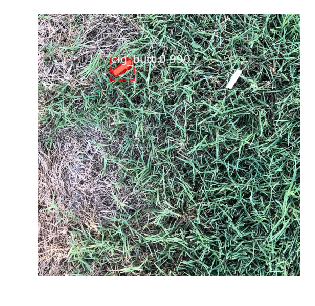

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -112.80000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


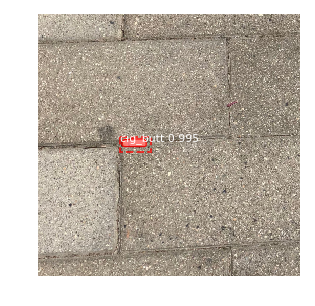

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


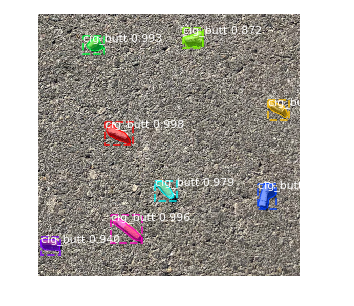

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


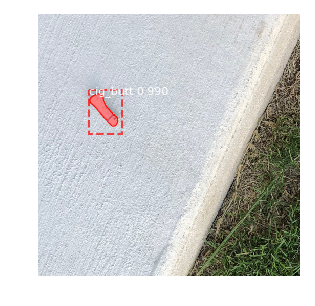

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


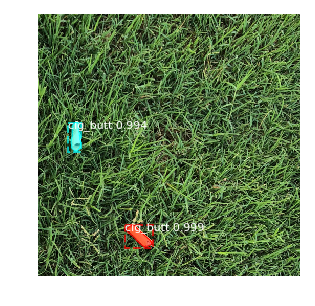

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


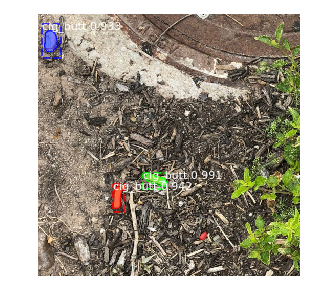

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


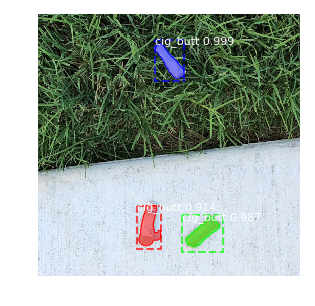

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


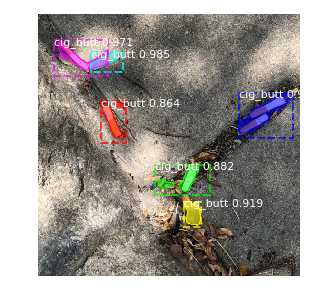

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


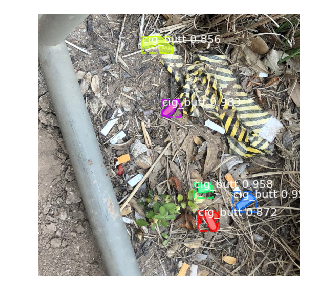

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


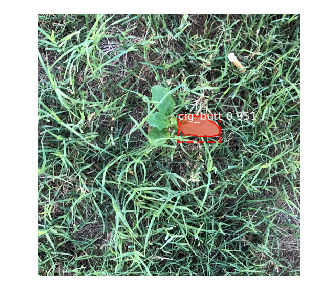

In [16]:
import skimage
real_test_dir = '/home/ayush/Instance_Segmentation/all/Mask_RCNN/Cigaettes_Dataset/cig_butts/real_test/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))